In [5]:
from TextNormalization.WithPytorch.dataloader import DataLoader

loader = DataLoader(10)
loader.parse_person_corpus('TextNormalization/Persons-1000/collection')
loader.parse_rdf_corpus('corpus_for_pakhomov_2/')

'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Абдулла Гюль.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Адам Осмаев.xml
'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Азим Исабеков.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Александр Глухов.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Александр Ломая.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Александр Медведько.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Анатолий Бибилов.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Андрей Аршавин.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Владимир Сергеевич Высоцкий.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Евгений Чичваркин.xml


In [2]:
from os.path import abspath

abspath('./')

'C:\\Users\\Sdernal\\Desktop\\Jackals'

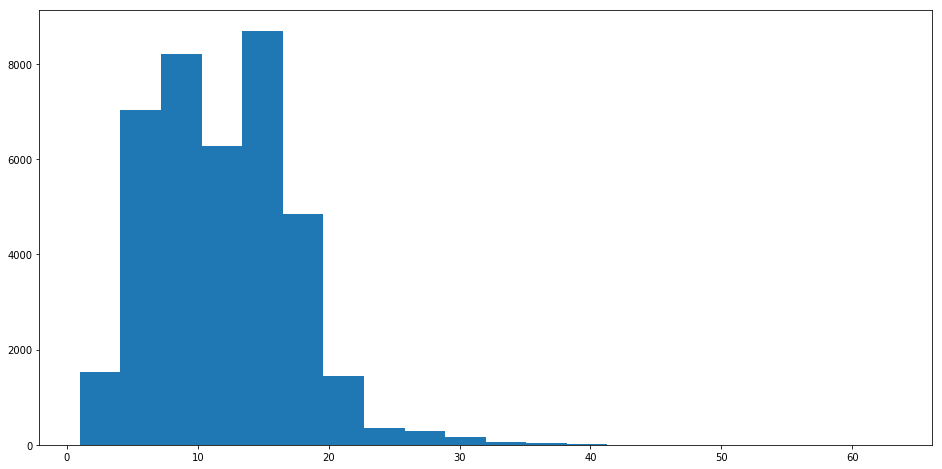

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
enteties_lengths = list(map(lambda x: x.length, loader.enties))
plt.figure(figsize=(16,8))
plt.hist(enteties_lengths, bins=20 )
plt.show()

In [35]:
from TextNormalization.WithPytorch.entriesprocessor import EntriesProcessor
ep = EntriesProcessor(20,40)
ep.process(loader.enties)

In [29]:
ep = EntriesProcessor()
ep.process(loader.enties)

In [1]:
import torch

In [10]:
a = torch.empty(1,*a).size()

In [36]:
len(ep.X_data)

37041

In [1]:
torch.ones(1,1,10)*2

NameError: name 'torch' is not defined

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [1]:
input = torch.randn(10, 10,requires_grad=True)
target = torch.ones(10, dtype=torch.long)
loss = nn.NLLLoss()
output = F.log_softmax(input, dim=1)
output = loss(output, target)

NameError: name 'torch' is not defined

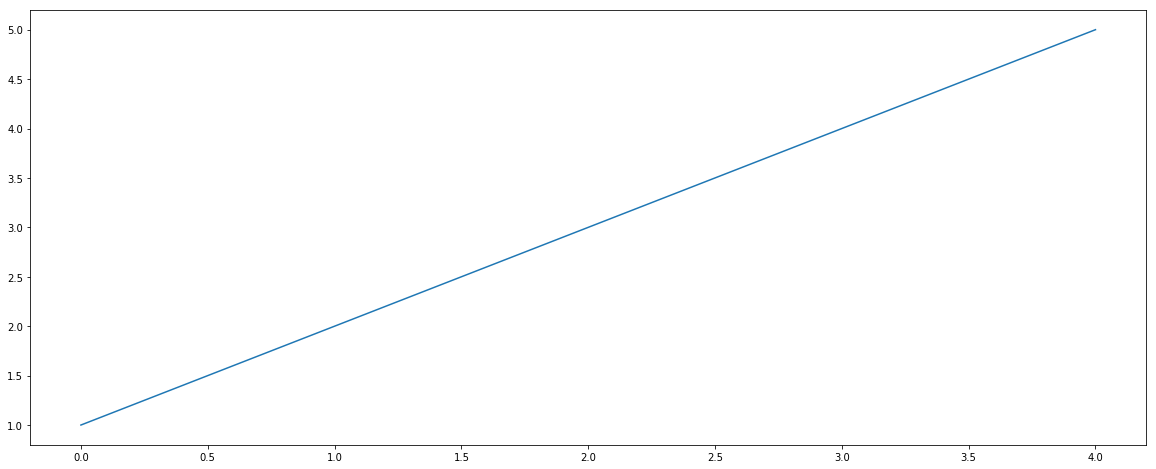

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,8))
plt.plot([1,2,3,4,5])

In [2]:
from dataloader import DataLoader
from os.path import abspath
from entriesprocessor import EntriesProcessor
from trainer import Trainer
from model import Decoder, Encoder
import torch

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 200
print(abspath('./'))
loader = DataLoader(10)
loader.parse_person_corpus(abspath('../Persons-1000/collection'))
loader.parse_rdf_corpus(abspath('../../corpus_for_pakhomov_2'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ep = EntriesProcessor(20,40)
# voc_size = 10
ep.process(loader.entries)
voc_size = ep.symbols_counter
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = Trainer(encoder,decoder,ep)

C:\Users\Sdernal\Desktop\Jackals\TextNormalization\WithPytorch


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Абдулла Гюль.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Адам Осмаев.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Азим Исабеков.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Глухов.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Ломая.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Медведько.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Анатолий Бибилов.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Андрей Аршавин.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Владимир Сергеевич Высоцкий.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Евгений Чичваркин.xml


In [3]:
train_losses_all, test_losses_all = [], []

In [17]:
train_losses, test_losses = trainer.train(50)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1


	Train Loss: 2.399487 	 Time: 0s

	Train Loss: 2.529612 	 Time: 0s

	Train Loss: 2.471210 	 Time: 0s

	Train Loss: 2.454590 	 Time: 0s

	Train Loss: 2.458952 	 Time: 1s

	Train Loss: 2.493810 	 Time: 1s

	Train Loss: 2.524473 	 Time: 1s

	Train Loss: 2.544438 	 Time: 1s

	Train Loss: 2.561085 	 Time: 2s

	Train Loss: 2.570417 	 Time: 2s

	Train Loss: 2.553503 	 Time: 2s

	Train Loss: 2.535411 	 Time: 2s

	Train Loss: 2.550881 	 Time: 2s

	Train Loss: 2.557664 	 Time: 3s

	Train Loss: 2.539656 	 Time: 3s

	Train Loss: 2.554034 	 Time: 4s

	Train Loss: 2.541387 	 Time: 4s

	Train Loss: 2.535427 	 Time: 4s

	Train Loss: 2.542658 	 Time: 4s

	Train Loss: 2.550547 	 Time: 5s

	Train Loss: 2.553178 	 Time: 5s

	Train Loss: 2.546342 	 Time: 5s

	Train Loss: 2.551047 	 Time: 5s

	Train Loss: 2.554469 	 Time: 6s

	Train Loss: 2.551545 	 Time: 6s

	Train Loss: 2.558353 	 Time: 6s

	Train Loss: 2.553334 	 Time: 6s

	Train Loss: 2.556678 	 Time: 7s

	Train Loss: 2.562264 	 Time: 7s

	Train Loss: 2.559092 	 Time: 7s

	Train Loss: 2.562590 	 Time: 7s

	Train Loss: 2.566565 	 Time: 7s

	Train Loss: 2.562344 	 Time: 8s

	Train Loss: 2.557247 	 Time: 8s

	Train Loss: 2.560324 	 Time: 8s

	Train Loss: 2.564034 	 Time: 8s

	Train Loss: 2.560793 	 Time: 8s

	Train Loss: 2.563145 	 Time: 9s

	Train Loss: 2.565758 	 Time: 9s

	Train Loss: 2.569201 	 Time: 9s

	Train Loss: 2.565341 	 Time: 9s

	Train Loss: 2.561679 	 Time: 9s

	Train Loss: 2.564818 	 Time: 10s

	Train Loss: 2.566565 	 Time: 10s

	Train Loss: 2.568347 	 Time: 10s

	Train Loss: 2.569048 	 Time: 10s

	Train Loss: 2.569122 	 Time: 11s

	Train Loss: 2.566231 	 Time: 11s

	Train Loss: 2.565677 	 Time: 11s

	Train Loss: 2.564379 	 Time: 12s

	Train Loss: 2.567911 	 Time: 12s

	Train Loss: 2.569093 	 Time: 12s

	Train Loss: 2.566377 	 Time: 12s

	Train Loss: 2.568252 	 Time: 13s

	Train Loss: 2.566564 	 Time: 13s

	Train Loss: 2.563346 	 Time: 13s

	Train Loss: 2.563300 	 Time: 14s

	Train Loss: 2.560013 	 Time: 14s

	Train Loss: 2.557535 	 Time: 14s

	Train Loss: 2.559340 	 Time: 14s

	Train Loss: 2.558847 	 Time: 14s

	Train Loss: 2.557219 	 Time: 15s

	Train Loss: 2.559488 	 Time: 15s

	Train Loss: 2.561788 	 Time: 15s

	Train Loss: 2.559664 	 Time: 15s

	Train Loss: 2.560568 	 Time: 16s

	Train Loss: 2.559390 	 Time: 16s

	Train Loss: 2.560687 	 Time: 16s

	Train Loss: 2.563905 	 Time: 16s

	Train Loss: 2.565530 	 Time: 17s

	Train Loss: 2.569144 	 Time: 17s

	Train Loss: 2.567304 	 Time: 17s

	Train Loss: 2.569059 	 Time: 18s

	Train Loss: 2.567501 	 Time: 18s

	Train Loss: 2.566233 	 Time: 18s

	Train Loss: 2.568244 	 Time: 18s

	Train Loss: 2.569697 	 Time: 18s

	Train Loss: 2.566228 	 Time: 19s

	Train Loss: 2.567294 	 Time: 19s

	Train Loss: 2.568765 	 Time: 19s

	Train Loss: 2.566804 	 Time: 19s

	Train Loss: 2.565396 	 Time: 20s

	Train Loss: 2.563974 	 Time: 20s

	Train Loss: 2.565309 	 Time: 20s

	Train Loss: 2.563541 	 Time: 21s

	Train Loss: 2.563648 	 Time: 21s

	Train Loss: 2.565610 	 Time: 21s

	Train Loss: 2.566840 	 Time: 21s

	Train Loss: 2.565588 	 Time: 22s

	Train Loss: 2.564704 	 Time: 22s

	Train Loss: 2.565616 	 Time: 22s

	Train Loss: 2.567313 	 Time: 22s

	Train Loss: 2.566092 	 Time: 23s

	Train Loss: 2.563661 	 Time: 23s

	Train Loss: 2.563832 	 Time: 23s

	Train Loss: 2.563253 	 Time: 24s

	Train Loss: 2.563695 	 Time: 24s

	Train Loss: 2.561563 	 Time: 24s

	Train Loss: 2.562056 	 Time: 25s

	Train Loss: 2.560959 	 Time: 25s

	Train Loss: 2.561669 	 Time: 25s

	Train Loss: 2.562960 	 Time: 25s

	Train Loss: 2.562212 	 Time: 26s

	Train Loss: 2.562754 	 Time: 26s

	Train Loss: 2.562035 	 Time: 26s

	Train Loss: 2.566066 	 Time: 27s


	Test Loss: 2.555582 	 Time: 0s
	 Input: нтом ссср михаилом горбачевым , по иниц 	 Result:  	 From train: 1
	 Input: й партии" давид усупашвили официальн 	 Result:  	 From train: 1
	 Input:  выступил лужков, который  	 Result:  	 From train: 1


	 Input: ия) имени мориса тореза. увлекся  	 Result:  	 From train: 1
	 Input: а юстиции александра ягодина заместите 	 Result:  	 From train: 1
Epoch 2


	Train Loss: 2.712583 	 Time: 0s

	Train Loss: 2.702821 	 Time: 0s

	Train Loss: 2.706251 	 Time: 0s

	Train Loss: 2.706709 	 Time: 0s

	Train Loss: 2.649704 	 Time: 1s

	Train Loss: 2.638121 	 Time: 1s

	Train Loss: 2.651725 	 Time: 1s

	Train Loss: 2.655865 	 Time: 2s

	Train Loss: 2.630321 	 Time: 2s

	Train Loss: 2.641735 	 Time: 2s

	Train Loss: 2.628970 	 Time: 2s

	Train Loss: 2.614632 	 Time: 3s

	Train Loss: 2.626426 	 Time: 3s

	Train Loss: 2.628190 	 Time: 3s

	Train Loss: 2.626192 	 Time: 3s

	Train Loss: 2.632262 	 Time: 4s

	Train Loss: 2.641126 	 Time: 4s

	Train Loss: 2.644512 	 Time: 5s

	Train Loss: 2.637865 	 Time: 5s

	Train Loss: 2.632197 	 Time: 5s

	Train Loss: 2.627432 	 Time: 5s

	Train Loss: 2.612549 	 Time: 6s

	Train Loss: 2.614687 	 Time: 6s

	Train Loss: 2.613501 	 Time: 6s

	Train Loss: 2.616589 	 Time: 7s

	Train Loss: 2.619066 	 Time: 7s

	Train Loss: 2.616317 	 Time: 7s

	Train Loss: 2.619980 	 Time: 7s

	Train Loss: 2.625406 	 Time: 8s

	Train Loss: 2.620314 	 Time: 8s

	Train Loss: 2.615081 	 Time: 8s

	Train Loss: 2.610185 	 Time: 9s

	Train Loss: 2.604216 	 Time: 9s

	Train Loss: 2.608124 	 Time: 9s

	Train Loss: 2.607018 	 Time: 9s

	Train Loss: 2.609274 	 Time: 10s

	Train Loss: 2.602334 	 Time: 10s

	Train Loss: 2.593822 	 Time: 10s

	Train Loss: 2.587437 	 Time: 11s

	Train Loss: 2.584683 	 Time: 11s

	Train Loss: 2.582800 	 Time: 11s

	Train Loss: 2.585467 	 Time: 12s

	Train Loss: 2.584938 	 Time: 12s

	Train Loss: 2.586783 	 Time: 12s

	Train Loss: 2.587831 	 Time: 12s

	Train Loss: 2.590083 	 Time: 13s

	Train Loss: 2.591358 	 Time: 13s

	Train Loss: 2.593605 	 Time: 13s

	Train Loss: 2.592112 	 Time: 14s

	Train Loss: 2.594498 	 Time: 14s

	Train Loss: 2.596972 	 Time: 14s

	Train Loss: 2.597489 	 Time: 14s

	Train Loss: 2.599228 	 Time: 14s

	Train Loss: 2.596639 	 Time: 15s

	Train Loss: 2.594538 	 Time: 15s

	Train Loss: 2.595981 	 Time: 15s

	Train Loss: 2.594095 	 Time: 16s

	Train Loss: 2.595566 	 Time: 16s

	Train Loss: 2.594179 	 Time: 16s

	Train Loss: 2.595936 	 Time: 16s

	Train Loss: 2.596312 	 Time: 17s

	Train Loss: 2.597625 	 Time: 17s

	Train Loss: 2.596177 	 Time: 17s

	Train Loss: 2.593170 	 Time: 17s

	Train Loss: 2.590297 	 Time: 18s

	Train Loss: 2.586022 	 Time: 18s

	Train Loss: 2.587138 	 Time: 18s

	Train Loss: 2.588297 	 Time: 19s

	Train Loss: 2.591034 	 Time: 19s

	Train Loss: 2.588238 	 Time: 19s

	Train Loss: 2.588956 	 Time: 20s

	Train Loss: 2.587378 	 Time: 20s

	Train Loss: 2.588766 	 Time: 20s

	Train Loss: 2.590565 	 Time: 20s

	Train Loss: 2.592883 	 Time: 21s

	Train Loss: 2.593740 	 Time: 21s

	Train Loss: 2.592787 	 Time: 21s

	Train Loss: 2.591112 	 Time: 21s

	Train Loss: 2.590131 	 Time: 22s

	Train Loss: 2.588743 	 Time: 22s

	Train Loss: 2.587176 	 Time: 22s

	Train Loss: 2.585672 	 Time: 22s

	Train Loss: 2.584378 	 Time: 23s

	Train Loss: 2.585220 	 Time: 23s

	Train Loss: 2.586222 	 Time: 23s

	Train Loss: 2.586852 	 Time: 24s

	Train Loss: 2.586399 	 Time: 24s

	Train Loss: 2.584359 	 Time: 24s

	Train Loss: 2.583726 	 Time: 25s

	Train Loss: 2.583029 	 Time: 25s

	Train Loss: 2.583995 	 Time: 25s

	Train Loss: 2.584822 	 Time: 25s

	Train Loss: 2.584422 	 Time: 26s

	Train Loss: 2.588387 	 Time: 26s


	Test Loss: 2.517513 	 Time: 0s
	 Input:  назначил надежду синикову руководит 	 Result:  	 From train: 1
	 Input: ции роз", маисашвили был имидж 	 Result:  	 From train: 1
	 Input: кого края александром лебедем. поводом  	 Result:  	 From train: 1


	 Input: лось, что собянин разработа 	 Result:  	 From train: 0
	 Input: ) и юлия (julia), которым 	 Result:  	 From train: 1
Epoch 3


	Train Loss: 2.484691 	 Time: 0s

	Train Loss: 2.431402 	 Time: 0s

	Train Loss: 2.507875 	 Time: 0s

	Train Loss: 2.561397 	 Time: 1s

	Train Loss: 2.547289 	 Time: 1s

	Train Loss: 2.536455 	 Time: 1s

	Train Loss: 2.556388 	 Time: 2s

	Train Loss: 2.581615 	 Time: 2s

	Train Loss: 2.571445 	 Time: 2s

	Train Loss: 2.579085 	 Time: 2s

	Train Loss: 2.589599 	 Time: 3s

	Train Loss: 2.597918 	 Time: 3s

	Train Loss: 2.607361 	 Time: 3s

	Train Loss: 2.598427 	 Time: 4s

	Train Loss: 2.604841 	 Time: 4s

	Train Loss: 2.588772 	 Time: 4s

	Train Loss: 2.599915 	 Time: 5s

	Train Loss: 2.604129 	 Time: 5s

	Train Loss: 2.594932 	 Time: 5s

	Train Loss: 2.580527 	 Time: 5s

	Train Loss: 2.578291 	 Time: 6s

	Train Loss: 2.575119 	 Time: 6s

	Train Loss: 2.563847 	 Time: 6s

	Train Loss: 2.566596 	 Time: 6s

	Train Loss: 2.570998 	 Time: 7s

	Train Loss: 2.574870 	 Time: 7s

	Train Loss: 2.578922 	 Time: 7s

	Train Loss: 2.576290 	 Time: 7s

	Train Loss: 2.576012 	 Time: 8s

	Train Loss: 2.571906 	 Time: 8s

	Train Loss: 2.571648 	 Time: 8s

	Train Loss: 2.574319 	 Time: 8s

	Train Loss: 2.576625 	 Time: 9s

	Train Loss: 2.575030 	 Time: 9s

	Train Loss: 2.572970 	 Time: 9s

	Train Loss: 2.567297 	 Time: 10s

	Train Loss: 2.572242 	 Time: 10s

	Train Loss: 2.573015 	 Time: 10s

	Train Loss: 2.576738 	 Time: 11s

	Train Loss: 2.579705 	 Time: 11s

	Train Loss: 2.581664 	 Time: 11s

	Train Loss: 2.581639 	 Time: 11s

	Train Loss: 2.582617 	 Time: 12s

	Train Loss: 2.577612 	 Time: 12s

	Train Loss: 2.579663 	 Time: 12s

	Train Loss: 2.580461 	 Time: 13s

	Train Loss: 2.581398 	 Time: 13s

	Train Loss: 2.583832 	 Time: 13s

	Train Loss: 2.578535 	 Time: 13s

	Train Loss: 2.579620 	 Time: 14s

	Train Loss: 2.580156 	 Time: 14s

	Train Loss: 2.576996 	 Time: 14s

	Train Loss: 2.573876 	 Time: 15s

	Train Loss: 2.576380 	 Time: 15s

	Train Loss: 2.578149 	 Time: 15s

	Train Loss: 2.579743 	 Time: 15s

	Train Loss: 2.577369 	 Time: 15s

	Train Loss: 2.575737 	 Time: 16s

	Train Loss: 2.573759 	 Time: 16s

	Train Loss: 2.572074 	 Time: 16s

	Train Loss: 2.573946 	 Time: 16s

	Train Loss: 2.571619 	 Time: 16s

	Train Loss: 2.572961 	 Time: 17s

	Train Loss: 2.571392 	 Time: 17s

	Train Loss: 2.572371 	 Time: 17s

	Train Loss: 2.569999 	 Time: 17s

	Train Loss: 2.568349 	 Time: 18s

	Train Loss: 2.569168 	 Time: 18s

	Train Loss: 2.570616 	 Time: 18s

	Train Loss: 2.568950 	 Time: 18s

	Train Loss: 2.568796 	 Time: 19s

	Train Loss: 2.570193 	 Time: 19s

	Train Loss: 2.571258 	 Time: 19s

	Train Loss: 2.569629 	 Time: 19s

	Train Loss: 2.568009 	 Time: 20s

	Train Loss: 2.566283 	 Time: 20s

	Train Loss: 2.564550 	 Time: 20s

	Train Loss: 2.563288 	 Time: 20s

	Train Loss: 2.564545 	 Time: 20s

	Train Loss: 2.566158 	 Time: 21s

	Train Loss: 2.564985 	 Time: 21s

	Train Loss: 2.565432 	 Time: 21s

	Train Loss: 2.564536 	 Time: 21s

	Train Loss: 2.564275 	 Time: 22s

	Train Loss: 2.562715 	 Time: 22s

	Train Loss: 2.562078 	 Time: 22s

	Train Loss: 2.560530 	 Time: 23s

	Train Loss: 2.559755 	 Time: 23s

	Train Loss: 2.558397 	 Time: 23s

	Train Loss: 2.558186 	 Time: 24s

	Train Loss: 2.559706 	 Time: 24s

	Train Loss: 2.560897 	 Time: 24s

	Train Loss: 2.560143 	 Time: 24s

	Train Loss: 2.561063 	 Time: 25s

	Train Loss: 2.563866 	 Time: 25s

	Train Loss: 2.565866 	 Time: 25s

	Train Loss: 2.564928 	 Time: 26s

	Train Loss: 2.565848 	 Time: 26s

	Train Loss: 2.567350 	 Time: 26s


	Test Loss: 2.502491 	 Time: 0s
	 Input: господина ровенского, он с 1 и 	 Result:  	 From train: 1
	 Input: иниматели ефим басин, михаил д 	 Result:  	 From train: 1
	 Input: й области андрей пинигин, утвержда 	 Result:  	 From train: 1


	 Input: идрисова. абдусамад гамидов в прошлый 	 Result:  	 From train: 1
	 Input:  есть сын андрей, который  	 Result:  	 From train: 0
Epoch 4


	Train Loss: 2.707450 	 Time: 0s

	Train Loss: 2.709100 	 Time: 0s

	Train Loss: 2.643489 	 Time: 1s

	Train Loss: 2.609355 	 Time: 1s

	Train Loss: 2.578046 	 Time: 1s

	Train Loss: 2.595287 	 Time: 1s

	Train Loss: 2.586241 	 Time: 2s

	Train Loss: 2.569503 	 Time: 2s

	Train Loss: 2.558533 	 Time: 2s

	Train Loss: 2.545598 	 Time: 2s

	Train Loss: 2.550251 	 Time: 2s

	Train Loss: 2.546774 	 Time: 3s

	Train Loss: 2.556706 	 Time: 3s

	Train Loss: 2.565570 	 Time: 3s

	Train Loss: 2.563176 	 Time: 4s

	Train Loss: 2.560270 	 Time: 4s

	Train Loss: 2.549376 	 Time: 4s

	Train Loss: 2.535817 	 Time: 5s

	Train Loss: 2.545253 	 Time: 5s

	Train Loss: 2.549371 	 Time: 5s

	Train Loss: 2.556074 	 Time: 5s

	Train Loss: 2.552565 	 Time: 5s

	Train Loss: 2.561030 	 Time: 6s

	Train Loss: 2.555587 	 Time: 6s

	Train Loss: 2.556195 	 Time: 6s

	Train Loss: 2.556220 	 Time: 7s

	Train Loss: 2.553038 	 Time: 7s

	Train Loss: 2.554365 	 Time: 7s

	Train Loss: 2.550576 	 Time: 8s

	Train Loss: 2.554953 	 Time: 8s

	Train Loss: 2.551742 	 Time: 8s

	Train Loss: 2.553914 	 Time: 8s

	Train Loss: 2.556010 	 Time: 8s

	Train Loss: 2.557276 	 Time: 9s

	Train Loss: 2.560096 	 Time: 9s

	Train Loss: 2.565352 	 Time: 9s

	Train Loss: 2.572012 	 Time: 10s

	Train Loss: 2.564783 	 Time: 10s

	Train Loss: 2.564782 	 Time: 11s

	Train Loss: 2.566147 	 Time: 11s

	Train Loss: 2.568803 	 Time: 11s

	Train Loss: 2.567087 	 Time: 11s

	Train Loss: 2.569113 	 Time: 12s

	Train Loss: 2.567310 	 Time: 12s

	Train Loss: 2.566544 	 Time: 12s

	Train Loss: 2.568345 	 Time: 12s

	Train Loss: 2.571892 	 Time: 13s

	Train Loss: 2.573927 	 Time: 13s

	Train Loss: 2.575891 	 Time: 13s

	Train Loss: 2.579787 	 Time: 14s

	Train Loss: 2.581609 	 Time: 14s

	Train Loss: 2.580128 	 Time: 14s

	Train Loss: 2.577286 	 Time: 14s

	Train Loss: 2.574508 	 Time: 15s

	Train Loss: 2.575539 	 Time: 15s

	Train Loss: 2.577664 	 Time: 15s

	Train Loss: 2.577667 	 Time: 15s

	Train Loss: 2.578743 	 Time: 16s

	Train Loss: 2.574334 	 Time: 16s

	Train Loss: 2.569746 	 Time: 17s

	Train Loss: 2.571613 	 Time: 17s

	Train Loss: 2.573064 	 Time: 17s

	Train Loss: 2.571131 	 Time: 17s

	Train Loss: 2.572982 	 Time: 17s

	Train Loss: 2.573536 	 Time: 18s

	Train Loss: 2.575894 	 Time: 18s

	Train Loss: 2.576743 	 Time: 18s

	Train Loss: 2.578703 	 Time: 18s

	Train Loss: 2.579008 	 Time: 19s

	Train Loss: 2.576645 	 Time: 19s

	Train Loss: 2.576671 	 Time: 20s

	Train Loss: 2.574644 	 Time: 20s

	Train Loss: 2.574506 	 Time: 20s

	Train Loss: 2.575744 	 Time: 21s

	Train Loss: 2.573075 	 Time: 21s

	Train Loss: 2.576007 	 Time: 21s

	Train Loss: 2.576416 	 Time: 22s

	Train Loss: 2.577438 	 Time: 22s

	Train Loss: 2.578957 	 Time: 22s

	Train Loss: 2.577788 	 Time: 22s

	Train Loss: 2.578563 	 Time: 22s

	Train Loss: 2.580517 	 Time: 23s

	Train Loss: 2.581513 	 Time: 23s

	Train Loss: 2.579944 	 Time: 23s

	Train Loss: 2.581034 	 Time: 23s

	Train Loss: 2.580706 	 Time: 24s

	Train Loss: 2.581753 	 Time: 24s

	Train Loss: 2.580080 	 Time: 24s

	Train Loss: 2.579833 	 Time: 25s

	Train Loss: 2.580792 	 Time: 25s

	Train Loss: 2.579296 	 Time: 25s

	Train Loss: 2.580055 	 Time: 25s

	Train Loss: 2.578813 	 Time: 26s

	Train Loss: 2.579721 	 Time: 26s


	Test Loss: 2.502706 	 Time: 0s
	 Input: умеренный хасан рохани (hassan r 	 Result:  	 From train: 1
	 Input: сть сын и дочь. награжде 	 Result:  	 From train: 1
	 Input: > <body>  генри "трей" об 	 Result:  	 From train: 1
	 Input: местителя начальника генштаба. 	 Result:  	 From train: 1


	 Input: миров.

шантимиров уточнял,  	 Result:  	 From train: 1
Epoch 5


	Train Loss: 2.486785 	 Time: 0s

	Train Loss: 2.440548 	 Time: 0s

	Train Loss: 2.507329 	 Time: 0s

	Train Loss: 2.501972 	 Time: 1s

	Train Loss: 2.520508 	 Time: 1s

	Train Loss: 2.510978 	 Time: 1s

	Train Loss: 2.512263 	 Time: 1s

	Train Loss: 2.523634 	 Time: 2s

	Train Loss: 2.534524 	 Time: 2s

	Train Loss: 2.542462 	 Time: 2s

	Train Loss: 2.531424 	 Time: 3s

	Train Loss: 2.521066 	 Time: 3s

	Train Loss: 2.525664 	 Time: 3s

	Train Loss: 2.518248 	 Time: 3s

	Train Loss: 2.526175 	 Time: 4s

	Train Loss: 2.519299 	 Time: 4s

	Train Loss: 2.533126 	 Time: 4s

	Train Loss: 2.530327 	 Time: 4s

	Train Loss: 2.536517 	 Time: 5s

	Train Loss: 2.530980 	 Time: 5s

	Train Loss: 2.535249 	 Time: 5s

	Train Loss: 2.544615 	 Time: 5s

	Train Loss: 2.549160 	 Time: 6s

	Train Loss: 2.543527 	 Time: 6s

	Train Loss: 2.541110 	 Time: 6s

	Train Loss: 2.540950 	 Time: 6s

	Train Loss: 2.541868 	 Time: 7s

	Train Loss: 2.538923 	 Time: 7s

	Train Loss: 2.550343 	 Time: 7s

	Train Loss: 2.546999 	 Time: 7s

	Train Loss: 2.539673 	 Time: 8s

	Train Loss: 2.543457 	 Time: 8s

	Train Loss: 2.539436 	 Time: 8s

	Train Loss: 2.536469 	 Time: 8s

	Train Loss: 2.539247 	 Time: 9s

	Train Loss: 2.536643 	 Time: 9s

	Train Loss: 2.532401 	 Time: 9s

	Train Loss: 2.529978 	 Time: 9s

	Train Loss: 2.530210 	 Time: 10s

	Train Loss: 2.529000 	 Time: 10s

	Train Loss: 2.526480 	 Time: 10s

	Train Loss: 2.530077 	 Time: 11s

	Train Loss: 2.528642 	 Time: 11s

	Train Loss: 2.527228 	 Time: 11s

	Train Loss: 2.529021 	 Time: 11s

	Train Loss: 2.527790 	 Time: 12s

	Train Loss: 2.530019 	 Time: 12s

	Train Loss: 2.527240 	 Time: 12s

	Train Loss: 2.525474 	 Time: 12s

	Train Loss: 2.521002 	 Time: 13s

	Train Loss: 2.519033 	 Time: 13s

	Train Loss: 2.516535 	 Time: 13s

	Train Loss: 2.519885 	 Time: 13s

	Train Loss: 2.521710 	 Time: 14s

	Train Loss: 2.518677 	 Time: 14s

	Train Loss: 2.524818 	 Time: 14s

	Train Loss: 2.523290 	 Time: 15s

	Train Loss: 2.519130 	 Time: 15s

	Train Loss: 2.521613 	 Time: 15s

	Train Loss: 2.523661 	 Time: 15s

	Train Loss: 2.526087 	 Time: 16s

	Train Loss: 2.523574 	 Time: 16s

	Train Loss: 2.525093 	 Time: 16s

	Train Loss: 2.523876 	 Time: 16s

	Train Loss: 2.528553 	 Time: 17s

	Train Loss: 2.526927 	 Time: 17s

	Train Loss: 2.526103 	 Time: 18s

	Train Loss: 2.524161 	 Time: 18s

	Train Loss: 2.523191 	 Time: 18s

	Train Loss: 2.522991 	 Time: 18s

	Train Loss: 2.522161 	 Time: 19s

	Train Loss: 2.521473 	 Time: 19s

	Train Loss: 2.521937 	 Time: 19s

	Train Loss: 2.521309 	 Time: 20s

	Train Loss: 2.518295 	 Time: 20s

	Train Loss: 2.520028 	 Time: 20s

	Train Loss: 2.518688 	 Time: 21s

	Train Loss: 2.519634 	 Time: 21s

	Train Loss: 2.521705 	 Time: 21s

	Train Loss: 2.522009 	 Time: 22s

	Train Loss: 2.524364 	 Time: 22s

	Train Loss: 2.523297 	 Time: 22s

	Train Loss: 2.524349 	 Time: 22s

	Train Loss: 2.525247 	 Time: 22s

	Train Loss: 2.524432 	 Time: 23s

	Train Loss: 2.525776 	 Time: 23s

	Train Loss: 2.525327 	 Time: 23s

	Train Loss: 2.527563 	 Time: 24s

	Train Loss: 2.528412 	 Time: 24s

	Train Loss: 2.530483 	 Time: 24s

	Train Loss: 2.531736 	 Time: 25s

	Train Loss: 2.533239 	 Time: 25s

	Train Loss: 2.534650 	 Time: 25s

	Train Loss: 2.533155 	 Time: 25s

	Train Loss: 2.532800 	 Time: 25s

	Train Loss: 2.534460 	 Time: 26s

	Train Loss: 2.535453 	 Time: 26s

	Train Loss: 2.537064 	 Time: 26s

	Train Loss: 2.538553 	 Time: 26s


	Test Loss: 2.515995 	 Time: 0s
	 Input: атанович (раппопорт.- "ъ") ух 	 Result:  	 From train: 1
	 Input: тром стал джон брайсон (john bry 	 Result:  	 From train: 1
	 Input:  прадед и прапрадед участвова 	 Result:  	 From train: 1


	 Input: эвид хэй (david haye), который 	 Result:  	 From train: 1
	 Input: сетинская жанна д'арк". предста 	 Result:  	 From train: 1
Epoch 6


	Train Loss: 2.445116 	 Time: 0s

	Train Loss: 2.455798 	 Time: 0s

	Train Loss: 2.492615 	 Time: 1s

	Train Loss: 2.515221 	 Time: 1s

	Train Loss: 2.513970 	 Time: 1s

	Train Loss: 2.483625 	 Time: 2s

	Train Loss: 2.477536 	 Time: 2s

	Train Loss: 2.474872 	 Time: 2s

	Train Loss: 2.503716 	 Time: 2s

	Train Loss: 2.499855 	 Time: 3s

	Train Loss: 2.512591 	 Time: 3s

	Train Loss: 2.507519 	 Time: 3s

	Train Loss: 2.502277 	 Time: 3s

	Train Loss: 2.498490 	 Time: 4s

	Train Loss: 2.508395 	 Time: 4s

	Train Loss: 2.514411 	 Time: 4s

	Train Loss: 2.510228 	 Time: 4s

	Train Loss: 2.505634 	 Time: 5s

	Train Loss: 2.505622 	 Time: 5s

	Train Loss: 2.501412 	 Time: 5s

	Train Loss: 2.507404 	 Time: 5s

	Train Loss: 2.505595 	 Time: 5s

	Train Loss: 2.512796 	 Time: 6s

	Train Loss: 2.522994 	 Time: 6s

	Train Loss: 2.520693 	 Time: 6s

	Train Loss: 2.526167 	 Time: 6s

	Train Loss: 2.525369 	 Time: 7s

	Train Loss: 2.518977 	 Time: 7s

	Train Loss: 2.523248 	 Time: 7s

	Train Loss: 2.521505 	 Time: 7s

	Train Loss: 2.519070 	 Time: 7s

	Train Loss: 2.523758 	 Time: 8s

	Train Loss: 2.526880 	 Time: 8s

	Train Loss: 2.526682 	 Time: 8s

	Train Loss: 2.524496 	 Time: 9s

	Train Loss: 2.531806 	 Time: 9s

	Train Loss: 2.528585 	 Time: 9s

	Train Loss: 2.532570 	 Time: 9s

	Train Loss: 2.535734 	 Time: 10s

	Train Loss: 2.537540 	 Time: 10s

	Train Loss: 2.539516 	 Time: 10s

	Train Loss: 2.538750 	 Time: 10s

	Train Loss: 2.536907 	 Time: 11s

	Train Loss: 2.540655 	 Time: 11s

	Train Loss: 2.538785 	 Time: 11s

	Train Loss: 2.543144 	 Time: 11s

	Train Loss: 2.539447 	 Time: 11s

	Train Loss: 2.537852 	 Time: 12s

	Train Loss: 2.540545 	 Time: 12s

	Train Loss: 2.535644 	 Time: 12s

	Train Loss: 2.538756 	 Time: 12s

	Train Loss: 2.536502 	 Time: 13s

	Train Loss: 2.533641 	 Time: 13s

	Train Loss: 2.536580 	 Time: 13s

	Train Loss: 2.537299 	 Time: 14s

	Train Loss: 2.538881 	 Time: 14s

	Train Loss: 2.536100 	 Time: 14s

	Train Loss: 2.537615 	 Time: 15s

	Train Loss: 2.537790 	 Time: 15s

	Train Loss: 2.536353 	 Time: 15s

	Train Loss: 2.538817 	 Time: 16s

	Train Loss: 2.540082 	 Time: 16s

	Train Loss: 2.542642 	 Time: 16s

	Train Loss: 2.540607 	 Time: 16s

	Train Loss: 2.543073 	 Time: 17s

	Train Loss: 2.542099 	 Time: 17s

	Train Loss: 2.539398 	 Time: 17s

	Train Loss: 2.541000 	 Time: 17s

	Train Loss: 2.539423 	 Time: 17s

	Train Loss: 2.537569 	 Time: 18s

	Train Loss: 2.536409 	 Time: 18s

	Train Loss: 2.535451 	 Time: 18s

	Train Loss: 2.536662 	 Time: 19s

	Train Loss: 2.534737 	 Time: 19s

	Train Loss: 2.536943 	 Time: 19s

	Train Loss: 2.538661 	 Time: 19s

	Train Loss: 2.537714 	 Time: 19s

	Train Loss: 2.534951 	 Time: 20s

	Train Loss: 2.535049 	 Time: 20s

	Train Loss: 2.531724 	 Time: 21s

	Train Loss: 2.532212 	 Time: 21s

	Train Loss: 2.530721 	 Time: 21s

	Train Loss: 2.530160 	 Time: 21s

	Train Loss: 2.531639 	 Time: 22s

	Train Loss: 2.533240 	 Time: 22s

	Train Loss: 2.532761 	 Time: 22s

	Train Loss: 2.534222 	 Time: 22s

	Train Loss: 2.535697 	 Time: 22s

	Train Loss: 2.535281 	 Time: 23s

	Train Loss: 2.536595 	 Time: 23s

	Train Loss: 2.535027 	 Time: 23s

	Train Loss: 2.537626 	 Time: 24s

	Train Loss: 2.539110 	 Time: 24s

	Train Loss: 2.539686 	 Time: 24s

	Train Loss: 2.539144 	 Time: 25s

	Train Loss: 2.540794 	 Time: 25s

	Train Loss: 2.542850 	 Time: 25s

	Train Loss: 2.541699 	 Time: 25s

	Train Loss: 2.543025 	 Time: 25s

	Train Loss: 2.542344 	 Time: 26s

	Train Loss: 2.543643 	 Time: 26s

	Train Loss: 2.543749 	 Time: 26s

	Train Loss: 2.542231 	 Time: 26s

	Train Loss: 2.543880 	 Time: 26s


	Test Loss: 2.526994 	 Time: 0s
	 Input:  ющенко и тимошенко.

некон 	 Result:  	 From train: 1
	 Input: нимался - палихата сам предл 	 Result:  	 From train: 1
	 Input: о, помимо э.росселя и а.мишар 	 Result:  	 From train: 1


	 Input: а: вместо ахмеда назифа (ahmed na 	 Result:  	 From train: 1
	 Input:  капелло (fabio capello) заявлял, 	 Result:  	 From train: 0
Epoch 7


	Train Loss: 2.463120 	 Time: 0s

	Train Loss: 2.580777 	 Time: 0s

	Train Loss: 2.600205 	 Time: 0s

	Train Loss: 2.549184 	 Time: 0s

	Train Loss: 2.580059 	 Time: 1s

	Train Loss: 2.532093 	 Time: 1s

	Train Loss: 2.550072 	 Time: 1s

	Train Loss: 2.531694 	 Time: 1s

	Train Loss: 2.520038 	 Time: 2s

	Train Loss: 2.520696 	 Time: 2s

	Train Loss: 2.526712 	 Time: 2s

	Train Loss: 2.546507 	 Time: 3s

	Train Loss: 2.556068 	 Time: 3s

	Train Loss: 2.541849 	 Time: 3s

	Train Loss: 2.548788 	 Time: 4s

	Train Loss: 2.538332 	 Time: 4s

	Train Loss: 2.545397 	 Time: 4s

	Train Loss: 2.559822 	 Time: 5s

	Train Loss: 2.555375 	 Time: 5s

	Train Loss: 2.549280 	 Time: 5s

	Train Loss: 2.543768 	 Time: 5s

	Train Loss: 2.541589 	 Time: 5s

	Train Loss: 2.537828 	 Time: 6s

	Train Loss: 2.535064 	 Time: 6s

	Train Loss: 2.530654 	 Time: 6s

	Train Loss: 2.528226 	 Time: 6s

	Train Loss: 2.524207 	 Time: 7s

	Train Loss: 2.520110 	 Time: 7s

	Train Loss: 2.513278 	 Time: 8s

	Train Loss: 2.506522 	 Time: 8s

	Train Loss: 2.504879 	 Time: 8s

	Train Loss: 2.509705 	 Time: 8s

	Train Loss: 2.514722 	 Time: 9s

	Train Loss: 2.511803 	 Time: 9s

	Train Loss: 2.516287 	 Time: 9s

	Train Loss: 2.520112 	 Time: 10s

	Train Loss: 2.517493 	 Time: 10s

	Train Loss: 2.525891 	 Time: 10s

	Train Loss: 2.528055 	 Time: 10s

	Train Loss: 2.524436 	 Time: 11s

	Train Loss: 2.529201 	 Time: 11s

	Train Loss: 2.527803 	 Time: 11s

	Train Loss: 2.525527 	 Time: 11s

	Train Loss: 2.522960 	 Time: 11s

	Train Loss: 2.521504 	 Time: 12s

	Train Loss: 2.524032 	 Time: 12s

	Train Loss: 2.525958 	 Time: 12s

	Train Loss: 2.528517 	 Time: 13s

	Train Loss: 2.530779 	 Time: 13s

	Train Loss: 2.536908 	 Time: 13s

	Train Loss: 2.540115 	 Time: 13s

	Train Loss: 2.543101 	 Time: 14s

	Train Loss: 2.545401 	 Time: 14s

	Train Loss: 2.543541 	 Time: 14s

	Train Loss: 2.542131 	 Time: 14s

	Train Loss: 2.540584 	 Time: 14s

	Train Loss: 2.540768 	 Time: 15s

	Train Loss: 2.537499 	 Time: 15s

	Train Loss: 2.539677 	 Time: 15s

	Train Loss: 2.541944 	 Time: 16s

	Train Loss: 2.538468 	 Time: 16s

	Train Loss: 2.539295 	 Time: 17s

	Train Loss: 2.538163 	 Time: 17s

	Train Loss: 2.536601 	 Time: 17s

	Train Loss: 2.538978 	 Time: 17s

	Train Loss: 2.536313 	 Time: 18s

	Train Loss: 2.537663 	 Time: 18s

	Train Loss: 2.537760 	 Time: 18s

	Train Loss: 2.535155 	 Time: 19s

	Train Loss: 2.536996 	 Time: 19s

	Train Loss: 2.534268 	 Time: 19s

	Train Loss: 2.537312 	 Time: 20s

	Train Loss: 2.538063 	 Time: 20s

	Train Loss: 2.539030 	 Time: 20s

	Train Loss: 2.540183 	 Time: 21s

	Train Loss: 2.539892 	 Time: 21s

	Train Loss: 2.538220 	 Time: 21s

	Train Loss: 2.538972 	 Time: 22s

	Train Loss: 2.538891 	 Time: 22s

	Train Loss: 2.539522 	 Time: 23s

	Train Loss: 2.538625 	 Time: 23s

	Train Loss: 2.538009 	 Time: 23s

	Train Loss: 2.538270 	 Time: 23s

	Train Loss: 2.536942 	 Time: 24s

	Train Loss: 2.535265 	 Time: 24s

	Train Loss: 2.533934 	 Time: 24s

	Train Loss: 2.536650 	 Time: 25s

	Train Loss: 2.539115 	 Time: 25s

	Train Loss: 2.538885 	 Time: 25s

	Train Loss: 2.538786 	 Time: 26s

	Train Loss: 2.537942 	 Time: 26s

	Train Loss: 2.538485 	 Time: 26s


	Test Loss: 2.511509 	 Time: 0s
	 Input: контроля, вадиму козлову, было пре 	 Result:  	 From train: 1
	 Input:  на смену мураду меделси, который  	 Result:  	 From train: 1
	 Input: и буллок. кузнецов и буллок  	 Result:  	 From train: 0


	 Input: ь карьера алексея бендусова. в октябр 	 Result:  	 From train: 1
	 Input:  компании батурина принадлеж 	 Result:  	 From train: 1
Epoch 8


	Train Loss: 2.453738 	 Time: 0s

	Train Loss: 2.535725 	 Time: 0s

	Train Loss: 2.577109 	 Time: 0s

	Train Loss: 2.587263 	 Time: 1s

	Train Loss: 2.560685 	 Time: 1s

	Train Loss: 2.576376 	 Time: 1s

	Train Loss: 2.550720 	 Time: 1s

	Train Loss: 2.576423 	 Time: 1s

	Train Loss: 2.560472 	 Time: 2s

	Train Loss: 2.552166 	 Time: 2s

	Train Loss: 2.562736 	 Time: 2s

	Train Loss: 2.551211 	 Time: 3s

	Train Loss: 2.550510 	 Time: 3s

	Train Loss: 2.553953 	 Time: 3s

	Train Loss: 2.539853 	 Time: 4s

	Train Loss: 2.553874 	 Time: 4s

	Train Loss: 2.564366 	 Time: 4s

	Train Loss: 2.557997 	 Time: 5s

	Train Loss: 2.562270 	 Time: 5s

	Train Loss: 2.566433 	 Time: 5s

	Train Loss: 2.553281 	 Time: 6s

	Train Loss: 2.553059 	 Time: 6s

	Train Loss: 2.561156 	 Time: 6s

	Train Loss: 2.566950 	 Time: 7s

	Train Loss: 2.561367 	 Time: 7s

	Train Loss: 2.565019 	 Time: 7s

	Train Loss: 2.565593 	 Time: 8s

	Train Loss: 2.570508 	 Time: 8s

	Train Loss: 2.575956 	 Time: 8s

	Train Loss: 2.568651 	 Time: 9s

	Train Loss: 2.566197 	 Time: 9s

	Train Loss: 2.561538 	 Time: 9s

	Train Loss: 2.565161 	 Time: 9s

	Train Loss: 2.566767 	 Time: 9s

	Train Loss: 2.570112 	 Time: 10s

	Train Loss: 2.571153 	 Time: 10s

	Train Loss: 2.573225 	 Time: 10s

	Train Loss: 2.567965 	 Time: 10s

	Train Loss: 2.569766 	 Time: 11s

	Train Loss: 2.572015 	 Time: 11s

	Train Loss: 2.576055 	 Time: 11s

	Train Loss: 2.579578 	 Time: 11s

	Train Loss: 2.578120 	 Time: 12s

	Train Loss: 2.576326 	 Time: 12s

	Train Loss: 2.573907 	 Time: 12s

	Train Loss: 2.576487 	 Time: 12s

	Train Loss: 2.578067 	 Time: 13s

	Train Loss: 2.577192 	 Time: 13s

	Train Loss: 2.578669 	 Time: 13s

	Train Loss: 2.580901 	 Time: 13s

	Train Loss: 2.578550 	 Time: 14s

	Train Loss: 2.577242 	 Time: 14s

	Train Loss: 2.574763 	 Time: 14s

	Train Loss: 2.577036 	 Time: 14s

	Train Loss: 2.574573 	 Time: 15s

	Train Loss: 2.576792 	 Time: 15s

	Train Loss: 2.576009 	 Time: 15s

	Train Loss: 2.574287 	 Time: 15s

	Train Loss: 2.576358 	 Time: 16s

	Train Loss: 2.577054 	 Time: 16s

	Train Loss: 2.576298 	 Time: 16s

	Train Loss: 2.577408 	 Time: 17s

	Train Loss: 2.576945 	 Time: 17s

	Train Loss: 2.576918 	 Time: 17s

	Train Loss: 2.576684 	 Time: 18s

	Train Loss: 2.573986 	 Time: 18s

	Train Loss: 2.571205 	 Time: 18s

	Train Loss: 2.568897 	 Time: 18s

	Train Loss: 2.571352 	 Time: 19s

	Train Loss: 2.567685 	 Time: 19s

	Train Loss: 2.568946 	 Time: 19s

	Train Loss: 2.566947 	 Time: 20s

	Train Loss: 2.567328 	 Time: 20s

	Train Loss: 2.566472 	 Time: 20s

	Train Loss: 2.565087 	 Time: 20s

	Train Loss: 2.566532 	 Time: 20s

	Train Loss: 2.567514 	 Time: 21s

	Train Loss: 2.568158 	 Time: 21s

	Train Loss: 2.569758 	 Time: 21s

	Train Loss: 2.569419 	 Time: 22s

	Train Loss: 2.570842 	 Time: 22s

	Train Loss: 2.569968 	 Time: 22s

	Train Loss: 2.569301 	 Time: 22s

	Train Loss: 2.569399 	 Time: 23s

	Train Loss: 2.568069 	 Time: 23s

	Train Loss: 2.568011 	 Time: 23s

	Train Loss: 2.569371 	 Time: 23s

	Train Loss: 2.567916 	 Time: 23s

	Train Loss: 2.568969 	 Time: 24s

	Train Loss: 2.569350 	 Time: 24s

	Train Loss: 2.569841 	 Time: 24s

	Train Loss: 2.569161 	 Time: 25s

	Train Loss: 2.567917 	 Time: 25s

	Train Loss: 2.568117 	 Time: 25s

	Train Loss: 2.569139 	 Time: 26s

	Train Loss: 2.569989 	 Time: 26s

	Train Loss: 2.568838 	 Time: 26s

	Train Loss: 2.568993 	 Time: 26s


	Test Loss: 2.501754 	 Time: 0s
	 Input: м же году гейтс занял пос 	 Result:  	 From train: 1
	 Input: академика сергея королева, участвов 	 Result:  	 From train: 0
	 Input: озглавлял кадзуо хирай. в 2000 г 	 Result:  	 From train: 1
	 Input: естителем прокурора луганской 	 Result:  	 From train: 1


	 Input: резидента дмитрия медведева в сша. 7  	 Result:  	 From train: 1
Epoch 9


	Train Loss: 2.688984 	 Time: 0s

	Train Loss: 2.506530 	 Time: 0s

	Train Loss: 2.523309 	 Time: 0s

	Train Loss: 2.587516 	 Time: 1s

	Train Loss: 2.558425 	 Time: 1s

	Train Loss: 2.541925 	 Time: 1s

	Train Loss: 2.570365 	 Time: 1s

	Train Loss: 2.558365 	 Time: 2s

	Train Loss: 2.569231 	 Time: 2s

	Train Loss: 2.563033 	 Time: 2s

	Train Loss: 2.557292 	 Time: 2s

	Train Loss: 2.561511 	 Time: 3s

	Train Loss: 2.546666 	 Time: 3s

	Train Loss: 2.537469 	 Time: 4s

	Train Loss: 2.544850 	 Time: 4s

	Train Loss: 2.552145 	 Time: 4s

	Train Loss: 2.555339 	 Time: 4s

	Train Loss: 2.555226 	 Time: 5s

	Train Loss: 2.562028 	 Time: 5s

	Train Loss: 2.555616 	 Time: 5s

	Train Loss: 2.550647 	 Time: 5s

	Train Loss: 2.558284 	 Time: 5s

	Train Loss: 2.557306 	 Time: 6s

	Train Loss: 2.556989 	 Time: 6s

	Train Loss: 2.547677 	 Time: 7s

	Train Loss: 2.544863 	 Time: 7s

	Train Loss: 2.547629 	 Time: 7s

	Train Loss: 2.544090 	 Time: 8s

	Train Loss: 2.547372 	 Time: 8s

	Train Loss: 2.551843 	 Time: 8s

	Train Loss: 2.547983 	 Time: 8s

	Train Loss: 2.552631 	 Time: 9s

	Train Loss: 2.555967 	 Time: 9s

	Train Loss: 2.552946 	 Time: 9s

	Train Loss: 2.549982 	 Time: 9s

	Train Loss: 2.547898 	 Time: 10s

	Train Loss: 2.544955 	 Time: 10s

	Train Loss: 2.547715 	 Time: 10s

	Train Loss: 2.549756 	 Time: 10s

	Train Loss: 2.547257 	 Time: 10s

	Train Loss: 2.544421 	 Time: 11s

	Train Loss: 2.540650 	 Time: 11s

	Train Loss: 2.539870 	 Time: 11s

	Train Loss: 2.540269 	 Time: 12s

	Train Loss: 2.538901 	 Time: 12s

	Train Loss: 2.535753 	 Time: 12s

	Train Loss: 2.536901 	 Time: 12s

	Train Loss: 2.532614 	 Time: 13s

	Train Loss: 2.534852 	 Time: 13s

	Train Loss: 2.534460 	 Time: 14s

	Train Loss: 2.532177 	 Time: 14s

	Train Loss: 2.535087 	 Time: 14s

	Train Loss: 2.533672 	 Time: 14s

	Train Loss: 2.532977 	 Time: 14s

	Train Loss: 2.533236 	 Time: 15s

	Train Loss: 2.535406 	 Time: 15s

	Train Loss: 2.534960 	 Time: 15s

	Train Loss: 2.536981 	 Time: 16s

	Train Loss: 2.538066 	 Time: 16s

	Train Loss: 2.536056 	 Time: 16s

	Train Loss: 2.534591 	 Time: 16s

	Train Loss: 2.536389 	 Time: 17s

	Train Loss: 2.537638 	 Time: 17s

	Train Loss: 2.540423 	 Time: 17s

	Train Loss: 2.542379 	 Time: 17s

	Train Loss: 2.541811 	 Time: 17s

	Train Loss: 2.542422 	 Time: 18s

	Train Loss: 2.544262 	 Time: 18s

	Train Loss: 2.544928 	 Time: 18s

	Train Loss: 2.546859 	 Time: 19s

	Train Loss: 2.548901 	 Time: 19s

	Train Loss: 2.551164 	 Time: 19s

	Train Loss: 2.553256 	 Time: 19s

	Train Loss: 2.554385 	 Time: 20s

	Train Loss: 2.556064 	 Time: 20s

	Train Loss: 2.558246 	 Time: 20s

	Train Loss: 2.556923 	 Time: 20s

	Train Loss: 2.558740 	 Time: 21s

	Train Loss: 2.560178 	 Time: 21s

	Train Loss: 2.558109 	 Time: 21s

	Train Loss: 2.558178 	 Time: 21s

	Train Loss: 2.557907 	 Time: 22s

	Train Loss: 2.559011 	 Time: 22s

	Train Loss: 2.558038 	 Time: 22s

	Train Loss: 2.557112 	 Time: 22s

	Train Loss: 2.557373 	 Time: 23s

	Train Loss: 2.559153 	 Time: 23s

	Train Loss: 2.558959 	 Time: 24s

	Train Loss: 2.557171 	 Time: 24s

	Train Loss: 2.556160 	 Time: 24s

	Train Loss: 2.557751 	 Time: 24s

	Train Loss: 2.556633 	 Time: 25s

	Train Loss: 2.559445 	 Time: 25s

	Train Loss: 2.560481 	 Time: 25s

	Train Loss: 2.559600 	 Time: 25s

	Train Loss: 2.560665 	 Time: 26s

	Train Loss: 2.561437 	 Time: 26s


	Test Loss: 2.500343 	 Time: 0s
	 Input: снений от главы администр 	 Result:  	 From train: 1
	 Input: онки. для навального сейчас ос 	 Result:  	 From train: 1
	 Input: и бы одна девушка случайно  	 Result:  	 From train: 1


	 Input: роспрома" сергея колесова), а через 	 Result:  	 From train: 1
	 Input: бщил, что луговой пытался ч 	 Result:  	 From train: 0
Epoch 10


	Train Loss: 2.703334 	 Time: 0s

	Train Loss: 2.596476 	 Time: 0s

	Train Loss: 2.618984 	 Time: 0s

	Train Loss: 2.619543 	 Time: 1s

	Train Loss: 2.633326 	 Time: 1s

	Train Loss: 2.597518 	 Time: 1s

	Train Loss: 2.616445 	 Time: 1s

	Train Loss: 2.588597 	 Time: 1s

	Train Loss: 2.604904 	 Time: 2s

	Train Loss: 2.585996 	 Time: 2s

	Train Loss: 2.583140 	 Time: 2s

	Train Loss: 2.589804 	 Time: 2s

	Train Loss: 2.574822 	 Time: 3s

	Train Loss: 2.581142 	 Time: 3s

	Train Loss: 2.578105 	 Time: 3s

	Train Loss: 2.566559 	 Time: 4s

	Train Loss: 2.570723 	 Time: 4s

	Train Loss: 2.568996 	 Time: 4s

	Train Loss: 2.575590 	 Time: 4s

	Train Loss: 2.583460 	 Time: 4s

	Train Loss: 2.577162 	 Time: 5s

	Train Loss: 2.571130 	 Time: 5s

	Train Loss: 2.571543 	 Time: 5s

	Train Loss: 2.566784 	 Time: 6s

	Train Loss: 2.572810 	 Time: 6s

	Train Loss: 2.577371 	 Time: 6s

	Train Loss: 2.580905 	 Time: 7s

	Train Loss: 2.585154 	 Time: 7s

	Train Loss: 2.574439 	 Time: 7s

	Train Loss: 2.576556 	 Time: 7s

	Train Loss: 2.579773 	 Time: 8s

	Train Loss: 2.572935 	 Time: 8s

	Train Loss: 2.577204 	 Time: 8s

	Train Loss: 2.575622 	 Time: 8s

	Train Loss: 2.574263 	 Time: 9s

	Train Loss: 2.572756 	 Time: 9s

	Train Loss: 2.575309 	 Time: 9s

	Train Loss: 2.573667 	 Time: 10s

	Train Loss: 2.578111 	 Time: 10s

	Train Loss: 2.575872 	 Time: 10s

	Train Loss: 2.578832 	 Time: 10s

	Train Loss: 2.578408 	 Time: 11s

	Train Loss: 2.577803 	 Time: 11s

	Train Loss: 2.573585 	 Time: 11s

	Train Loss: 2.571395 	 Time: 12s

	Train Loss: 2.565031 	 Time: 12s

	Train Loss: 2.562723 	 Time: 12s

	Train Loss: 2.560235 	 Time: 13s

	Train Loss: 2.560523 	 Time: 13s

	Train Loss: 2.557633 	 Time: 13s

	Train Loss: 2.559175 	 Time: 13s

	Train Loss: 2.556971 	 Time: 14s

	Train Loss: 2.555328 	 Time: 14s

	Train Loss: 2.551901 	 Time: 14s

	Train Loss: 2.549390 	 Time: 15s

	Train Loss: 2.548395 	 Time: 15s

	Train Loss: 2.549759 	 Time: 15s

	Train Loss: 2.551289 	 Time: 15s

	Train Loss: 2.548450 	 Time: 16s

	Train Loss: 2.549706 	 Time: 16s

	Train Loss: 2.549873 	 Time: 16s

	Train Loss: 2.548205 	 Time: 16s

	Train Loss: 2.546279 	 Time: 16s

	Train Loss: 2.545372 	 Time: 17s

	Train Loss: 2.548082 	 Time: 17s

	Train Loss: 2.549647 	 Time: 17s

	Train Loss: 2.550174 	 Time: 18s

	Train Loss: 2.551666 	 Time: 18s

	Train Loss: 2.549826 	 Time: 18s

	Train Loss: 2.547732 	 Time: 18s

	Train Loss: 2.546141 	 Time: 18s

	Train Loss: 2.547666 	 Time: 19s

	Train Loss: 2.548101 	 Time: 19s

	Train Loss: 2.549456 	 Time: 19s

	Train Loss: 2.548546 	 Time: 20s

	Train Loss: 2.550710 	 Time: 20s

	Train Loss: 2.552892 	 Time: 20s

	Train Loss: 2.552230 	 Time: 20s

	Train Loss: 2.553300 	 Time: 21s

	Train Loss: 2.554272 	 Time: 21s

	Train Loss: 2.553008 	 Time: 21s

	Train Loss: 2.554233 	 Time: 21s

	Train Loss: 2.555625 	 Time: 22s

	Train Loss: 2.554527 	 Time: 22s

	Train Loss: 2.553568 	 Time: 22s

	Train Loss: 2.552514 	 Time: 22s

	Train Loss: 2.550968 	 Time: 23s

	Train Loss: 2.550094 	 Time: 23s

	Train Loss: 2.547953 	 Time: 23s

	Train Loss: 2.550373 	 Time: 24s

	Train Loss: 2.551258 	 Time: 24s

	Train Loss: 2.551191 	 Time: 24s

	Train Loss: 2.550206 	 Time: 25s

	Train Loss: 2.548007 	 Time: 25s

	Train Loss: 2.550354 	 Time: 25s

	Train Loss: 2.551436 	 Time: 26s

	Train Loss: 2.553060 	 Time: 26s


	Test Loss: 2.509291 	 Time: 0s
	 Input: о бизнесу евгений ананьев, сам же у 	 Result:  	 From train: 1
	 Input: 2002 года хлопонин также ста 	 Result:  	 From train: 1
	 Input:  в романе солженицына "раковый  	 Result:  	 From train: 1


	 Input: й области дмитрия мезенцева на пост п 	 Result:  	 From train: 1
	 Input: рогозин и глазьев в качеств 	 Result:  	 From train: 0
Epoch 11


	Train Loss: 2.406174 	 Time: 0s

	Train Loss: 2.542879 	 Time: 0s

	Train Loss: 2.601316 	 Time: 0s

	Train Loss: 2.623752 	 Time: 0s

	Train Loss: 2.602678 	 Time: 1s

	Train Loss: 2.617608 	 Time: 1s

	Train Loss: 2.592203 	 Time: 1s

	Train Loss: 2.611034 	 Time: 2s

	Train Loss: 2.626709 	 Time: 2s

	Train Loss: 2.606804 	 Time: 2s

	Train Loss: 2.610931 	 Time: 2s

	Train Loss: 2.596211 	 Time: 2s

	Train Loss: 2.612516 	 Time: 3s

	Train Loss: 2.597496 	 Time: 3s

	Train Loss: 2.604318 	 Time: 3s

	Train Loss: 2.582368 	 Time: 4s

	Train Loss: 2.591484 	 Time: 4s

	Train Loss: 2.585653 	 Time: 4s

	Train Loss: 2.580641 	 Time: 4s

	Train Loss: 2.573523 	 Time: 4s

	Train Loss: 2.563191 	 Time: 5s

	Train Loss: 2.557263 	 Time: 5s

	Train Loss: 2.563376 	 Time: 5s

	Train Loss: 2.552333 	 Time: 6s

	Train Loss: 2.557433 	 Time: 6s

	Train Loss: 2.555643 	 Time: 6s

	Train Loss: 2.552109 	 Time: 6s

	Train Loss: 2.556745 	 Time: 7s

	Train Loss: 2.552208 	 Time: 7s

	Train Loss: 2.548701 	 Time: 7s

	Train Loss: 2.544770 	 Time: 7s

	Train Loss: 2.540872 	 Time: 7s

	Train Loss: 2.545603 	 Time: 8s

	Train Loss: 2.541863 	 Time: 8s

	Train Loss: 2.545863 	 Time: 8s

	Train Loss: 2.542763 	 Time: 8s

	Train Loss: 2.545464 	 Time: 9s

	Train Loss: 2.542229 	 Time: 9s

	Train Loss: 2.545371 	 Time: 9s

	Train Loss: 2.548631 	 Time: 9s

	Train Loss: 2.544064 	 Time: 10s

	Train Loss: 2.542627 	 Time: 10s

	Train Loss: 2.546266 	 Time: 10s

	Train Loss: 2.543091 	 Time: 10s

	Train Loss: 2.537268 	 Time: 11s

	Train Loss: 2.540871 	 Time: 11s

	Train Loss: 2.544973 	 Time: 11s

	Train Loss: 2.547703 	 Time: 11s

	Train Loss: 2.544873 	 Time: 12s

	Train Loss: 2.547668 	 Time: 12s

	Train Loss: 2.544714 	 Time: 12s

	Train Loss: 2.546921 	 Time: 12s

	Train Loss: 2.542226 	 Time: 13s

	Train Loss: 2.544015 	 Time: 13s

	Train Loss: 2.546265 	 Time: 13s

	Train Loss: 2.544806 	 Time: 13s

	Train Loss: 2.541543 	 Time: 14s

	Train Loss: 2.543412 	 Time: 14s

	Train Loss: 2.541513 	 Time: 14s

	Train Loss: 2.544448 	 Time: 14s

	Train Loss: 2.542767 	 Time: 15s

	Train Loss: 2.543585 	 Time: 15s

	Train Loss: 2.546121 	 Time: 15s

	Train Loss: 2.550661 	 Time: 16s

	Train Loss: 2.546626 	 Time: 16s

	Train Loss: 2.549487 	 Time: 16s

	Train Loss: 2.546324 	 Time: 17s

	Train Loss: 2.547619 	 Time: 17s

	Train Loss: 2.546262 	 Time: 17s

	Train Loss: 2.548211 	 Time: 17s

	Train Loss: 2.550293 	 Time: 17s

	Train Loss: 2.548652 	 Time: 18s

	Train Loss: 2.549660 	 Time: 18s

	Train Loss: 2.551982 	 Time: 18s

	Train Loss: 2.551957 	 Time: 19s

	Train Loss: 2.550339 	 Time: 19s

	Train Loss: 2.549407 	 Time: 19s

	Train Loss: 2.547642 	 Time: 19s

	Train Loss: 2.546870 	 Time: 20s

	Train Loss: 2.546269 	 Time: 20s

	Train Loss: 2.547889 	 Time: 20s

	Train Loss: 2.545790 	 Time: 20s

	Train Loss: 2.545584 	 Time: 21s

	Train Loss: 2.543677 	 Time: 21s

	Train Loss: 2.542223 	 Time: 21s

	Train Loss: 2.542807 	 Time: 22s

	Train Loss: 2.541614 	 Time: 22s

	Train Loss: 2.540468 	 Time: 22s

	Train Loss: 2.541389 	 Time: 22s

	Train Loss: 2.543284 	 Time: 22s

	Train Loss: 2.542063 	 Time: 23s

	Train Loss: 2.543475 	 Time: 23s

	Train Loss: 2.544809 	 Time: 23s

	Train Loss: 2.544695 	 Time: 23s

	Train Loss: 2.545008 	 Time: 24s

	Train Loss: 2.546129 	 Time: 24s

	Train Loss: 2.545522 	 Time: 24s

	Train Loss: 2.546405 	 Time: 25s

	Train Loss: 2.546986 	 Time: 25s

	Train Loss: 2.546234 	 Time: 25s

	Train Loss: 2.547004 	 Time: 25s

	Train Loss: 2.547754 	 Time: 25s

	Train Loss: 2.549219 	 Time: 26s

	Train Loss: 2.548307 	 Time: 26s

	Train Loss: 2.551731 	 Time: 26s


	Test Loss: 2.588103 	 Time: 0s
	 Input: тенберга (frank lautenberg) подал в  	 Result:  	 From train: 1
	 Input: например, владимир литвин. помимо э 	 Result:  	 From train: 0
	 Input: азделения стивен элоп, руководи 	 Result:  	 From train: 1


	 Input: этот пост медведев занял в о 	 Result:  	 From train: 1
	 Input: на, стала кэтрин. однако н 	 Result:  	 From train: 1
Epoch 12


	Train Loss: 2.643946 	 Time: 0s

	Train Loss: 2.570156 	 Time: 0s

	Train Loss: 2.584499 	 Time: 0s

	Train Loss: 2.554199 	 Time: 1s

	Train Loss: 2.573198 	 Time: 1s

	Train Loss: 2.565161 	 Time: 1s

	Train Loss: 2.551435 	 Time: 1s

	Train Loss: 2.556753 	 Time: 1s

	Train Loss: 2.557323 	 Time: 2s

	Train Loss: 2.560770 	 Time: 2s

	Train Loss: 2.561557 	 Time: 3s

	Train Loss: 2.577554 	 Time: 3s

	Train Loss: 2.569328 	 Time: 3s

	Train Loss: 2.559163 	 Time: 3s

	Train Loss: 2.549648 	 Time: 4s

	Train Loss: 2.549213 	 Time: 4s

	Train Loss: 2.543581 	 Time: 4s

	Train Loss: 2.537602 	 Time: 5s

	Train Loss: 2.545810 	 Time: 5s

	Train Loss: 2.542855 	 Time: 5s

	Train Loss: 2.544851 	 Time: 5s

	Train Loss: 2.550796 	 Time: 6s

	Train Loss: 2.553652 	 Time: 6s

	Train Loss: 2.551122 	 Time: 6s

	Train Loss: 2.554451 	 Time: 6s

	Train Loss: 2.557945 	 Time: 7s

	Train Loss: 2.556373 	 Time: 7s

	Train Loss: 2.559919 	 Time: 7s

	Train Loss: 2.565437 	 Time: 8s

	Train Loss: 2.569700 	 Time: 8s

	Train Loss: 2.565634 	 Time: 8s

	Train Loss: 2.559082 	 Time: 8s

	Train Loss: 2.561876 	 Time: 8s

	Train Loss: 2.564753 	 Time: 9s

	Train Loss: 2.561363 	 Time: 9s

	Train Loss: 2.565354 	 Time: 9s

	Train Loss: 2.568106 	 Time: 9s

	Train Loss: 2.566456 	 Time: 10s

	Train Loss: 2.567440 	 Time: 10s

	Train Loss: 2.571585 	 Time: 11s

	Train Loss: 2.576688 	 Time: 11s

	Train Loss: 2.579136 	 Time: 11s

	Train Loss: 2.573712 	 Time: 12s

	Train Loss: 2.568871 	 Time: 12s

	Train Loss: 2.568220 	 Time: 12s

	Train Loss: 2.564892 	 Time: 13s

	Train Loss: 2.567255 	 Time: 13s

	Train Loss: 2.565104 	 Time: 13s

	Train Loss: 2.567350 	 Time: 13s

	Train Loss: 2.565476 	 Time: 13s

	Train Loss: 2.565071 	 Time: 14s

	Train Loss: 2.565189 	 Time: 14s

	Train Loss: 2.563471 	 Time: 14s

	Train Loss: 2.565022 	 Time: 15s

	Train Loss: 2.566287 	 Time: 15s

	Train Loss: 2.566356 	 Time: 15s

	Train Loss: 2.564664 	 Time: 15s

	Train Loss: 2.563304 	 Time: 15s

	Train Loss: 2.562440 	 Time: 16s

	Train Loss: 2.560325 	 Time: 16s

	Train Loss: 2.562880 	 Time: 16s

	Train Loss: 2.561963 	 Time: 16s

	Train Loss: 2.559934 	 Time: 17s

	Train Loss: 2.562689 	 Time: 17s

	Train Loss: 2.564180 	 Time: 17s

	Train Loss: 2.563016 	 Time: 17s

	Train Loss: 2.564603 	 Time: 17s

	Train Loss: 2.567029 	 Time: 18s

	Train Loss: 2.565741 	 Time: 18s

	Train Loss: 2.563953 	 Time: 18s

	Train Loss: 2.562152 	 Time: 19s

	Train Loss: 2.564890 	 Time: 19s

	Train Loss: 2.566909 	 Time: 19s

	Train Loss: 2.565548 	 Time: 19s

	Train Loss: 2.567572 	 Time: 20s

	Train Loss: 2.565478 	 Time: 20s

	Train Loss: 2.563948 	 Time: 20s

	Train Loss: 2.563535 	 Time: 20s

	Train Loss: 2.566140 	 Time: 21s

	Train Loss: 2.563200 	 Time: 21s

	Train Loss: 2.562575 	 Time: 21s

	Train Loss: 2.561700 	 Time: 22s

	Train Loss: 2.563098 	 Time: 22s

	Train Loss: 2.563426 	 Time: 22s

	Train Loss: 2.560125 	 Time: 23s

	Train Loss: 2.560990 	 Time: 23s

	Train Loss: 2.559554 	 Time: 23s

	Train Loss: 2.558396 	 Time: 23s

	Train Loss: 2.558784 	 Time: 24s

	Train Loss: 2.556840 	 Time: 24s

	Train Loss: 2.557620 	 Time: 24s

	Train Loss: 2.557072 	 Time: 24s

	Train Loss: 2.554555 	 Time: 25s

	Train Loss: 2.555243 	 Time: 25s

	Train Loss: 2.556923 	 Time: 25s

	Train Loss: 2.557789 	 Time: 25s

	Train Loss: 2.560460 	 Time: 26s

	Train Loss: 2.561769 	 Time: 26s


	Test Loss: 2.523186 	 Time: 0s
	 Input: ла модель илона. в 2009 г 	 Result:  	 From train: 1
	 Input: ить место сыну одного из 	 Result:  	 From train: 0
	 Input: в составе аслана масхадова , шамиля  	 Result:  	 From train: 1


	 Input: по словам билунова, избирком 	 Result:  	 From train: 1
	 Input: банка был леонид невзлин. до сентя 	 Result:  	 From train: 1
Epoch 13


	Train Loss: 2.694366 	 Time: 0s

	Train Loss: 2.700379 	 Time: 0s

	Train Loss: 2.700380 	 Time: 0s

	Train Loss: 2.611202 	 Time: 0s

	Train Loss: 2.564934 	 Time: 1s

	Train Loss: 2.581010 	 Time: 1s

	Train Loss: 2.557135 	 Time: 1s

	Train Loss: 2.566219 	 Time: 1s

	Train Loss: 2.580424 	 Time: 1s

	Train Loss: 2.569936 	 Time: 2s

	Train Loss: 2.555347 	 Time: 2s

	Train Loss: 2.564086 	 Time: 2s

	Train Loss: 2.554109 	 Time: 2s

	Train Loss: 2.566658 	 Time: 3s

	Train Loss: 2.574444 	 Time: 3s

	Train Loss: 2.580991 	 Time: 3s

	Train Loss: 2.584731 	 Time: 3s

	Train Loss: 2.590959 	 Time: 4s

	Train Loss: 2.598142 	 Time: 4s

	Train Loss: 2.595073 	 Time: 4s

	Train Loss: 2.597408 	 Time: 4s

	Train Loss: 2.596047 	 Time: 5s

	Train Loss: 2.588126 	 Time: 5s

	Train Loss: 2.596355 	 Time: 5s

	Train Loss: 2.590751 	 Time: 5s

	Train Loss: 2.596187 	 Time: 6s

	Train Loss: 2.590292 	 Time: 6s

	Train Loss: 2.583077 	 Time: 6s

	Train Loss: 2.585147 	 Time: 6s

	Train Loss: 2.586520 	 Time: 7s

	Train Loss: 2.591482 	 Time: 7s

	Train Loss: 2.593920 	 Time: 7s

	Train Loss: 2.595832 	 Time: 7s

	Train Loss: 2.601087 	 Time: 8s

	Train Loss: 2.604471 	 Time: 8s

	Train Loss: 2.597281 	 Time: 8s

	Train Loss: 2.585122 	 Time: 8s

	Train Loss: 2.591245 	 Time: 9s

	Train Loss: 2.592589 	 Time: 9s

	Train Loss: 2.586978 	 Time: 9s

	Train Loss: 2.584527 	 Time: 10s

	Train Loss: 2.587563 	 Time: 10s

	Train Loss: 2.587884 	 Time: 10s

	Train Loss: 2.586033 	 Time: 11s

	Train Loss: 2.589078 	 Time: 11s

	Train Loss: 2.589661 	 Time: 11s

	Train Loss: 2.586978 	 Time: 11s

	Train Loss: 2.584060 	 Time: 11s

	Train Loss: 2.580136 	 Time: 12s

	Train Loss: 2.576412 	 Time: 12s

	Train Loss: 2.573936 	 Time: 12s

	Train Loss: 2.571098 	 Time: 12s

	Train Loss: 2.573288 	 Time: 13s

	Train Loss: 2.575112 	 Time: 13s

	Train Loss: 2.576732 	 Time: 13s

	Train Loss: 2.573889 	 Time: 13s

	Train Loss: 2.574937 	 Time: 13s

	Train Loss: 2.571714 	 Time: 14s

	Train Loss: 2.574644 	 Time: 14s

	Train Loss: 2.575524 	 Time: 14s

	Train Loss: 2.576867 	 Time: 15s

	Train Loss: 2.574086 	 Time: 15s

	Train Loss: 2.575954 	 Time: 15s

	Train Loss: 2.575619 	 Time: 15s

	Train Loss: 2.578285 	 Time: 16s

	Train Loss: 2.580541 	 Time: 16s

	Train Loss: 2.580426 	 Time: 16s

	Train Loss: 2.577273 	 Time: 16s

	Train Loss: 2.574639 	 Time: 17s

	Train Loss: 2.572093 	 Time: 17s

	Train Loss: 2.574673 	 Time: 17s

	Train Loss: 2.575962 	 Time: 17s

	Train Loss: 2.575083 	 Time: 18s

	Train Loss: 2.577158 	 Time: 18s

	Train Loss: 2.572824 	 Time: 18s

	Train Loss: 2.575646 	 Time: 19s

	Train Loss: 2.577395 	 Time: 19s

	Train Loss: 2.575925 	 Time: 19s

	Train Loss: 2.577156 	 Time: 20s

	Train Loss: 2.578693 	 Time: 20s

	Train Loss: 2.579550 	 Time: 20s

	Train Loss: 2.577402 	 Time: 20s

	Train Loss: 2.575237 	 Time: 20s

	Train Loss: 2.572788 	 Time: 21s

	Train Loss: 2.571373 	 Time: 21s

	Train Loss: 2.569446 	 Time: 21s

	Train Loss: 2.569183 	 Time: 22s

	Train Loss: 2.567415 	 Time: 22s

	Train Loss: 2.567349 	 Time: 22s

	Train Loss: 2.565157 	 Time: 23s

	Train Loss: 2.566807 	 Time: 23s

	Train Loss: 2.565769 	 Time: 23s

	Train Loss: 2.564158 	 Time: 23s

	Train Loss: 2.565338 	 Time: 24s

	Train Loss: 2.566473 	 Time: 24s

	Train Loss: 2.565336 	 Time: 24s

	Train Loss: 2.566619 	 Time: 24s

	Train Loss: 2.564477 	 Time: 25s

	Train Loss: 2.565653 	 Time: 25s

	Train Loss: 2.564165 	 Time: 25s

	Train Loss: 2.565553 	 Time: 25s

	Train Loss: 2.564307 	 Time: 26s

	Train Loss: 2.563540 	 Time: 26s

	Train Loss: 2.564372 	 Time: 26s

	Train Loss: 2.563204 	 Time: 26s

	Train Loss: 2.563156 	 Time: 27s

	Train Loss: 2.561934 	 Time: 27s

	Train Loss: 2.565105 	 Time: 27s


	Test Loss: 2.532127 	 Time: 0s
	 Input: л его сын башар асад и движени 	 Result:  	 From train: 1
	 Input: ых школ). лазар закончил  	 Result:  	 From train: 1
	 Input: e>доркин, виктор</title> < 	 Result:  	 From train: 1


	 Input: оссии "), геннадий селезнев (партия в 	 Result:  	 From train: 1
	 Input:  или даже варванна. фигуриро 	 Result:  	 From train: 1
Epoch 14


	Train Loss: 2.630189 	 Time: 0s

	Train Loss: 2.543456 	 Time: 0s

	Train Loss: 2.508932 	 Time: 0s

	Train Loss: 2.559074 	 Time: 0s

	Train Loss: 2.547418 	 Time: 1s

	Train Loss: 2.522810 	 Time: 1s

	Train Loss: 2.504973 	 Time: 1s

	Train Loss: 2.522656 	 Time: 1s

	Train Loss: 2.541435 	 Time: 2s

	Train Loss: 2.514219 	 Time: 2s

	Train Loss: 2.513185 	 Time: 2s

	Train Loss: 2.517645 	 Time: 3s

	Train Loss: 2.511031 	 Time: 3s

	Train Loss: 2.509651 	 Time: 3s

	Train Loss: 2.519332 	 Time: 3s

	Train Loss: 2.515617 	 Time: 4s

	Train Loss: 2.522947 	 Time: 4s

	Train Loss: 2.519597 	 Time: 4s

	Train Loss: 2.516914 	 Time: 4s

	Train Loss: 2.520298 	 Time: 4s

	Train Loss: 2.515475 	 Time: 5s

	Train Loss: 2.522010 	 Time: 5s

	Train Loss: 2.514814 	 Time: 5s

	Train Loss: 2.513127 	 Time: 5s

	Train Loss: 2.509907 	 Time: 6s

	Train Loss: 2.506650 	 Time: 6s

	Train Loss: 2.507332 	 Time: 6s

	Train Loss: 2.503440 	 Time: 7s

	Train Loss: 2.500861 	 Time: 7s

	Train Loss: 2.506303 	 Time: 7s

	Train Loss: 2.503768 	 Time: 7s

	Train Loss: 2.511285 	 Time: 8s

	Train Loss: 2.513888 	 Time: 8s

	Train Loss: 2.509749 	 Time: 8s

	Train Loss: 2.514371 	 Time: 8s

	Train Loss: 2.515380 	 Time: 9s

	Train Loss: 2.516044 	 Time: 9s

	Train Loss: 2.518792 	 Time: 10s

	Train Loss: 2.521607 	 Time: 10s

	Train Loss: 2.518906 	 Time: 10s

	Train Loss: 2.521338 	 Time: 10s

	Train Loss: 2.523336 	 Time: 11s

	Train Loss: 2.522097 	 Time: 11s

	Train Loss: 2.519940 	 Time: 11s

	Train Loss: 2.523264 	 Time: 11s

	Train Loss: 2.520963 	 Time: 12s

	Train Loss: 2.522509 	 Time: 12s

	Train Loss: 2.524763 	 Time: 12s

	Train Loss: 2.530072 	 Time: 13s

	Train Loss: 2.527324 	 Time: 13s

	Train Loss: 2.525813 	 Time: 13s

	Train Loss: 2.527606 	 Time: 13s

	Train Loss: 2.527070 	 Time: 13s

	Train Loss: 2.526534 	 Time: 14s

	Train Loss: 2.525657 	 Time: 14s

	Train Loss: 2.527822 	 Time: 14s

	Train Loss: 2.530228 	 Time: 14s

	Train Loss: 2.528403 	 Time: 14s

	Train Loss: 2.530322 	 Time: 15s

	Train Loss: 2.528689 	 Time: 15s

	Train Loss: 2.531704 	 Time: 15s

	Train Loss: 2.535677 	 Time: 16s

	Train Loss: 2.536835 	 Time: 16s

	Train Loss: 2.539388 	 Time: 16s

	Train Loss: 2.542633 	 Time: 16s

	Train Loss: 2.540600 	 Time: 17s

	Train Loss: 2.542043 	 Time: 17s

	Train Loss: 2.540513 	 Time: 17s

	Train Loss: 2.539926 	 Time: 17s

	Train Loss: 2.540592 	 Time: 18s

	Train Loss: 2.539371 	 Time: 18s

	Train Loss: 2.538785 	 Time: 18s

	Train Loss: 2.537515 	 Time: 18s

	Train Loss: 2.540137 	 Time: 18s

	Train Loss: 2.542140 	 Time: 19s

	Train Loss: 2.540840 	 Time: 19s

	Train Loss: 2.542773 	 Time: 19s

	Train Loss: 2.544076 	 Time: 19s

	Train Loss: 2.540482 	 Time: 20s

	Train Loss: 2.542261 	 Time: 20s

	Train Loss: 2.543894 	 Time: 20s

	Train Loss: 2.541996 	 Time: 21s

	Train Loss: 2.542642 	 Time: 21s

	Train Loss: 2.545652 	 Time: 21s

	Train Loss: 2.546219 	 Time: 22s

	Train Loss: 2.546837 	 Time: 22s

	Train Loss: 2.545405 	 Time: 22s

	Train Loss: 2.544248 	 Time: 23s

	Train Loss: 2.545865 	 Time: 23s

	Train Loss: 2.543931 	 Time: 23s

	Train Loss: 2.542044 	 Time: 24s

	Train Loss: 2.543950 	 Time: 24s

	Train Loss: 2.545815 	 Time: 24s

	Train Loss: 2.546304 	 Time: 24s

	Train Loss: 2.545693 	 Time: 25s

	Train Loss: 2.546689 	 Time: 25s

	Train Loss: 2.547879 	 Time: 25s

	Train Loss: 2.549094 	 Time: 25s

	Train Loss: 2.547548 	 Time: 26s

	Train Loss: 2.547785 	 Time: 26s


	Test Loss: 2.505812 	 Time: 0s
	 Input: о, помимо э.росселя и а.мишар 	 Result:  	 From train: 1
	 Input: 2006 года артяков был избра 	 Result:  	 From train: 1
	 Input: о выборам лидия ермошина заявила,  	 Result:  	 From train: 1


	 Input: и похорон ниязова. по мнени 	 Result:  	 From train: 1
	 Input:  заменила лысову, ставшую  	 Result:  	 From train: 0
Epoch 15


	Train Loss: 2.472292 	 Time: 0s

	Train Loss: 2.571837 	 Time: 0s

	Train Loss: 2.527242 	 Time: 0s

	Train Loss: 2.561295 	 Time: 0s

	Train Loss: 2.575501 	 Time: 1s

	Train Loss: 2.601991 	 Time: 1s

	Train Loss: 2.557926 	 Time: 1s

	Train Loss: 2.539876 	 Time: 1s

	Train Loss: 2.532281 	 Time: 2s

	Train Loss: 2.523878 	 Time: 2s

	Train Loss: 2.549740 	 Time: 2s

	Train Loss: 2.541711 	 Time: 2s

	Train Loss: 2.553825 	 Time: 3s

	Train Loss: 2.562972 	 Time: 3s

	Train Loss: 2.572959 	 Time: 3s

	Train Loss: 2.563458 	 Time: 3s

	Train Loss: 2.568847 	 Time: 4s

	Train Loss: 2.558669 	 Time: 4s

	Train Loss: 2.548528 	 Time: 4s

	Train Loss: 2.556873 	 Time: 4s

	Train Loss: 2.548031 	 Time: 4s

	Train Loss: 2.540961 	 Time: 5s

	Train Loss: 2.536872 	 Time: 5s

	Train Loss: 2.543181 	 Time: 5s

	Train Loss: 2.540705 	 Time: 5s

	Train Loss: 2.536500 	 Time: 5s

	Train Loss: 2.531865 	 Time: 6s

	Train Loss: 2.537932 	 Time: 6s

	Train Loss: 2.536202 	 Time: 6s

	Train Loss: 2.540470 	 Time: 6s

	Train Loss: 2.545285 	 Time: 7s

	Train Loss: 2.541412 	 Time: 7s

	Train Loss: 2.536148 	 Time: 7s

	Train Loss: 2.539347 	 Time: 7s

	Train Loss: 2.534929 	 Time: 7s

	Train Loss: 2.545844 	 Time: 8s

	Train Loss: 2.546963 	 Time: 8s

	Train Loss: 2.550887 	 Time: 8s

	Train Loss: 2.545521 	 Time: 9s

	Train Loss: 2.546184 	 Time: 9s

	Train Loss: 2.544857 	 Time: 9s

	Train Loss: 2.541622 	 Time: 10s

	Train Loss: 2.545525 	 Time: 10s

	Train Loss: 2.543493 	 Time: 10s

	Train Loss: 2.547367 	 Time: 10s

	Train Loss: 2.550468 	 Time: 10s

	Train Loss: 2.552866 	 Time: 11s

	Train Loss: 2.549922 	 Time: 11s

	Train Loss: 2.552960 	 Time: 11s

	Train Loss: 2.555644 	 Time: 11s

	Train Loss: 2.553650 	 Time: 12s

	Train Loss: 2.550755 	 Time: 12s

	Train Loss: 2.548875 	 Time: 12s

	Train Loss: 2.551114 	 Time: 12s

	Train Loss: 2.552867 	 Time: 12s

	Train Loss: 2.555557 	 Time: 13s

	Train Loss: 2.556563 	 Time: 13s

	Train Loss: 2.558315 	 Time: 13s

	Train Loss: 2.555318 	 Time: 13s

	Train Loss: 2.557298 	 Time: 14s

	Train Loss: 2.560066 	 Time: 14s

	Train Loss: 2.561571 	 Time: 14s

	Train Loss: 2.561293 	 Time: 14s

	Train Loss: 2.563738 	 Time: 14s

	Train Loss: 2.562573 	 Time: 15s

	Train Loss: 2.565440 	 Time: 15s

	Train Loss: 2.567822 	 Time: 15s

	Train Loss: 2.565165 	 Time: 15s

	Train Loss: 2.563596 	 Time: 16s

	Train Loss: 2.561746 	 Time: 16s

	Train Loss: 2.565114 	 Time: 16s

	Train Loss: 2.566789 	 Time: 16s

	Train Loss: 2.565081 	 Time: 16s

	Train Loss: 2.563891 	 Time: 17s

	Train Loss: 2.562312 	 Time: 17s

	Train Loss: 2.559777 	 Time: 17s

	Train Loss: 2.561996 	 Time: 17s

	Train Loss: 2.560377 	 Time: 18s

	Train Loss: 2.560854 	 Time: 18s

	Train Loss: 2.558795 	 Time: 18s

	Train Loss: 2.556350 	 Time: 18s

	Train Loss: 2.554797 	 Time: 19s

	Train Loss: 2.551720 	 Time: 19s

	Train Loss: 2.547821 	 Time: 19s

	Train Loss: 2.549582 	 Time: 19s

	Train Loss: 2.551494 	 Time: 20s

	Train Loss: 2.552806 	 Time: 20s

	Train Loss: 2.553211 	 Time: 20s

	Train Loss: 2.554717 	 Time: 20s

	Train Loss: 2.556373 	 Time: 21s

	Train Loss: 2.557180 	 Time: 21s

	Train Loss: 2.558259 	 Time: 21s

	Train Loss: 2.557242 	 Time: 21s

	Train Loss: 2.558343 	 Time: 21s

	Train Loss: 2.558783 	 Time: 22s

	Train Loss: 2.560890 	 Time: 22s

	Train Loss: 2.558911 	 Time: 22s

	Train Loss: 2.557642 	 Time: 22s

	Train Loss: 2.556833 	 Time: 23s

	Train Loss: 2.555787 	 Time: 23s

	Train Loss: 2.555113 	 Time: 23s

	Train Loss: 2.555980 	 Time: 23s

	Train Loss: 2.557881 	 Time: 23s

	Train Loss: 2.559303 	 Time: 24s

	Train Loss: 2.561023 	 Time: 24s

	Train Loss: 2.562035 	 Time: 24s

	Train Loss: 2.564207 	 Time: 24s

	Train Loss: 2.562875 	 Time: 25s

	Train Loss: 2.565029 	 Time: 25s

	Train Loss: 2.565786 	 Time: 25s

	Train Loss: 2.564752 	 Time: 25s

	Train Loss: 2.565935 	 Time: 25s

	Train Loss: 2.564523 	 Time: 26s

	Train Loss: 2.564842 	 Time: 26s

	Train Loss: 2.563354 	 Time: 26s

	Train Loss: 2.564431 	 Time: 26s

	Train Loss: 2.565223 	 Time: 27s

	Train Loss: 2.566128 	 Time: 27s

	Train Loss: 2.565514 	 Time: 27s

	Train Loss: 2.569321 	 Time: 27s


	Test Loss: 2.566830 	 Time: 0s
	 Input: и бывшего друга, когда по 	 Result:  	 From train: 1
	 Input: сообщения николая аксененко. генпроку 	 Result:  	 From train: 1
	 Input:  его отец дмитрий дудка еще в сов 	 Result:  	 From train: 1


	 Input: щечину от активистки национал- 	 Result:  	 From train: 1
	 Input: ь цк кпсс михаил горбачев. в 1991 г 	 Result:  	 From train: 1
Epoch 16


	Train Loss: 2.447202 	 Time: 0s

	Train Loss: 2.435922 	 Time: 0s

	Train Loss: 2.418507 	 Time: 0s

	Train Loss: 2.487285 	 Time: 0s

	Train Loss: 2.480720 	 Time: 1s

	Train Loss: 2.480684 	 Time: 1s

	Train Loss: 2.464865 	 Time: 1s

	Train Loss: 2.497799 	 Time: 1s

	Train Loss: 2.496423 	 Time: 1s

	Train Loss: 2.522083 	 Time: 2s

	Train Loss: 2.540037 	 Time: 2s

	Train Loss: 2.546305 	 Time: 2s

	Train Loss: 2.537228 	 Time: 2s

	Train Loss: 2.551904 	 Time: 3s

	Train Loss: 2.566043 	 Time: 3s

	Train Loss: 2.573484 	 Time: 3s

	Train Loss: 2.579959 	 Time: 3s

	Train Loss: 2.586451 	 Time: 3s

	Train Loss: 2.586257 	 Time: 4s

	Train Loss: 2.567597 	 Time: 4s

	Train Loss: 2.573929 	 Time: 4s

	Train Loss: 2.584185 	 Time: 5s

	Train Loss: 2.577898 	 Time: 5s

	Train Loss: 2.574651 	 Time: 5s

	Train Loss: 2.568411 	 Time: 5s

	Train Loss: 2.574389 	 Time: 6s

	Train Loss: 2.577639 	 Time: 6s

	Train Loss: 2.581269 	 Time: 6s

	Train Loss: 2.573421 	 Time: 6s

	Train Loss: 2.578021 	 Time: 6s

	Train Loss: 2.582027 	 Time: 7s

	Train Loss: 2.579437 	 Time: 7s

	Train Loss: 2.574657 	 Time: 7s

	Train Loss: 2.571612 	 Time: 7s

	Train Loss: 2.574985 	 Time: 8s

	Train Loss: 2.575725 	 Time: 8s

	Train Loss: 2.570948 	 Time: 8s

	Train Loss: 2.567035 	 Time: 8s

	Train Loss: 2.571899 	 Time: 9s

	Train Loss: 2.568328 	 Time: 9s

	Train Loss: 2.565328 	 Time: 9s

	Train Loss: 2.570976 	 Time: 9s

	Train Loss: 2.572001 	 Time: 10s

	Train Loss: 2.573597 	 Time: 10s

	Train Loss: 2.573234 	 Time: 10s

	Train Loss: 2.575624 	 Time: 11s

	Train Loss: 2.573261 	 Time: 11s

	Train Loss: 2.573456 	 Time: 11s

	Train Loss: 2.571626 	 Time: 12s

	Train Loss: 2.569583 	 Time: 12s

	Train Loss: 2.571500 	 Time: 12s

	Train Loss: 2.575197 	 Time: 12s

	Train Loss: 2.576586 	 Time: 13s

	Train Loss: 2.571405 	 Time: 13s

	Train Loss: 2.573379 	 Time: 14s

	Train Loss: 2.576295 	 Time: 14s

	Train Loss: 2.575540 	 Time: 15s

	Train Loss: 2.570008 	 Time: 15s

	Train Loss: 2.571418 	 Time: 15s

	Train Loss: 2.569523 	 Time: 15s

	Train Loss: 2.571690 	 Time: 16s

	Train Loss: 2.570100 	 Time: 16s

	Train Loss: 2.571829 	 Time: 16s

	Train Loss: 2.569339 	 Time: 16s

	Train Loss: 2.567081 	 Time: 17s

	Train Loss: 2.565257 	 Time: 17s

	Train Loss: 2.567419 	 Time: 17s

	Train Loss: 2.569507 	 Time: 17s

	Train Loss: 2.567177 	 Time: 17s

	Train Loss: 2.568586 	 Time: 18s

	Train Loss: 2.570456 	 Time: 18s

	Train Loss: 2.569631 	 Time: 18s

	Train Loss: 2.567989 	 Time: 19s

	Train Loss: 2.565811 	 Time: 19s

	Train Loss: 2.565456 	 Time: 19s

	Train Loss: 2.564215 	 Time: 19s

	Train Loss: 2.562975 	 Time: 20s

	Train Loss: 2.561398 	 Time: 20s

	Train Loss: 2.559615 	 Time: 20s

	Train Loss: 2.558556 	 Time: 20s

	Train Loss: 2.557134 	 Time: 20s

	Train Loss: 2.558410 	 Time: 21s

	Train Loss: 2.559892 	 Time: 21s

	Train Loss: 2.558003 	 Time: 21s

	Train Loss: 2.556941 	 Time: 21s

	Train Loss: 2.555772 	 Time: 22s

	Train Loss: 2.554131 	 Time: 22s

	Train Loss: 2.556475 	 Time: 22s

	Train Loss: 2.554830 	 Time: 22s

	Train Loss: 2.555887 	 Time: 22s

	Train Loss: 2.553675 	 Time: 23s

	Train Loss: 2.555249 	 Time: 23s

	Train Loss: 2.554201 	 Time: 23s

	Train Loss: 2.552771 	 Time: 23s

	Train Loss: 2.553997 	 Time: 24s

	Train Loss: 2.553410 	 Time: 24s

	Train Loss: 2.550154 	 Time: 24s

	Train Loss: 2.549080 	 Time: 25s

	Train Loss: 2.550652 	 Time: 25s

	Train Loss: 2.551836 	 Time: 25s

	Train Loss: 2.552412 	 Time: 25s

	Train Loss: 2.553725 	 Time: 26s

	Train Loss: 2.553382 	 Time: 26s

	Train Loss: 2.555623 	 Time: 26s

	Train Loss: 2.556458 	 Time: 26s

	Train Loss: 2.557672 	 Time: 26s

	Train Loss: 2.556284 	 Time: 27s

	Train Loss: 2.559934 	 Time: 27s


	Test Loss: 2.524534 	 Time: 0s
	 Input: уд снял с васильевой обязаннос 	 Result:  	 From train: 1
	 Input: сле этого назаров и некотор 	 Result:  	 From train: 1
	 Input: роведения тихонов принял ре 	 Result:  	 From train: 0


	 Input: 2007 года елена ковригина, бывшая с 	 Result:  	 From train: 1
	 Input:  эквадора рафаэль корреа (rafael c 	 Result:  	 From train: 1
Epoch 17


	Train Loss: 2.582639 	 Time: 0s

	Train Loss: 2.493942 	 Time: 0s

	Train Loss: 2.557935 	 Time: 0s

	Train Loss: 2.571599 	 Time: 1s

	Train Loss: 2.571340 	 Time: 1s

	Train Loss: 2.552244 	 Time: 1s

	Train Loss: 2.542157 	 Time: 1s

	Train Loss: 2.560732 	 Time: 2s

	Train Loss: 2.569391 	 Time: 2s

	Train Loss: 2.561299 	 Time: 2s

	Train Loss: 2.569966 	 Time: 2s

	Train Loss: 2.565287 	 Time: 3s

	Train Loss: 2.546083 	 Time: 3s

	Train Loss: 2.557321 	 Time: 3s

	Train Loss: 2.547517 	 Time: 3s

	Train Loss: 2.546924 	 Time: 4s

	Train Loss: 2.554385 	 Time: 4s

	Train Loss: 2.567507 	 Time: 5s

	Train Loss: 2.563806 	 Time: 5s

	Train Loss: 2.569230 	 Time: 5s

	Train Loss: 2.576544 	 Time: 5s

	Train Loss: 2.564874 	 Time: 6s

	Train Loss: 2.557194 	 Time: 6s

	Train Loss: 2.551789 	 Time: 6s

	Train Loss: 2.548680 	 Time: 7s

	Train Loss: 2.547809 	 Time: 7s

	Train Loss: 2.545441 	 Time: 7s

	Train Loss: 2.551049 	 Time: 7s

	Train Loss: 2.556543 	 Time: 8s

	Train Loss: 2.553838 	 Time: 8s

	Train Loss: 2.553051 	 Time: 8s

	Train Loss: 2.553117 	 Time: 9s

	Train Loss: 2.557368 	 Time: 9s

	Train Loss: 2.559862 	 Time: 9s

	Train Loss: 2.563910 	 Time: 10s

	Train Loss: 2.561087 	 Time: 10s

	Train Loss: 2.557055 	 Time: 10s

	Train Loss: 2.554658 	 Time: 10s

	Train Loss: 2.553359 	 Time: 10s

	Train Loss: 2.548456 	 Time: 11s

	Train Loss: 2.545609 	 Time: 11s

	Train Loss: 2.551092 	 Time: 11s

	Train Loss: 2.545375 	 Time: 12s

	Train Loss: 2.542704 	 Time: 12s

	Train Loss: 2.541978 	 Time: 12s

	Train Loss: 2.544693 	 Time: 13s

	Train Loss: 2.547475 	 Time: 13s

	Train Loss: 2.549303 	 Time: 13s

	Train Loss: 2.550258 	 Time: 13s

	Train Loss: 2.548252 	 Time: 14s

	Train Loss: 2.552233 	 Time: 14s

	Train Loss: 2.553754 	 Time: 14s

	Train Loss: 2.551738 	 Time: 15s

	Train Loss: 2.553437 	 Time: 15s

	Train Loss: 2.551952 	 Time: 15s

	Train Loss: 2.551635 	 Time: 15s

	Train Loss: 2.547013 	 Time: 16s

	Train Loss: 2.544367 	 Time: 16s

	Train Loss: 2.542404 	 Time: 16s

	Train Loss: 2.540830 	 Time: 16s

	Train Loss: 2.540114 	 Time: 16s

	Train Loss: 2.539577 	 Time: 17s

	Train Loss: 2.543453 	 Time: 17s

	Train Loss: 2.545453 	 Time: 17s

	Train Loss: 2.545166 	 Time: 18s

	Train Loss: 2.543957 	 Time: 18s

	Train Loss: 2.543387 	 Time: 18s

	Train Loss: 2.542693 	 Time: 19s

	Train Loss: 2.544268 	 Time: 19s

	Train Loss: 2.546358 	 Time: 19s

	Train Loss: 2.544118 	 Time: 19s

	Train Loss: 2.543268 	 Time: 20s

	Train Loss: 2.545234 	 Time: 20s

	Train Loss: 2.545398 	 Time: 20s

	Train Loss: 2.544858 	 Time: 21s

	Train Loss: 2.546525 	 Time: 21s

	Train Loss: 2.545780 	 Time: 21s

	Train Loss: 2.545683 	 Time: 21s

	Train Loss: 2.546054 	 Time: 22s

	Train Loss: 2.544836 	 Time: 22s

	Train Loss: 2.546289 	 Time: 22s

	Train Loss: 2.547374 	 Time: 22s

	Train Loss: 2.550001 	 Time: 23s

	Train Loss: 2.550109 	 Time: 23s

	Train Loss: 2.549031 	 Time: 23s

	Train Loss: 2.548304 	 Time: 24s

	Train Loss: 2.547448 	 Time: 24s

	Train Loss: 2.546502 	 Time: 24s

	Train Loss: 2.547575 	 Time: 24s

	Train Loss: 2.549299 	 Time: 25s

	Train Loss: 2.550839 	 Time: 25s

	Train Loss: 2.551956 	 Time: 25s

	Train Loss: 2.553352 	 Time: 25s

	Train Loss: 2.552145 	 Time: 26s

	Train Loss: 2.550998 	 Time: 26s

	Train Loss: 2.554895 	 Time: 26s


	Test Loss: 2.541738 	 Time: 0s
	 Input: едложении а.воробьева объединит 	 Result:  	 From train: 1
	 Input:  евдокия, варвара и иоанна  	 Result:  	 From train: 0
	 Input: публицист леван хаиндрава. в 1948 г 	 Result:  	 From train: 1


	 Input: ицы : его отец там служи 	 Result:  	 From train: 1
	 Input:  наряду с андреем сахаровым и алексан 	 Result:  	 From train: 1
Epoch 18


	Train Loss: 2.722952 	 Time: 0s

	Train Loss: 2.711854 	 Time: 0s

	Train Loss: 2.655450 	 Time: 0s

	Train Loss: 2.607639 	 Time: 1s

	Train Loss: 2.602858 	 Time: 1s

	Train Loss: 2.612802 	 Time: 1s

	Train Loss: 2.619211 	 Time: 1s

	Train Loss: 2.628668 	 Time: 2s

	Train Loss: 2.632884 	 Time: 2s

	Train Loss: 2.615610 	 Time: 2s

	Train Loss: 2.624365 	 Time: 2s

	Train Loss: 2.633073 	 Time: 2s

	Train Loss: 2.619907 	 Time: 3s

	Train Loss: 2.628403 	 Time: 3s

	Train Loss: 2.631284 	 Time: 3s

	Train Loss: 2.624387 	 Time: 4s

	Train Loss: 2.612632 	 Time: 4s

	Train Loss: 2.607379 	 Time: 4s

	Train Loss: 2.600608 	 Time: 5s

	Train Loss: 2.605710 	 Time: 5s

	Train Loss: 2.592903 	 Time: 5s

	Train Loss: 2.598073 	 Time: 5s

	Train Loss: 2.589773 	 Time: 6s

	Train Loss: 2.594081 	 Time: 6s

	Train Loss: 2.588425 	 Time: 6s

	Train Loss: 2.591446 	 Time: 6s

	Train Loss: 2.583564 	 Time: 7s

	Train Loss: 2.591955 	 Time: 7s

	Train Loss: 2.587638 	 Time: 7s

	Train Loss: 2.583852 	 Time: 8s

	Train Loss: 2.581963 	 Time: 8s

	Train Loss: 2.583905 	 Time: 8s

	Train Loss: 2.587801 	 Time: 8s

	Train Loss: 2.584222 	 Time: 8s

	Train Loss: 2.579033 	 Time: 9s

	Train Loss: 2.573999 	 Time: 9s

	Train Loss: 2.569574 	 Time: 9s

	Train Loss: 2.570229 	 Time: 9s

	Train Loss: 2.566880 	 Time: 10s

	Train Loss: 2.563641 	 Time: 10s

	Train Loss: 2.560420 	 Time: 10s

	Train Loss: 2.561919 	 Time: 10s

	Train Loss: 2.560891 	 Time: 10s

	Train Loss: 2.557006 	 Time: 11s

	Train Loss: 2.556101 	 Time: 11s

	Train Loss: 2.555689 	 Time: 11s

	Train Loss: 2.558334 	 Time: 12s

	Train Loss: 2.560463 	 Time: 12s

	Train Loss: 2.557948 	 Time: 12s

	Train Loss: 2.559784 	 Time: 12s

	Train Loss: 2.557330 	 Time: 12s

	Train Loss: 2.559078 	 Time: 13s

	Train Loss: 2.558958 	 Time: 13s

	Train Loss: 2.555828 	 Time: 13s

	Train Loss: 2.557637 	 Time: 13s

	Train Loss: 2.555682 	 Time: 14s

	Train Loss: 2.558086 	 Time: 14s

	Train Loss: 2.559646 	 Time: 14s

	Train Loss: 2.562456 	 Time: 14s

	Train Loss: 2.560127 	 Time: 15s

	Train Loss: 2.558453 	 Time: 15s

	Train Loss: 2.559846 	 Time: 15s

	Train Loss: 2.558335 	 Time: 15s

	Train Loss: 2.555690 	 Time: 15s

	Train Loss: 2.556527 	 Time: 16s

	Train Loss: 2.555385 	 Time: 16s

	Train Loss: 2.554101 	 Time: 16s

	Train Loss: 2.556159 	 Time: 16s

	Train Loss: 2.554954 	 Time: 17s

	Train Loss: 2.557230 	 Time: 17s

	Train Loss: 2.559053 	 Time: 17s

	Train Loss: 2.561487 	 Time: 17s

	Train Loss: 2.562713 	 Time: 17s

	Train Loss: 2.560596 	 Time: 18s

	Train Loss: 2.559214 	 Time: 18s

	Train Loss: 2.559621 	 Time: 18s

	Train Loss: 2.560282 	 Time: 18s

	Train Loss: 2.558048 	 Time: 19s

	Train Loss: 2.556969 	 Time: 19s

	Train Loss: 2.555624 	 Time: 19s

	Train Loss: 2.553972 	 Time: 19s

	Train Loss: 2.552124 	 Time: 19s

	Train Loss: 2.550349 	 Time: 20s

	Train Loss: 2.551976 	 Time: 20s

	Train Loss: 2.550668 	 Time: 20s

	Train Loss: 2.551687 	 Time: 20s

	Train Loss: 2.550633 	 Time: 21s

	Train Loss: 2.552839 	 Time: 21s

	Train Loss: 2.554577 	 Time: 21s

	Train Loss: 2.555862 	 Time: 21s

	Train Loss: 2.554700 	 Time: 22s

	Train Loss: 2.553796 	 Time: 22s

	Train Loss: 2.555246 	 Time: 22s

	Train Loss: 2.553774 	 Time: 22s

	Train Loss: 2.554488 	 Time: 22s

	Train Loss: 2.555785 	 Time: 23s

	Train Loss: 2.557012 	 Time: 23s

	Train Loss: 2.555955 	 Time: 23s

	Train Loss: 2.557600 	 Time: 23s

	Train Loss: 2.558469 	 Time: 24s

	Train Loss: 2.557095 	 Time: 24s

	Train Loss: 2.555461 	 Time: 24s

	Train Loss: 2.557065 	 Time: 24s

	Train Loss: 2.558199 	 Time: 25s

	Train Loss: 2.559286 	 Time: 25s

	Train Loss: 2.561435 	 Time: 25s

	Train Loss: 2.562461 	 Time: 25s

	Train Loss: 2.563723 	 Time: 25s

	Train Loss: 2.562777 	 Time: 26s

	Train Loss: 2.562596 	 Time: 26s

	Train Loss: 2.561295 	 Time: 27s

	Train Loss: 2.564381 	 Time: 27s


	Test Loss: 2.544895 	 Time: 0s
	 Input:  "свобода савика шустера" на телек 	 Result:  	 From train: 1
	 Input: министров петра нечаса. по закон 	 Result:  	 From train: 1
	 Input: м лидером леонидом брежневым. в 1975 г 	 Result:  	 From train: 1


	 Input: й области григорий нагинский, сообщили 	 Result:  	 From train: 1
	 Input: ро-юнион" илье клигмане, который, 	 Result:  	 From train: 1
Epoch 19


	Train Loss: 2.663202 	 Time: 0s

	Train Loss: 2.605529 	 Time: 0s

	Train Loss: 2.643399 	 Time: 0s

	Train Loss: 2.653491 	 Time: 1s

	Train Loss: 2.622517 	 Time: 1s

	Train Loss: 2.595271 	 Time: 1s

	Train Loss: 2.611999 	 Time: 1s

	Train Loss: 2.625551 	 Time: 2s

	Train Loss: 2.633441 	 Time: 2s

	Train Loss: 2.641969 	 Time: 2s

	Train Loss: 2.614167 	 Time: 3s

	Train Loss: 2.601413 	 Time: 3s

	Train Loss: 2.583407 	 Time: 3s

	Train Loss: 2.576810 	 Time: 3s

	Train Loss: 2.568360 	 Time: 4s

	Train Loss: 2.571854 	 Time: 4s

	Train Loss: 2.576919 	 Time: 4s

	Train Loss: 2.583018 	 Time: 4s

	Train Loss: 2.580668 	 Time: 5s

	Train Loss: 2.574104 	 Time: 5s

	Train Loss: 2.579245 	 Time: 5s

	Train Loss: 2.572889 	 Time: 5s

	Train Loss: 2.568713 	 Time: 6s

	Train Loss: 2.564271 	 Time: 6s

	Train Loss: 2.560131 	 Time: 6s

	Train Loss: 2.570512 	 Time: 6s

	Train Loss: 2.575663 	 Time: 7s

	Train Loss: 2.578376 	 Time: 7s

	Train Loss: 2.573505 	 Time: 7s

	Train Loss: 2.567467 	 Time: 7s

	Train Loss: 2.563286 	 Time: 8s

	Train Loss: 2.558158 	 Time: 8s

	Train Loss: 2.554299 	 Time: 8s

	Train Loss: 2.558109 	 Time: 8s

	Train Loss: 2.559575 	 Time: 9s

	Train Loss: 2.556062 	 Time: 9s

	Train Loss: 2.559907 	 Time: 9s

	Train Loss: 2.561539 	 Time: 9s

	Train Loss: 2.563204 	 Time: 10s

	Train Loss: 2.561469 	 Time: 10s

	Train Loss: 2.563364 	 Time: 10s

	Train Loss: 2.556844 	 Time: 11s

	Train Loss: 2.554442 	 Time: 11s

	Train Loss: 2.557993 	 Time: 11s

	Train Loss: 2.561898 	 Time: 12s

	Train Loss: 2.559590 	 Time: 12s

	Train Loss: 2.556636 	 Time: 12s

	Train Loss: 2.555743 	 Time: 12s

	Train Loss: 2.557149 	 Time: 12s

	Train Loss: 2.560487 	 Time: 13s

	Train Loss: 2.563661 	 Time: 13s

	Train Loss: 2.558828 	 Time: 13s

	Train Loss: 2.561883 	 Time: 13s

	Train Loss: 2.564100 	 Time: 14s

	Train Loss: 2.560526 	 Time: 14s

	Train Loss: 2.562960 	 Time: 14s

	Train Loss: 2.563776 	 Time: 15s

	Train Loss: 2.566976 	 Time: 15s

	Train Loss: 2.566983 	 Time: 15s

	Train Loss: 2.566638 	 Time: 16s

	Train Loss: 2.567321 	 Time: 16s

	Train Loss: 2.564937 	 Time: 16s

	Train Loss: 2.562713 	 Time: 16s

	Train Loss: 2.563480 	 Time: 17s

	Train Loss: 2.565359 	 Time: 17s

	Train Loss: 2.568708 	 Time: 17s

	Train Loss: 2.569689 	 Time: 17s

	Train Loss: 2.566812 	 Time: 18s

	Train Loss: 2.564384 	 Time: 18s

	Train Loss: 2.563449 	 Time: 18s

	Train Loss: 2.567128 	 Time: 19s

	Train Loss: 2.569107 	 Time: 19s

	Train Loss: 2.569512 	 Time: 19s

	Train Loss: 2.571806 	 Time: 19s

	Train Loss: 2.569736 	 Time: 20s

	Train Loss: 2.570965 	 Time: 20s

	Train Loss: 2.567721 	 Time: 20s

	Train Loss: 2.566314 	 Time: 21s

	Train Loss: 2.562152 	 Time: 21s

	Train Loss: 2.563289 	 Time: 21s

	Train Loss: 2.564777 	 Time: 21s

	Train Loss: 2.566616 	 Time: 22s

	Train Loss: 2.566812 	 Time: 22s

	Train Loss: 2.566201 	 Time: 22s

	Train Loss: 2.564703 	 Time: 23s

	Train Loss: 2.566000 	 Time: 23s

	Train Loss: 2.567258 	 Time: 23s

	Train Loss: 2.570164 	 Time: 24s

	Train Loss: 2.571407 	 Time: 24s

	Train Loss: 2.572849 	 Time: 24s

	Train Loss: 2.571562 	 Time: 24s

	Train Loss: 2.570593 	 Time: 24s

	Train Loss: 2.569228 	 Time: 25s

	Train Loss: 2.571271 	 Time: 25s

	Train Loss: 2.572270 	 Time: 25s

	Train Loss: 2.573571 	 Time: 25s

	Train Loss: 2.570749 	 Time: 26s

	Train Loss: 2.567960 	 Time: 26s

	Train Loss: 2.568849 	 Time: 26s


	Test Loss: 2.501323 	 Time: 0s
	 Input: окурсники медведев и елисеев 	 Result:  	 From train: 1
	 Input: резидента мохаммеда мурси в государ 	 Result:  	 From train: 1
	 Input: оликова , дмитрий козак и эльвира 	 Result:  	 From train: 1


	 Input: озглавлял бузек, вошла в  	 Result:  	 From train: 0
	 Input: боедова и гоголя: за защит 	 Result:  	 From train: 1
Epoch 20


	Train Loss: 2.530049 	 Time: 0s

	Train Loss: 2.470809 	 Time: 0s

	Train Loss: 2.519450 	 Time: 1s

	Train Loss: 2.556841 	 Time: 1s

	Train Loss: 2.548150 	 Time: 1s

	Train Loss: 2.541252 	 Time: 1s

	Train Loss: 2.576161 	 Time: 2s

	Train Loss: 2.583004 	 Time: 2s

	Train Loss: 2.595187 	 Time: 2s

	Train Loss: 2.567469 	 Time: 2s

	Train Loss: 2.572570 	 Time: 3s

	Train Loss: 2.577430 	 Time: 3s

	Train Loss: 2.580544 	 Time: 3s

	Train Loss: 2.571136 	 Time: 4s

	Train Loss: 2.564126 	 Time: 4s

	Train Loss: 2.567593 	 Time: 4s

	Train Loss: 2.559408 	 Time: 4s

	Train Loss: 2.553591 	 Time: 4s

	Train Loss: 2.548318 	 Time: 5s

	Train Loss: 2.552347 	 Time: 5s

	Train Loss: 2.538530 	 Time: 5s

	Train Loss: 2.532725 	 Time: 6s

	Train Loss: 2.538734 	 Time: 6s

	Train Loss: 2.545340 	 Time: 6s

	Train Loss: 2.534239 	 Time: 7s

	Train Loss: 2.541229 	 Time: 7s

	Train Loss: 2.548785 	 Time: 7s

	Train Loss: 2.545274 	 Time: 8s

	Train Loss: 2.539955 	 Time: 8s

	Train Loss: 2.543343 	 Time: 8s

	Train Loss: 2.539758 	 Time: 8s

	Train Loss: 2.540341 	 Time: 9s

	Train Loss: 2.544936 	 Time: 9s

	Train Loss: 2.547997 	 Time: 9s

	Train Loss: 2.551208 	 Time: 9s

	Train Loss: 2.554831 	 Time: 9s

	Train Loss: 2.553809 	 Time: 10s

	Train Loss: 2.549623 	 Time: 10s

	Train Loss: 2.551882 	 Time: 10s

	Train Loss: 2.546049 	 Time: 11s

	Train Loss: 2.549255 	 Time: 11s

	Train Loss: 2.549561 	 Time: 11s

	Train Loss: 2.546998 	 Time: 12s

	Train Loss: 2.550241 	 Time: 12s

	Train Loss: 2.553002 	 Time: 12s

	Train Loss: 2.555172 	 Time: 12s

	Train Loss: 2.548756 	 Time: 13s

	Train Loss: 2.551079 	 Time: 13s

	Train Loss: 2.553803 	 Time: 13s

	Train Loss: 2.555763 	 Time: 13s

	Train Loss: 2.553288 	 Time: 13s

	Train Loss: 2.550544 	 Time: 14s

	Train Loss: 2.547443 	 Time: 14s

	Train Loss: 2.551477 	 Time: 15s

	Train Loss: 2.552939 	 Time: 15s

	Train Loss: 2.553759 	 Time: 15s

	Train Loss: 2.551864 	 Time: 16s

	Train Loss: 2.549934 	 Time: 16s

	Train Loss: 2.549502 	 Time: 16s

	Train Loss: 2.552791 	 Time: 16s

	Train Loss: 2.551669 	 Time: 17s

	Train Loss: 2.552915 	 Time: 17s

	Train Loss: 2.553582 	 Time: 17s

	Train Loss: 2.555575 	 Time: 18s

	Train Loss: 2.551722 	 Time: 18s

	Train Loss: 2.551923 	 Time: 18s

	Train Loss: 2.553646 	 Time: 19s

	Train Loss: 2.551596 	 Time: 19s

	Train Loss: 2.555052 	 Time: 19s

	Train Loss: 2.554736 	 Time: 20s

	Train Loss: 2.556504 	 Time: 20s

	Train Loss: 2.555380 	 Time: 20s

	Train Loss: 2.557188 	 Time: 20s

	Train Loss: 2.557163 	 Time: 21s

	Train Loss: 2.556402 	 Time: 21s

	Train Loss: 2.555096 	 Time: 21s

	Train Loss: 2.557013 	 Time: 22s

	Train Loss: 2.558215 	 Time: 22s

	Train Loss: 2.559641 	 Time: 22s

	Train Loss: 2.560523 	 Time: 22s

	Train Loss: 2.558891 	 Time: 22s

	Train Loss: 2.558819 	 Time: 23s

	Train Loss: 2.557112 	 Time: 23s

	Train Loss: 2.558110 	 Time: 23s

	Train Loss: 2.560209 	 Time: 24s

	Train Loss: 2.558995 	 Time: 24s

	Train Loss: 2.561683 	 Time: 24s

	Train Loss: 2.562129 	 Time: 25s

	Train Loss: 2.560582 	 Time: 25s

	Train Loss: 2.558529 	 Time: 25s

	Train Loss: 2.557554 	 Time: 26s

	Train Loss: 2.558866 	 Time: 26s


	Test Loss: 2.494489 	 Time: 0s
	 Input: стр дании хелле торнинг-шмидт объявила  	 Result:  	 From train: 1
	 Input:  назначен сергей байдаков, который  	 Result:  	 From train: 1
	 Input:  его брат сергей. в декабр 	 Result:  	 From train: 1


	 Input: инобороны валерия герасимова, а замест 	 Result:  	 From train: 1
	 Input: пущена, а воротников и николае 	 Result:  	 From train: 1
Epoch 21


	Train Loss: 2.354248 	 Time: 0s

	Train Loss: 2.523190 	 Time: 0s

	Train Loss: 2.568407 	 Time: 0s

	Train Loss: 2.525231 	 Time: 0s

	Train Loss: 2.552600 	 Time: 1s

	Train Loss: 2.524760 	 Time: 1s

	Train Loss: 2.520654 	 Time: 1s

	Train Loss: 2.535545 	 Time: 1s

	Train Loss: 2.543287 	 Time: 2s

	Train Loss: 2.560407 	 Time: 2s

	Train Loss: 2.534663 	 Time: 2s

	Train Loss: 2.550919 	 Time: 2s

	Train Loss: 2.537417 	 Time: 3s

	Train Loss: 2.529217 	 Time: 3s

	Train Loss: 2.548100 	 Time: 3s

	Train Loss: 2.545660 	 Time: 3s

	Train Loss: 2.555042 	 Time: 4s

	Train Loss: 2.568339 	 Time: 4s

	Train Loss: 2.556399 	 Time: 5s

	Train Loss: 2.551890 	 Time: 5s

	Train Loss: 2.543728 	 Time: 5s

	Train Loss: 2.539822 	 Time: 5s

	Train Loss: 2.544849 	 Time: 6s

	Train Loss: 2.556822 	 Time: 6s

	Train Loss: 2.555471 	 Time: 6s

	Train Loss: 2.549938 	 Time: 7s

	Train Loss: 2.552306 	 Time: 7s

	Train Loss: 2.560426 	 Time: 7s

	Train Loss: 2.564288 	 Time: 7s

	Train Loss: 2.567443 	 Time: 8s

	Train Loss: 2.567278 	 Time: 8s

	Train Loss: 2.566957 	 Time: 8s

	Train Loss: 2.563238 	 Time: 9s

	Train Loss: 2.565094 	 Time: 9s

	Train Loss: 2.558438 	 Time: 9s

	Train Loss: 2.551813 	 Time: 10s

	Train Loss: 2.548825 	 Time: 10s

	Train Loss: 2.544232 	 Time: 11s

	Train Loss: 2.540407 	 Time: 11s

	Train Loss: 2.542078 	 Time: 11s

	Train Loss: 2.542203 	 Time: 12s

	Train Loss: 2.539811 	 Time: 12s

	Train Loss: 2.538834 	 Time: 12s

	Train Loss: 2.535268 	 Time: 13s

	Train Loss: 2.538621 	 Time: 13s

	Train Loss: 2.539708 	 Time: 13s

	Train Loss: 2.542994 	 Time: 13s

	Train Loss: 2.545562 	 Time: 14s

	Train Loss: 2.546167 	 Time: 14s

	Train Loss: 2.544360 	 Time: 14s

	Train Loss: 2.542914 	 Time: 15s

	Train Loss: 2.543910 	 Time: 15s

	Train Loss: 2.543223 	 Time: 15s

	Train Loss: 2.541075 	 Time: 16s

	Train Loss: 2.539986 	 Time: 16s

	Train Loss: 2.541617 	 Time: 16s

	Train Loss: 2.543855 	 Time: 16s

	Train Loss: 2.545972 	 Time: 17s

	Train Loss: 2.548352 	 Time: 17s

	Train Loss: 2.549322 	 Time: 17s

	Train Loss: 2.550492 	 Time: 17s

	Train Loss: 2.551343 	 Time: 17s

	Train Loss: 2.549486 	 Time: 18s

	Train Loss: 2.550806 	 Time: 18s

	Train Loss: 2.548589 	 Time: 18s

	Train Loss: 2.548238 	 Time: 18s

	Train Loss: 2.547744 	 Time: 19s

	Train Loss: 2.548134 	 Time: 19s

	Train Loss: 2.546955 	 Time: 19s

	Train Loss: 2.547916 	 Time: 19s

	Train Loss: 2.549674 	 Time: 20s

	Train Loss: 2.547074 	 Time: 20s

	Train Loss: 2.549178 	 Time: 20s

	Train Loss: 2.548236 	 Time: 21s

	Train Loss: 2.548812 	 Time: 21s

	Train Loss: 2.551081 	 Time: 21s

	Train Loss: 2.548855 	 Time: 21s

	Train Loss: 2.548128 	 Time: 22s

	Train Loss: 2.546927 	 Time: 22s

	Train Loss: 2.548470 	 Time: 22s

	Train Loss: 2.550092 	 Time: 22s

	Train Loss: 2.551517 	 Time: 22s

	Train Loss: 2.550744 	 Time: 23s

	Train Loss: 2.551046 	 Time: 23s

	Train Loss: 2.550845 	 Time: 23s

	Train Loss: 2.552267 	 Time: 24s

	Train Loss: 2.551008 	 Time: 24s

	Train Loss: 2.552312 	 Time: 24s

	Train Loss: 2.550599 	 Time: 24s

	Train Loss: 2.549657 	 Time: 25s

	Train Loss: 2.548763 	 Time: 25s

	Train Loss: 2.546273 	 Time: 25s

	Train Loss: 2.546842 	 Time: 26s

	Train Loss: 2.548083 	 Time: 26s


	Test Loss: 2.522097 	 Time: 0s
	 Input: е с ifpi. сергей иванов, например 	 Result:  	 From train: 1
	 Input: дья тарту каупо хелл второй ра 	 Result:  	 From train: 1
	 Input: 2009 года бовт отказался 	 Result:  	 From train: 1


	 Input: меститель начальника штаба рвс 	 Result:  	 From train: 1
	 Input: сообщения беседин был освоб 	 Result:  	 From train: 0
Epoch 22


	Train Loss: 2.551290 	 Time: 0s

	Train Loss: 2.627312 	 Time: 0s

	Train Loss: 2.653957 	 Time: 0s

	Train Loss: 2.621107 	 Time: 1s

	Train Loss: 2.580371 	 Time: 1s

	Train Loss: 2.595988 	 Time: 1s

	Train Loss: 2.603263 	 Time: 1s

	Train Loss: 2.609667 	 Time: 2s

	Train Loss: 2.587406 	 Time: 2s

	Train Loss: 2.572008 	 Time: 2s

	Train Loss: 2.582635 	 Time: 2s

	Train Loss: 2.558201 	 Time: 3s

	Train Loss: 2.535250 	 Time: 3s

	Train Loss: 2.541399 	 Time: 3s

	Train Loss: 2.547329 	 Time: 3s

	Train Loss: 2.549780 	 Time: 4s

	Train Loss: 2.543794 	 Time: 4s

	Train Loss: 2.548751 	 Time: 4s

	Train Loss: 2.546034 	 Time: 5s

	Train Loss: 2.550288 	 Time: 5s

	Train Loss: 2.548699 	 Time: 5s

	Train Loss: 2.553874 	 Time: 5s

	Train Loss: 2.547684 	 Time: 6s

	Train Loss: 2.543316 	 Time: 6s

	Train Loss: 2.538485 	 Time: 6s

	Train Loss: 2.540783 	 Time: 7s

	Train Loss: 2.544287 	 Time: 7s

	Train Loss: 2.540335 	 Time: 7s

	Train Loss: 2.537144 	 Time: 7s

	Train Loss: 2.535540 	 Time: 7s

	Train Loss: 2.538398 	 Time: 8s

	Train Loss: 2.543152 	 Time: 8s

	Train Loss: 2.546476 	 Time: 8s

	Train Loss: 2.550139 	 Time: 8s

	Train Loss: 2.546447 	 Time: 9s

	Train Loss: 2.541796 	 Time: 9s

	Train Loss: 2.545459 	 Time: 9s

	Train Loss: 2.548896 	 Time: 9s

	Train Loss: 2.546090 	 Time: 10s

	Train Loss: 2.549446 	 Time: 10s

	Train Loss: 2.546382 	 Time: 10s

	Train Loss: 2.548952 	 Time: 10s

	Train Loss: 2.544863 	 Time: 11s

	Train Loss: 2.546879 	 Time: 11s

	Train Loss: 2.548927 	 Time: 11s

	Train Loss: 2.546052 	 Time: 11s

	Train Loss: 2.553019 	 Time: 12s

	Train Loss: 2.553674 	 Time: 12s

	Train Loss: 2.555217 	 Time: 12s

	Train Loss: 2.559730 	 Time: 13s

	Train Loss: 2.561922 	 Time: 13s

	Train Loss: 2.564926 	 Time: 13s

	Train Loss: 2.566377 	 Time: 13s

	Train Loss: 2.564032 	 Time: 14s

	Train Loss: 2.567255 	 Time: 14s

	Train Loss: 2.568807 	 Time: 14s

	Train Loss: 2.567072 	 Time: 14s

	Train Loss: 2.569662 	 Time: 15s

	Train Loss: 2.568082 	 Time: 15s

	Train Loss: 2.567632 	 Time: 15s

	Train Loss: 2.565342 	 Time: 16s

	Train Loss: 2.566497 	 Time: 16s

	Train Loss: 2.569260 	 Time: 16s

	Train Loss: 2.571298 	 Time: 16s

	Train Loss: 2.568954 	 Time: 17s

	Train Loss: 2.563552 	 Time: 17s

	Train Loss: 2.561649 	 Time: 17s

	Train Loss: 2.561673 	 Time: 18s

	Train Loss: 2.563096 	 Time: 18s

	Train Loss: 2.564783 	 Time: 18s

	Train Loss: 2.565461 	 Time: 18s

	Train Loss: 2.563201 	 Time: 19s

	Train Loss: 2.564156 	 Time: 19s

	Train Loss: 2.563748 	 Time: 19s

	Train Loss: 2.567078 	 Time: 20s

	Train Loss: 2.566176 	 Time: 20s

	Train Loss: 2.568232 	 Time: 20s

	Train Loss: 2.570790 	 Time: 20s

	Train Loss: 2.572088 	 Time: 21s

	Train Loss: 2.572870 	 Time: 21s

	Train Loss: 2.571174 	 Time: 21s

	Train Loss: 2.568799 	 Time: 21s

	Train Loss: 2.568084 	 Time: 22s

	Train Loss: 2.565653 	 Time: 22s

	Train Loss: 2.564622 	 Time: 22s

	Train Loss: 2.563202 	 Time: 23s

	Train Loss: 2.562582 	 Time: 23s

	Train Loss: 2.565176 	 Time: 23s

	Train Loss: 2.564530 	 Time: 24s

	Train Loss: 2.566172 	 Time: 24s

	Train Loss: 2.567154 	 Time: 24s

	Train Loss: 2.567170 	 Time: 25s

	Train Loss: 2.567834 	 Time: 25s

	Train Loss: 2.569544 	 Time: 25s

	Train Loss: 2.570780 	 Time: 25s

	Train Loss: 2.569409 	 Time: 26s

	Train Loss: 2.572961 	 Time: 26s


	Test Loss: 2.523998 	 Time: 0s
	 Input: лена кпрф николая кондратенко, набравше 	 Result:  	 From train: 1
	 Input:  осмаев и пьянзин были заоч 	 Result:  	 From train: 1
	 Input: 1993 года оберинг учился в  	 Result:  	 From train: 1


	 Input: n kahn) и иваном ургантом. помимо э 	 Result:  	 From train: 1
	 Input:  якунин.
владимир якунин

алексе 	 Result:  	 From train: 1
Epoch 23


	Train Loss: 2.655607 	 Time: 0s

	Train Loss: 2.595023 	 Time: 0s

	Train Loss: 2.584134 	 Time: 1s

	Train Loss: 2.573925 	 Time: 1s

	Train Loss: 2.597833 	 Time: 1s

	Train Loss: 2.617182 	 Time: 2s

	Train Loss: 2.597474 	 Time: 2s

	Train Loss: 2.606395 	 Time: 2s

	Train Loss: 2.611369 	 Time: 2s

	Train Loss: 2.593498 	 Time: 2s

	Train Loss: 2.579644 	 Time: 3s

	Train Loss: 2.600099 	 Time: 3s

	Train Loss: 2.587558 	 Time: 3s

	Train Loss: 2.594583 	 Time: 3s

	Train Loss: 2.604179 	 Time: 4s

	Train Loss: 2.599534 	 Time: 4s

	Train Loss: 2.604970 	 Time: 4s

	Train Loss: 2.608923 	 Time: 4s

	Train Loss: 2.612844 	 Time: 5s

	Train Loss: 2.614886 	 Time: 5s

	Train Loss: 2.618384 	 Time: 5s

	Train Loss: 2.621229 	 Time: 5s

	Train Loss: 2.627795 	 Time: 6s

	Train Loss: 2.630092 	 Time: 6s

	Train Loss: 2.632501 	 Time: 6s

	Train Loss: 2.632799 	 Time: 6s

	Train Loss: 2.631095 	 Time: 7s

	Train Loss: 2.633264 	 Time: 7s

	Train Loss: 2.633258 	 Time: 7s

	Train Loss: 2.635254 	 Time: 7s

	Train Loss: 2.630851 	 Time: 7s

	Train Loss: 2.623166 	 Time: 8s

	Train Loss: 2.624342 	 Time: 8s

	Train Loss: 2.627041 	 Time: 8s

	Train Loss: 2.630871 	 Time: 8s

	Train Loss: 2.631928 	 Time: 9s

	Train Loss: 2.634635 	 Time: 9s

	Train Loss: 2.636150 	 Time: 9s

	Train Loss: 2.631542 	 Time: 10s

	Train Loss: 2.628897 	 Time: 10s

	Train Loss: 2.625894 	 Time: 10s

	Train Loss: 2.627312 	 Time: 10s

	Train Loss: 2.629306 	 Time: 10s

	Train Loss: 2.630396 	 Time: 11s

	Train Loss: 2.625734 	 Time: 11s

	Train Loss: 2.628129 	 Time: 11s

	Train Loss: 2.624240 	 Time: 12s

	Train Loss: 2.624772 	 Time: 12s

	Train Loss: 2.617465 	 Time: 12s

	Train Loss: 2.614711 	 Time: 13s

	Train Loss: 2.613747 	 Time: 13s

	Train Loss: 2.612296 	 Time: 13s

	Train Loss: 2.613741 	 Time: 14s

	Train Loss: 2.614295 	 Time: 14s

	Train Loss: 2.614676 	 Time: 14s

	Train Loss: 2.612220 	 Time: 14s

	Train Loss: 2.610514 	 Time: 15s

	Train Loss: 2.609046 	 Time: 15s

	Train Loss: 2.610831 	 Time: 15s

	Train Loss: 2.613502 	 Time: 15s

	Train Loss: 2.612010 	 Time: 16s

	Train Loss: 2.610519 	 Time: 16s

	Train Loss: 2.611023 	 Time: 16s

	Train Loss: 2.612076 	 Time: 17s

	Train Loss: 2.609130 	 Time: 17s

	Train Loss: 2.610827 	 Time: 17s

	Train Loss: 2.610763 	 Time: 17s

	Train Loss: 2.608854 	 Time: 17s

	Train Loss: 2.609655 	 Time: 18s

	Train Loss: 2.607600 	 Time: 18s

	Train Loss: 2.604933 	 Time: 18s

	Train Loss: 2.602743 	 Time: 19s

	Train Loss: 2.604127 	 Time: 19s

	Train Loss: 2.602002 	 Time: 19s

	Train Loss: 2.600087 	 Time: 19s

	Train Loss: 2.598090 	 Time: 19s

	Train Loss: 2.599853 	 Time: 20s

	Train Loss: 2.597961 	 Time: 20s

	Train Loss: 2.599627 	 Time: 20s

	Train Loss: 2.601033 	 Time: 20s

	Train Loss: 2.599429 	 Time: 21s

	Train Loss: 2.595939 	 Time: 21s

	Train Loss: 2.594462 	 Time: 21s

	Train Loss: 2.595193 	 Time: 22s

	Train Loss: 2.596325 	 Time: 22s

	Train Loss: 2.594874 	 Time: 22s

	Train Loss: 2.595821 	 Time: 22s

	Train Loss: 2.596035 	 Time: 23s

	Train Loss: 2.596309 	 Time: 23s

	Train Loss: 2.592162 	 Time: 23s

	Train Loss: 2.591209 	 Time: 24s

	Train Loss: 2.590831 	 Time: 24s

	Train Loss: 2.592755 	 Time: 24s

	Train Loss: 2.594468 	 Time: 24s

	Train Loss: 2.592531 	 Time: 24s

	Train Loss: 2.591726 	 Time: 25s

	Train Loss: 2.588827 	 Time: 25s

	Train Loss: 2.587566 	 Time: 25s

	Train Loss: 2.588831 	 Time: 26s

	Train Loss: 2.588871 	 Time: 26s


	Test Loss: 2.510886 	 Time: 0s
	 Input: нце весны уильямс создал ко 	 Result:  	 From train: 1
	 Input: етей: сын томаш (tomasz), 	 Result:  	 From train: 1
	 Input:  отставки коулсона стал скан 	 Result:  	 From train: 1


	 Input: билизации абисала гергиева ) его сем 	 Result:  	 From train: 1
	 Input: арламента нино бурджанадзе. в апреле 	 Result:  	 From train: 1
Epoch 24


	Train Loss: 2.706435 	 Time: 0s

	Train Loss: 2.716654 	 Time: 0s

	Train Loss: 2.634938 	 Time: 0s

	Train Loss: 2.559512 	 Time: 0s

	Train Loss: 2.615646 	 Time: 1s

	Train Loss: 2.645972 	 Time: 1s

	Train Loss: 2.613739 	 Time: 1s

	Train Loss: 2.598389 	 Time: 1s

	Train Loss: 2.586675 	 Time: 2s

	Train Loss: 2.581417 	 Time: 2s

	Train Loss: 2.570619 	 Time: 2s

	Train Loss: 2.558329 	 Time: 2s

	Train Loss: 2.578415 	 Time: 3s

	Train Loss: 2.587193 	 Time: 3s

	Train Loss: 2.572206 	 Time: 3s

	Train Loss: 2.582140 	 Time: 3s

	Train Loss: 2.589668 	 Time: 4s

	Train Loss: 2.573754 	 Time: 4s

	Train Loss: 2.566932 	 Time: 4s

	Train Loss: 2.559715 	 Time: 5s

	Train Loss: 2.564401 	 Time: 5s

	Train Loss: 2.563498 	 Time: 5s

	Train Loss: 2.568894 	 Time: 6s

	Train Loss: 2.565599 	 Time: 6s

	Train Loss: 2.567827 	 Time: 6s

	Train Loss: 2.572102 	 Time: 6s

	Train Loss: 2.568757 	 Time: 6s

	Train Loss: 2.563333 	 Time: 7s

	Train Loss: 2.566664 	 Time: 7s

	Train Loss: 2.571136 	 Time: 7s

	Train Loss: 2.562294 	 Time: 8s

	Train Loss: 2.562407 	 Time: 8s

	Train Loss: 2.563598 	 Time: 8s

	Train Loss: 2.568404 	 Time: 8s

	Train Loss: 2.567307 	 Time: 9s

	Train Loss: 2.565081 	 Time: 9s

	Train Loss: 2.570567 	 Time: 9s

	Train Loss: 2.572208 	 Time: 10s

	Train Loss: 2.577308 	 Time: 10s

	Train Loss: 2.580757 	 Time: 10s

	Train Loss: 2.581982 	 Time: 10s

	Train Loss: 2.580015 	 Time: 11s

	Train Loss: 2.576388 	 Time: 11s

	Train Loss: 2.580298 	 Time: 12s

	Train Loss: 2.579464 	 Time: 12s

	Train Loss: 2.578544 	 Time: 12s

	Train Loss: 2.580070 	 Time: 13s

	Train Loss: 2.573737 	 Time: 13s

	Train Loss: 2.577024 	 Time: 13s

	Train Loss: 2.574364 	 Time: 14s

	Train Loss: 2.576446 	 Time: 14s

	Train Loss: 2.576386 	 Time: 14s

	Train Loss: 2.578494 	 Time: 14s

	Train Loss: 2.582570 	 Time: 15s

	Train Loss: 2.583839 	 Time: 15s

	Train Loss: 2.581721 	 Time: 15s

	Train Loss: 2.582502 	 Time: 15s

	Train Loss: 2.579296 	 Time: 16s

	Train Loss: 2.579329 	 Time: 16s

	Train Loss: 2.580015 	 Time: 16s

	Train Loss: 2.578383 	 Time: 16s

	Train Loss: 2.574067 	 Time: 17s

	Train Loss: 2.576148 	 Time: 17s

	Train Loss: 2.574879 	 Time: 17s

	Train Loss: 2.576380 	 Time: 17s

	Train Loss: 2.574889 	 Time: 18s

	Train Loss: 2.576147 	 Time: 18s

	Train Loss: 2.578432 	 Time: 18s

	Train Loss: 2.576380 	 Time: 18s

	Train Loss: 2.577342 	 Time: 19s

	Train Loss: 2.581780 	 Time: 19s

	Train Loss: 2.578207 	 Time: 19s

	Train Loss: 2.576477 	 Time: 20s

	Train Loss: 2.575017 	 Time: 20s

	Train Loss: 2.573856 	 Time: 20s

	Train Loss: 2.574490 	 Time: 20s

	Train Loss: 2.575940 	 Time: 20s

	Train Loss: 2.574135 	 Time: 21s

	Train Loss: 2.573953 	 Time: 21s

	Train Loss: 2.571449 	 Time: 21s

	Train Loss: 2.571658 	 Time: 22s

	Train Loss: 2.568429 	 Time: 22s

	Train Loss: 2.570529 	 Time: 23s

	Train Loss: 2.567172 	 Time: 23s

	Train Loss: 2.567699 	 Time: 23s

	Train Loss: 2.566423 	 Time: 23s

	Train Loss: 2.568506 	 Time: 24s

	Train Loss: 2.566947 	 Time: 24s

	Train Loss: 2.567648 	 Time: 24s

	Train Loss: 2.569069 	 Time: 24s

	Train Loss: 2.571021 	 Time: 25s

	Train Loss: 2.568410 	 Time: 25s

	Train Loss: 2.567412 	 Time: 25s

	Train Loss: 2.568719 	 Time: 26s

	Train Loss: 2.567683 	 Time: 26s

	Train Loss: 2.571228 	 Time: 26s


	Test Loss: 2.563716 	 Time: 0s
	 Input: >лебедев, артемий</title> < 	 Result:  	 From train: 1
	 Input:  связей - юсуп умавов, министро 	 Result:  	 From train: 1
	 Input: возглавил николай федоров. он неско 	 Result:  	 From train: 1


	 Input: режиссера майкла мура "9/11 по  	 Result:  	 From train: 1
	 Input: y>  генри маркович резник родился 1 	 Result:  	 From train: 1
Epoch 25


	Train Loss: 2.435537 	 Time: 0s

	Train Loss: 2.589632 	 Time: 0s

	Train Loss: 2.497114 	 Time: 0s

	Train Loss: 2.478452 	 Time: 1s

	Train Loss: 2.526109 	 Time: 1s

	Train Loss: 2.514754 	 Time: 1s

	Train Loss: 2.505862 	 Time: 1s

	Train Loss: 2.530545 	 Time: 1s

	Train Loss: 2.535923 	 Time: 2s

	Train Loss: 2.555733 	 Time: 2s

	Train Loss: 2.544411 	 Time: 2s

	Train Loss: 2.536952 	 Time: 2s

	Train Loss: 2.527095 	 Time: 3s

	Train Loss: 2.519055 	 Time: 3s

	Train Loss: 2.515312 	 Time: 3s

	Train Loss: 2.507499 	 Time: 3s

	Train Loss: 2.499757 	 Time: 4s

	Train Loss: 2.497353 	 Time: 4s

	Train Loss: 2.500596 	 Time: 4s

	Train Loss: 2.494427 	 Time: 4s

	Train Loss: 2.488476 	 Time: 5s

	Train Loss: 2.496617 	 Time: 5s

	Train Loss: 2.504359 	 Time: 5s

	Train Loss: 2.509848 	 Time: 5s

	Train Loss: 2.505420 	 Time: 6s

	Train Loss: 2.503086 	 Time: 6s

	Train Loss: 2.500616 	 Time: 6s

	Train Loss: 2.507758 	 Time: 6s

	Train Loss: 2.512663 	 Time: 7s

	Train Loss: 2.510395 	 Time: 7s

	Train Loss: 2.508519 	 Time: 7s

	Train Loss: 2.517571 	 Time: 7s

	Train Loss: 2.516239 	 Time: 8s

	Train Loss: 2.518282 	 Time: 8s

	Train Loss: 2.522984 	 Time: 8s

	Train Loss: 2.520675 	 Time: 8s

	Train Loss: 2.526450 	 Time: 9s

	Train Loss: 2.522405 	 Time: 9s

	Train Loss: 2.520591 	 Time: 9s

	Train Loss: 2.516246 	 Time: 9s

	Train Loss: 2.514924 	 Time: 10s

	Train Loss: 2.512532 	 Time: 10s

	Train Loss: 2.516032 	 Time: 10s

	Train Loss: 2.512679 	 Time: 10s

	Train Loss: 2.510398 	 Time: 11s

	Train Loss: 2.513376 	 Time: 11s

	Train Loss: 2.517342 	 Time: 11s

	Train Loss: 2.520486 	 Time: 11s

	Train Loss: 2.523189 	 Time: 12s

	Train Loss: 2.525571 	 Time: 12s

	Train Loss: 2.526458 	 Time: 12s

	Train Loss: 2.524786 	 Time: 12s

	Train Loss: 2.529451 	 Time: 13s

	Train Loss: 2.532355 	 Time: 13s

	Train Loss: 2.534352 	 Time: 13s

	Train Loss: 2.537372 	 Time: 13s

	Train Loss: 2.535891 	 Time: 14s

	Train Loss: 2.532957 	 Time: 14s

	Train Loss: 2.535189 	 Time: 14s

	Train Loss: 2.537906 	 Time: 14s

	Train Loss: 2.539475 	 Time: 15s

	Train Loss: 2.542644 	 Time: 15s

	Train Loss: 2.541182 	 Time: 15s

	Train Loss: 2.543062 	 Time: 15s

	Train Loss: 2.542131 	 Time: 16s

	Train Loss: 2.541347 	 Time: 16s

	Train Loss: 2.542446 	 Time: 16s

	Train Loss: 2.538789 	 Time: 16s

	Train Loss: 2.535989 	 Time: 17s

	Train Loss: 2.532455 	 Time: 17s

	Train Loss: 2.531006 	 Time: 17s

	Train Loss: 2.530652 	 Time: 18s

	Train Loss: 2.528608 	 Time: 18s

	Train Loss: 2.530647 	 Time: 18s

	Train Loss: 2.529081 	 Time: 19s

	Train Loss: 2.527298 	 Time: 19s

	Train Loss: 2.527676 	 Time: 19s

	Train Loss: 2.529833 	 Time: 19s

	Train Loss: 2.527894 	 Time: 20s

	Train Loss: 2.530272 	 Time: 20s

	Train Loss: 2.529467 	 Time: 20s

	Train Loss: 2.531659 	 Time: 20s

	Train Loss: 2.533963 	 Time: 20s

	Train Loss: 2.532907 	 Time: 21s

	Train Loss: 2.534035 	 Time: 21s

	Train Loss: 2.535385 	 Time: 21s

	Train Loss: 2.537574 	 Time: 22s

	Train Loss: 2.539307 	 Time: 22s

	Train Loss: 2.537758 	 Time: 22s

	Train Loss: 2.538930 	 Time: 22s

	Train Loss: 2.537661 	 Time: 22s

	Train Loss: 2.536238 	 Time: 23s

	Train Loss: 2.535051 	 Time: 23s

	Train Loss: 2.535863 	 Time: 23s

	Train Loss: 2.537000 	 Time: 23s

	Train Loss: 2.538146 	 Time: 23s

	Train Loss: 2.537080 	 Time: 24s

	Train Loss: 2.538471 	 Time: 24s

	Train Loss: 2.540446 	 Time: 24s

	Train Loss: 2.539527 	 Time: 24s

	Train Loss: 2.536820 	 Time: 25s

	Train Loss: 2.538030 	 Time: 25s

	Train Loss: 2.537791 	 Time: 25s

	Train Loss: 2.534992 	 Time: 26s

	Train Loss: 2.539920 	 Time: 26s


	Test Loss: 2.528952 	 Time: 0s
	 Input: нобрнауки дмитрия ливанова.

в сер 	 Result:  	 From train: 1
	 Input: го голоса кириллом сердюковым. однако ч 	 Result:  	 From train: 1
	 Input: n. сестра альбац - тележур 	 Result:  	 From train: 0


	 Input:  вместе", василий якеменко отвечал о 	 Result:  	 From train: 1
	 Input:  и уважал джона смита (john smi 	 Result:  	 From train: 1
Epoch 26


	Train Loss: 2.603675 	 Time: 0s

	Train Loss: 2.647853 	 Time: 0s

	Train Loss: 2.654913 	 Time: 1s

	Train Loss: 2.640846 	 Time: 1s

	Train Loss: 2.639025 	 Time: 1s

	Train Loss: 2.597795 	 Time: 2s

	Train Loss: 2.607979 	 Time: 2s

	Train Loss: 2.616098 	 Time: 2s

	Train Loss: 2.628668 	 Time: 2s

	Train Loss: 2.631200 	 Time: 3s

	Train Loss: 2.634607 	 Time: 3s

	Train Loss: 2.619543 	 Time: 3s

	Train Loss: 2.623638 	 Time: 3s

	Train Loss: 2.615806 	 Time: 3s

	Train Loss: 2.624673 	 Time: 4s

	Train Loss: 2.632878 	 Time: 4s

	Train Loss: 2.624286 	 Time: 5s

	Train Loss: 2.615709 	 Time: 5s

	Train Loss: 2.617051 	 Time: 5s

	Train Loss: 2.617668 	 Time: 5s

	Train Loss: 2.621954 	 Time: 5s

	Train Loss: 2.630075 	 Time: 6s

	Train Loss: 2.634466 	 Time: 6s

	Train Loss: 2.634425 	 Time: 6s

	Train Loss: 2.625288 	 Time: 7s

	Train Loss: 2.627397 	 Time: 7s

	Train Loss: 2.624065 	 Time: 7s

	Train Loss: 2.627300 	 Time: 8s

	Train Loss: 2.630925 	 Time: 8s

	Train Loss: 2.635247 	 Time: 8s

	Train Loss: 2.631522 	 Time: 8s

	Train Loss: 2.627705 	 Time: 9s

	Train Loss: 2.619043 	 Time: 9s

	Train Loss: 2.613172 	 Time: 9s

	Train Loss: 2.605114 	 Time: 10s

	Train Loss: 2.600396 	 Time: 10s

	Train Loss: 2.602110 	 Time: 10s

	Train Loss: 2.597416 	 Time: 10s

	Train Loss: 2.598845 	 Time: 10s

	Train Loss: 2.597216 	 Time: 11s

	Train Loss: 2.597288 	 Time: 11s

	Train Loss: 2.594051 	 Time: 11s

	Train Loss: 2.591075 	 Time: 12s

	Train Loss: 2.583367 	 Time: 12s

	Train Loss: 2.583119 	 Time: 12s

	Train Loss: 2.580221 	 Time: 13s

	Train Loss: 2.581634 	 Time: 13s

	Train Loss: 2.580307 	 Time: 13s

	Train Loss: 2.582764 	 Time: 13s

	Train Loss: 2.582693 	 Time: 13s

	Train Loss: 2.586081 	 Time: 14s

	Train Loss: 2.584923 	 Time: 14s

	Train Loss: 2.584693 	 Time: 15s

	Train Loss: 2.586143 	 Time: 15s

	Train Loss: 2.585120 	 Time: 15s

	Train Loss: 2.582360 	 Time: 15s

	Train Loss: 2.580461 	 Time: 16s

	Train Loss: 2.581891 	 Time: 16s

	Train Loss: 2.582977 	 Time: 16s

	Train Loss: 2.583575 	 Time: 16s

	Train Loss: 2.579763 	 Time: 17s

	Train Loss: 2.580352 	 Time: 17s

	Train Loss: 2.581407 	 Time: 17s

	Train Loss: 2.580422 	 Time: 18s

	Train Loss: 2.576883 	 Time: 18s

	Train Loss: 2.574844 	 Time: 18s

	Train Loss: 2.571437 	 Time: 19s

	Train Loss: 2.569763 	 Time: 19s

	Train Loss: 2.571514 	 Time: 19s

	Train Loss: 2.570817 	 Time: 19s

	Train Loss: 2.569337 	 Time: 20s

	Train Loss: 2.570633 	 Time: 20s

	Train Loss: 2.568903 	 Time: 20s

	Train Loss: 2.568814 	 Time: 20s

	Train Loss: 2.568852 	 Time: 21s

	Train Loss: 2.567055 	 Time: 21s

	Train Loss: 2.566554 	 Time: 21s

	Train Loss: 2.566848 	 Time: 22s

	Train Loss: 2.568272 	 Time: 22s

	Train Loss: 2.569365 	 Time: 22s

	Train Loss: 2.570154 	 Time: 22s

	Train Loss: 2.569313 	 Time: 23s

	Train Loss: 2.570379 	 Time: 23s

	Train Loss: 2.569991 	 Time: 23s

	Train Loss: 2.568440 	 Time: 23s

	Train Loss: 2.566879 	 Time: 24s

	Train Loss: 2.567529 	 Time: 24s

	Train Loss: 2.569157 	 Time: 24s

	Train Loss: 2.567962 	 Time: 24s

	Train Loss: 2.565078 	 Time: 25s

	Train Loss: 2.566019 	 Time: 25s

	Train Loss: 2.564599 	 Time: 25s

	Train Loss: 2.565123 	 Time: 26s

	Train Loss: 2.566343 	 Time: 26s


	Test Loss: 2.503347 	 Time: 0s
	 Input: нистрации саакашвили со сторон 	 Result:  	 From train: 1
	 Input: азначение херардо мартино на пост г 	 Result:  	 From train: 1
	 Input: . в итоге зидан был удале 	 Result:  	 From train: 1


	 Input:  в фильме михаила пташука "про витю 	 Result:  	 From train: 1
	 Input: а бывшего коллеги погибшего 	 Result:  	 From train: 1
Epoch 27


	Train Loss: 2.697044 	 Time: 0s

	Train Loss: 2.724237 	 Time: 0s

	Train Loss: 2.591535 	 Time: 0s

	Train Loss: 2.552176 	 Time: 1s

	Train Loss: 2.559539 	 Time: 1s

	Train Loss: 2.556895 	 Time: 1s

	Train Loss: 2.555319 	 Time: 2s

	Train Loss: 2.536431 	 Time: 2s

	Train Loss: 2.527266 	 Time: 2s

	Train Loss: 2.540426 	 Time: 2s

	Train Loss: 2.533165 	 Time: 3s

	Train Loss: 2.532344 	 Time: 3s

	Train Loss: 2.528066 	 Time: 3s

	Train Loss: 2.535991 	 Time: 3s

	Train Loss: 2.522872 	 Time: 4s

	Train Loss: 2.521574 	 Time: 4s

	Train Loss: 2.529280 	 Time: 4s

	Train Loss: 2.524597 	 Time: 4s

	Train Loss: 2.531319 	 Time: 5s

	Train Loss: 2.540621 	 Time: 5s

	Train Loss: 2.542408 	 Time: 5s

	Train Loss: 2.543905 	 Time: 6s

	Train Loss: 2.541815 	 Time: 6s

	Train Loss: 2.536696 	 Time: 6s

	Train Loss: 2.542603 	 Time: 6s

	Train Loss: 2.548198 	 Time: 6s

	Train Loss: 2.544525 	 Time: 7s

	Train Loss: 2.542307 	 Time: 7s

	Train Loss: 2.539996 	 Time: 7s

	Train Loss: 2.544450 	 Time: 7s

	Train Loss: 2.554887 	 Time: 8s

	Train Loss: 2.555721 	 Time: 8s

	Train Loss: 2.546284 	 Time: 9s

	Train Loss: 2.540931 	 Time: 9s

	Train Loss: 2.535467 	 Time: 9s

	Train Loss: 2.542841 	 Time: 10s

	Train Loss: 2.544372 	 Time: 10s

	Train Loss: 2.542313 	 Time: 10s

	Train Loss: 2.540093 	 Time: 11s

	Train Loss: 2.537968 	 Time: 11s

	Train Loss: 2.540591 	 Time: 11s

	Train Loss: 2.543869 	 Time: 11s

	Train Loss: 2.541206 	 Time: 11s

	Train Loss: 2.539283 	 Time: 12s

	Train Loss: 2.536600 	 Time: 12s

	Train Loss: 2.539810 	 Time: 12s

	Train Loss: 2.539418 	 Time: 12s

	Train Loss: 2.542757 	 Time: 12s

	Train Loss: 2.536882 	 Time: 13s

	Train Loss: 2.539162 	 Time: 13s

	Train Loss: 2.535956 	 Time: 13s

	Train Loss: 2.534482 	 Time: 14s

	Train Loss: 2.535815 	 Time: 14s

	Train Loss: 2.538974 	 Time: 14s

	Train Loss: 2.537855 	 Time: 14s

	Train Loss: 2.541850 	 Time: 15s

	Train Loss: 2.543336 	 Time: 15s

	Train Loss: 2.547689 	 Time: 15s

	Train Loss: 2.551688 	 Time: 16s

	Train Loss: 2.550601 	 Time: 16s

	Train Loss: 2.548254 	 Time: 16s

	Train Loss: 2.549118 	 Time: 17s

	Train Loss: 2.547159 	 Time: 17s

	Train Loss: 2.548595 	 Time: 17s

	Train Loss: 2.550324 	 Time: 17s

	Train Loss: 2.549659 	 Time: 18s

	Train Loss: 2.551144 	 Time: 18s

	Train Loss: 2.548320 	 Time: 18s

	Train Loss: 2.546604 	 Time: 18s

	Train Loss: 2.547829 	 Time: 19s

	Train Loss: 2.546367 	 Time: 19s

	Train Loss: 2.547681 	 Time: 19s

	Train Loss: 2.547907 	 Time: 19s

	Train Loss: 2.545819 	 Time: 20s

	Train Loss: 2.547418 	 Time: 20s

	Train Loss: 2.549512 	 Time: 20s

	Train Loss: 2.552303 	 Time: 21s

	Train Loss: 2.550738 	 Time: 21s

	Train Loss: 2.553258 	 Time: 21s

	Train Loss: 2.554580 	 Time: 21s

	Train Loss: 2.555949 	 Time: 22s

	Train Loss: 2.554916 	 Time: 22s

	Train Loss: 2.553232 	 Time: 22s

	Train Loss: 2.554476 	 Time: 22s

	Train Loss: 2.555803 	 Time: 22s

	Train Loss: 2.556922 	 Time: 23s

	Train Loss: 2.559736 	 Time: 23s

	Train Loss: 2.555796 	 Time: 23s

	Train Loss: 2.554695 	 Time: 24s

	Train Loss: 2.552127 	 Time: 24s

	Train Loss: 2.553805 	 Time: 24s

	Train Loss: 2.554276 	 Time: 25s

	Train Loss: 2.553622 	 Time: 25s

	Train Loss: 2.554807 	 Time: 25s

	Train Loss: 2.555930 	 Time: 25s

	Train Loss: 2.554677 	 Time: 26s

	Train Loss: 2.556072 	 Time: 26s

	Train Loss: 2.556766 	 Time: 26s

	Train Loss: 2.557572 	 Time: 26s


	Test Loss: 2.522391 	 Time: 0s
	 Input: кционер – виталий юсуфов, сын неда 	 Result:  	 From train: 1
	 Input: ой палаты сергей степашин сообщил,  	 Result:  	 From train: 1
	 Input: киселев и александр винник получили  	 Result:  	 From train: 0


	 Input:  лично на саакашвили: по слова 	 Result:  	 From train: 1
	 Input: й области валерия сердюкова по собств 	 Result:  	 From train: 1
Epoch 28


	Train Loss: 2.397462 	 Time: 0s

	Train Loss: 2.414891 	 Time: 0s

	Train Loss: 2.402458 	 Time: 0s

	Train Loss: 2.486401 	 Time: 0s

	Train Loss: 2.531801 	 Time: 1s

	Train Loss: 2.556970 	 Time: 1s

	Train Loss: 2.527266 	 Time: 1s

	Train Loss: 2.509665 	 Time: 1s

	Train Loss: 2.537451 	 Time: 2s

	Train Loss: 2.521869 	 Time: 2s

	Train Loss: 2.535093 	 Time: 2s

	Train Loss: 2.544520 	 Time: 3s

	Train Loss: 2.534108 	 Time: 3s

	Train Loss: 2.511918 	 Time: 3s

	Train Loss: 2.523404 	 Time: 3s

	Train Loss: 2.534364 	 Time: 4s

	Train Loss: 2.541583 	 Time: 4s

	Train Loss: 2.544381 	 Time: 4s

	Train Loss: 2.550308 	 Time: 5s

	Train Loss: 2.558440 	 Time: 5s

	Train Loss: 2.553512 	 Time: 5s

	Train Loss: 2.548793 	 Time: 5s

	Train Loss: 2.547996 	 Time: 6s

	Train Loss: 2.553303 	 Time: 6s

	Train Loss: 2.555573 	 Time: 6s

	Train Loss: 2.557313 	 Time: 6s

	Train Loss: 2.559711 	 Time: 7s

	Train Loss: 2.547324 	 Time: 7s

	Train Loss: 2.541573 	 Time: 7s

	Train Loss: 2.540726 	 Time: 7s

	Train Loss: 2.534519 	 Time: 8s

	Train Loss: 2.531324 	 Time: 8s

	Train Loss: 2.533813 	 Time: 8s

	Train Loss: 2.537544 	 Time: 8s

	Train Loss: 2.535970 	 Time: 9s

	Train Loss: 2.531072 	 Time: 9s

	Train Loss: 2.535617 	 Time: 9s

	Train Loss: 2.534010 	 Time: 10s

	Train Loss: 2.536994 	 Time: 10s

	Train Loss: 2.538460 	 Time: 10s

	Train Loss: 2.542273 	 Time: 11s

	Train Loss: 2.541232 	 Time: 11s

	Train Loss: 2.539723 	 Time: 11s

	Train Loss: 2.536710 	 Time: 12s

	Train Loss: 2.538934 	 Time: 12s

	Train Loss: 2.538210 	 Time: 12s

	Train Loss: 2.535941 	 Time: 12s

	Train Loss: 2.537845 	 Time: 12s

	Train Loss: 2.540057 	 Time: 13s

	Train Loss: 2.542421 	 Time: 13s

	Train Loss: 2.540558 	 Time: 13s

	Train Loss: 2.537779 	 Time: 13s

	Train Loss: 2.539423 	 Time: 14s

	Train Loss: 2.542632 	 Time: 14s

	Train Loss: 2.544050 	 Time: 14s

	Train Loss: 2.541173 	 Time: 15s

	Train Loss: 2.538416 	 Time: 15s

	Train Loss: 2.544392 	 Time: 15s

	Train Loss: 2.548708 	 Time: 16s

	Train Loss: 2.550732 	 Time: 16s

	Train Loss: 2.548593 	 Time: 16s

	Train Loss: 2.548535 	 Time: 16s

	Train Loss: 2.550881 	 Time: 17s

	Train Loss: 2.548114 	 Time: 17s

	Train Loss: 2.546991 	 Time: 17s

	Train Loss: 2.547939 	 Time: 17s

	Train Loss: 2.544317 	 Time: 18s

	Train Loss: 2.545985 	 Time: 18s

	Train Loss: 2.547863 	 Time: 18s

	Train Loss: 2.549990 	 Time: 18s

	Train Loss: 2.550655 	 Time: 19s

	Train Loss: 2.548279 	 Time: 19s

	Train Loss: 2.549195 	 Time: 19s

	Train Loss: 2.550138 	 Time: 20s

	Train Loss: 2.552117 	 Time: 20s

	Train Loss: 2.553991 	 Time: 20s

	Train Loss: 2.554457 	 Time: 20s

	Train Loss: 2.556255 	 Time: 21s

	Train Loss: 2.554567 	 Time: 21s

	Train Loss: 2.556111 	 Time: 21s

	Train Loss: 2.555072 	 Time: 21s

	Train Loss: 2.552760 	 Time: 21s

	Train Loss: 2.554532 	 Time: 22s

	Train Loss: 2.556137 	 Time: 22s

	Train Loss: 2.552622 	 Time: 22s

	Train Loss: 2.554348 	 Time: 23s

	Train Loss: 2.555392 	 Time: 23s

	Train Loss: 2.554147 	 Time: 23s

	Train Loss: 2.553020 	 Time: 23s

	Train Loss: 2.551861 	 Time: 24s

	Train Loss: 2.553462 	 Time: 24s

	Train Loss: 2.553739 	 Time: 24s

	Train Loss: 2.555211 	 Time: 24s

	Train Loss: 2.555837 	 Time: 25s

	Train Loss: 2.555670 	 Time: 25s

	Train Loss: 2.556312 	 Time: 26s

	Train Loss: 2.555121 	 Time: 26s

	Train Loss: 2.556207 	 Time: 26s

	Train Loss: 2.559567 	 Time: 26s


	Test Loss: 2.538754 	 Time: 0s
	 Input: в обвинил с.миронова в отсутст 	 Result:  	 From train: 1
	 Input: двинувших александра руцкого кандидато 	 Result:  	 From train: 1
	 Input: года (имя свидетеля не разгла 	 Result:  	 From train: 1


	 Input:  "рыжков, касьянов, каспаров 	 Result:  	 From train: 1
	 Input: , - пишет д.медведев.

он уб 	 Result:  	 From train: 1
Epoch 29


	Train Loss: 2.409718 	 Time: 0s

	Train Loss: 2.419280 	 Time: 0s

	Train Loss: 2.413262 	 Time: 0s

	Train Loss: 2.422756 	 Time: 0s

	Train Loss: 2.486308 	 Time: 1s

	Train Loss: 2.524040 	 Time: 1s

	Train Loss: 2.506627 	 Time: 1s

	Train Loss: 2.498491 	 Time: 1s

	Train Loss: 2.509535 	 Time: 2s

	Train Loss: 2.530213 	 Time: 2s

	Train Loss: 2.545714 	 Time: 2s

	Train Loss: 2.550953 	 Time: 2s

	Train Loss: 2.558205 	 Time: 3s

	Train Loss: 2.565685 	 Time: 3s

	Train Loss: 2.576860 	 Time: 3s

	Train Loss: 2.568734 	 Time: 3s

	Train Loss: 2.558693 	 Time: 4s

	Train Loss: 2.559704 	 Time: 4s

	Train Loss: 2.553973 	 Time: 4s

	Train Loss: 2.558992 	 Time: 5s

	Train Loss: 2.552788 	 Time: 5s

	Train Loss: 2.545972 	 Time: 5s

	Train Loss: 2.549713 	 Time: 5s

	Train Loss: 2.546532 	 Time: 5s

	Train Loss: 2.544764 	 Time: 6s

	Train Loss: 2.538467 	 Time: 6s

	Train Loss: 2.535449 	 Time: 6s

	Train Loss: 2.539678 	 Time: 6s

	Train Loss: 2.544313 	 Time: 6s

	Train Loss: 2.546639 	 Time: 7s

	Train Loss: 2.549998 	 Time: 7s

	Train Loss: 2.559807 	 Time: 7s

	Train Loss: 2.564572 	 Time: 7s

	Train Loss: 2.567891 	 Time: 8s

	Train Loss: 2.571938 	 Time: 8s

	Train Loss: 2.576612 	 Time: 8s

	Train Loss: 2.580047 	 Time: 8s

	Train Loss: 2.575025 	 Time: 9s

	Train Loss: 2.576587 	 Time: 9s

	Train Loss: 2.574024 	 Time: 9s

	Train Loss: 2.576433 	 Time: 9s

	Train Loss: 2.582910 	 Time: 10s

	Train Loss: 2.578064 	 Time: 10s

	Train Loss: 2.572252 	 Time: 10s

	Train Loss: 2.569913 	 Time: 11s

	Train Loss: 2.570267 	 Time: 11s

	Train Loss: 2.569198 	 Time: 12s

	Train Loss: 2.568365 	 Time: 12s

	Train Loss: 2.565362 	 Time: 12s

	Train Loss: 2.562557 	 Time: 12s

	Train Loss: 2.560079 	 Time: 13s

	Train Loss: 2.561993 	 Time: 13s

	Train Loss: 2.559088 	 Time: 13s

	Train Loss: 2.555526 	 Time: 13s

	Train Loss: 2.558188 	 Time: 14s

	Train Loss: 2.554090 	 Time: 14s

	Train Loss: 2.555491 	 Time: 14s

	Train Loss: 2.557266 	 Time: 14s

	Train Loss: 2.555862 	 Time: 15s

	Train Loss: 2.558232 	 Time: 15s

	Train Loss: 2.560095 	 Time: 15s

	Train Loss: 2.557658 	 Time: 15s

	Train Loss: 2.560071 	 Time: 15s

	Train Loss: 2.554916 	 Time: 16s

	Train Loss: 2.556180 	 Time: 16s

	Train Loss: 2.555578 	 Time: 16s

	Train Loss: 2.553611 	 Time: 17s

	Train Loss: 2.550146 	 Time: 17s

	Train Loss: 2.551261 	 Time: 17s

	Train Loss: 2.552384 	 Time: 18s

	Train Loss: 2.555113 	 Time: 18s

	Train Loss: 2.556982 	 Time: 18s

	Train Loss: 2.554948 	 Time: 18s

	Train Loss: 2.553365 	 Time: 19s

	Train Loss: 2.550032 	 Time: 19s

	Train Loss: 2.548741 	 Time: 19s

	Train Loss: 2.547504 	 Time: 20s

	Train Loss: 2.546307 	 Time: 20s

	Train Loss: 2.544492 	 Time: 20s

	Train Loss: 2.543559 	 Time: 20s

	Train Loss: 2.540072 	 Time: 21s

	Train Loss: 2.540232 	 Time: 21s

	Train Loss: 2.542017 	 Time: 21s

	Train Loss: 2.543101 	 Time: 21s

	Train Loss: 2.541103 	 Time: 22s

	Train Loss: 2.542551 	 Time: 22s

	Train Loss: 2.542086 	 Time: 22s

	Train Loss: 2.541819 	 Time: 22s

	Train Loss: 2.538510 	 Time: 23s

	Train Loss: 2.539942 	 Time: 23s

	Train Loss: 2.536939 	 Time: 23s

	Train Loss: 2.537647 	 Time: 24s

	Train Loss: 2.539281 	 Time: 24s

	Train Loss: 2.538238 	 Time: 24s

	Train Loss: 2.539057 	 Time: 24s

	Train Loss: 2.539521 	 Time: 25s

	Train Loss: 2.540974 	 Time: 25s

	Train Loss: 2.539940 	 Time: 25s

	Train Loss: 2.541578 	 Time: 26s

	Train Loss: 2.541922 	 Time: 26s


	Test Loss: 2.509281 	 Time: 0s
	 Input: роловым и ильей ковальчуком и был одн 	 Result:  	 From train: 0
	 Input: ачала при леониде кравчуке, а затем  	 Result:  	 From train: 1
	 Input:  сентября швыдкой отозвал с 	 Result:  	 From train: 1


	 Input: публицист олег греченевский, именно м 	 Result:  	 From train: 1
	 Input: а оллила (jorma ollila). в 1991  	 Result:  	 From train: 1
Epoch 30


	Train Loss: 2.422611 	 Time: 0s

	Train Loss: 2.570673 	 Time: 0s

	Train Loss: 2.548752 	 Time: 0s

	Train Loss: 2.590696 	 Time: 1s

	Train Loss: 2.614391 	 Time: 1s

	Train Loss: 2.629731 	 Time: 1s

	Train Loss: 2.635331 	 Time: 1s

	Train Loss: 2.642127 	 Time: 2s

	Train Loss: 2.626976 	 Time: 2s

	Train Loss: 2.599397 	 Time: 2s

	Train Loss: 2.609736 	 Time: 3s

	Train Loss: 2.615100 	 Time: 3s

	Train Loss: 2.616857 	 Time: 3s

	Train Loss: 2.613574 	 Time: 3s

	Train Loss: 2.596575 	 Time: 4s

	Train Loss: 2.600784 	 Time: 4s

	Train Loss: 2.594769 	 Time: 4s

	Train Loss: 2.598485 	 Time: 4s

	Train Loss: 2.590942 	 Time: 5s

	Train Loss: 2.573642 	 Time: 5s

	Train Loss: 2.576723 	 Time: 5s

	Train Loss: 2.570122 	 Time: 5s

	Train Loss: 2.572486 	 Time: 6s

	Train Loss: 2.579475 	 Time: 6s

	Train Loss: 2.575445 	 Time: 6s

	Train Loss: 2.578946 	 Time: 7s

	Train Loss: 2.576541 	 Time: 7s

	Train Loss: 2.578388 	 Time: 7s

	Train Loss: 2.576322 	 Time: 8s

	Train Loss: 2.578753 	 Time: 8s

	Train Loss: 2.579823 	 Time: 8s

	Train Loss: 2.577619 	 Time: 8s

	Train Loss: 2.578838 	 Time: 9s

	Train Loss: 2.578956 	 Time: 9s

	Train Loss: 2.576380 	 Time: 9s

	Train Loss: 2.566992 	 Time: 10s

	Train Loss: 2.565020 	 Time: 10s

	Train Loss: 2.562505 	 Time: 10s

	Train Loss: 2.559294 	 Time: 11s

	Train Loss: 2.552646 	 Time: 11s

	Train Loss: 2.555219 	 Time: 11s

	Train Loss: 2.551250 	 Time: 12s

	Train Loss: 2.549371 	 Time: 12s

	Train Loss: 2.552695 	 Time: 12s

	Train Loss: 2.552877 	 Time: 12s

	Train Loss: 2.554143 	 Time: 13s

	Train Loss: 2.548957 	 Time: 13s

	Train Loss: 2.545596 	 Time: 13s

	Train Loss: 2.541512 	 Time: 14s

	Train Loss: 2.543779 	 Time: 14s

	Train Loss: 2.540815 	 Time: 14s

	Train Loss: 2.542973 	 Time: 14s

	Train Loss: 2.541343 	 Time: 15s

	Train Loss: 2.542585 	 Time: 15s

	Train Loss: 2.541505 	 Time: 15s

	Train Loss: 2.542024 	 Time: 15s

	Train Loss: 2.543937 	 Time: 16s

	Train Loss: 2.544335 	 Time: 16s

	Train Loss: 2.542565 	 Time: 16s

	Train Loss: 2.544657 	 Time: 16s

	Train Loss: 2.543189 	 Time: 17s

	Train Loss: 2.540706 	 Time: 17s

	Train Loss: 2.543956 	 Time: 17s

	Train Loss: 2.543926 	 Time: 18s

	Train Loss: 2.544550 	 Time: 18s

	Train Loss: 2.545717 	 Time: 18s

	Train Loss: 2.543554 	 Time: 18s

	Train Loss: 2.542380 	 Time: 19s

	Train Loss: 2.541327 	 Time: 19s

	Train Loss: 2.542658 	 Time: 19s

	Train Loss: 2.544188 	 Time: 19s

	Train Loss: 2.545251 	 Time: 20s

	Train Loss: 2.546960 	 Time: 20s

	Train Loss: 2.545810 	 Time: 20s

	Train Loss: 2.547526 	 Time: 20s

	Train Loss: 2.545804 	 Time: 21s

	Train Loss: 2.548044 	 Time: 21s

	Train Loss: 2.546788 	 Time: 21s

	Train Loss: 2.551067 	 Time: 22s

	Train Loss: 2.549475 	 Time: 22s

	Train Loss: 2.551697 	 Time: 22s

	Train Loss: 2.553397 	 Time: 22s

	Train Loss: 2.555268 	 Time: 23s

	Train Loss: 2.554053 	 Time: 23s

	Train Loss: 2.552778 	 Time: 23s

	Train Loss: 2.554416 	 Time: 23s

	Train Loss: 2.553498 	 Time: 24s

	Train Loss: 2.555587 	 Time: 24s

	Train Loss: 2.553718 	 Time: 24s

	Train Loss: 2.554667 	 Time: 24s

	Train Loss: 2.556758 	 Time: 25s

	Train Loss: 2.555455 	 Time: 25s

	Train Loss: 2.553331 	 Time: 25s

	Train Loss: 2.555186 	 Time: 26s

	Train Loss: 2.555983 	 Time: 26s

	Train Loss: 2.555091 	 Time: 26s

	Train Loss: 2.558791 	 Time: 26s


	Test Loss: 2.548639 	 Time: 0s
	 Input:  убийстве гонгадзе. в июне 2 	 Result:  	 From train: 1
	 Input: ге вместо н.винниченко стал евге 	 Result:  	 From train: 1
	 Input: указанные лица в москве  	 Result:  	 From train: 1


	 Input: ы израиля эхудом бараком на xxiii- 	 Result:  	 From train: 1
	 Input: нтом рспп аркадием вольским и главой  	 Result:  	 From train: 0
Epoch 31


	Train Loss: 2.626608 	 Time: 0s

	Train Loss: 2.551364 	 Time: 0s

	Train Loss: 2.613614 	 Time: 0s

	Train Loss: 2.555953 	 Time: 0s

	Train Loss: 2.528718 	 Time: 1s

	Train Loss: 2.517533 	 Time: 1s

	Train Loss: 2.536058 	 Time: 1s

	Train Loss: 2.540940 	 Time: 1s

	Train Loss: 2.530065 	 Time: 2s

	Train Loss: 2.542257 	 Time: 2s

	Train Loss: 2.542130 	 Time: 2s

	Train Loss: 2.531221 	 Time: 3s

	Train Loss: 2.524910 	 Time: 3s

	Train Loss: 2.532366 	 Time: 3s

	Train Loss: 2.527128 	 Time: 3s

	Train Loss: 2.545382 	 Time: 4s

	Train Loss: 2.553190 	 Time: 4s

	Train Loss: 2.559730 	 Time: 4s

	Train Loss: 2.554234 	 Time: 4s

	Train Loss: 2.562238 	 Time: 5s

	Train Loss: 2.567547 	 Time: 5s

	Train Loss: 2.557825 	 Time: 5s

	Train Loss: 2.560213 	 Time: 5s

	Train Loss: 2.554618 	 Time: 6s

	Train Loss: 2.555932 	 Time: 6s

	Train Loss: 2.550746 	 Time: 6s

	Train Loss: 2.555593 	 Time: 6s

	Train Loss: 2.563014 	 Time: 7s

	Train Loss: 2.568206 	 Time: 7s

	Train Loss: 2.572976 	 Time: 7s

	Train Loss: 2.566724 	 Time: 7s

	Train Loss: 2.567041 	 Time: 8s

	Train Loss: 2.571967 	 Time: 8s

	Train Loss: 2.574876 	 Time: 8s

	Train Loss: 2.578274 	 Time: 8s

	Train Loss: 2.580690 	 Time: 8s

	Train Loss: 2.576090 	 Time: 9s

	Train Loss: 2.579998 	 Time: 9s

	Train Loss: 2.575665 	 Time: 9s

	Train Loss: 2.570187 	 Time: 9s

	Train Loss: 2.569773 	 Time: 10s

	Train Loss: 2.570235 	 Time: 10s

	Train Loss: 2.565912 	 Time: 10s

	Train Loss: 2.565599 	 Time: 10s

	Train Loss: 2.562499 	 Time: 11s

	Train Loss: 2.564605 	 Time: 11s

	Train Loss: 2.566088 	 Time: 11s

	Train Loss: 2.563478 	 Time: 11s

	Train Loss: 2.560548 	 Time: 11s

	Train Loss: 2.562402 	 Time: 12s

	Train Loss: 2.563244 	 Time: 12s

	Train Loss: 2.557847 	 Time: 12s

	Train Loss: 2.555041 	 Time: 13s

	Train Loss: 2.556349 	 Time: 13s

	Train Loss: 2.552560 	 Time: 13s

	Train Loss: 2.554685 	 Time: 14s

	Train Loss: 2.554892 	 Time: 14s

	Train Loss: 2.552526 	 Time: 14s

	Train Loss: 2.551144 	 Time: 14s

	Train Loss: 2.552574 	 Time: 15s

	Train Loss: 2.554656 	 Time: 15s

	Train Loss: 2.554578 	 Time: 15s

	Train Loss: 2.552564 	 Time: 15s

	Train Loss: 2.554449 	 Time: 16s

	Train Loss: 2.552911 	 Time: 16s

	Train Loss: 2.556373 	 Time: 16s

	Train Loss: 2.558028 	 Time: 16s

	Train Loss: 2.557640 	 Time: 17s

	Train Loss: 2.558702 	 Time: 17s

	Train Loss: 2.556225 	 Time: 17s

	Train Loss: 2.555196 	 Time: 17s

	Train Loss: 2.554426 	 Time: 18s

	Train Loss: 2.555906 	 Time: 18s

	Train Loss: 2.556692 	 Time: 18s

	Train Loss: 2.558316 	 Time: 19s

	Train Loss: 2.558105 	 Time: 19s

	Train Loss: 2.557469 	 Time: 19s

	Train Loss: 2.555178 	 Time: 19s

	Train Loss: 2.553641 	 Time: 20s

	Train Loss: 2.552218 	 Time: 20s

	Train Loss: 2.550816 	 Time: 20s

	Train Loss: 2.552993 	 Time: 20s

	Train Loss: 2.553334 	 Time: 21s

	Train Loss: 2.554488 	 Time: 21s

	Train Loss: 2.555658 	 Time: 21s

	Train Loss: 2.554044 	 Time: 21s

	Train Loss: 2.552905 	 Time: 22s

	Train Loss: 2.554359 	 Time: 22s

	Train Loss: 2.551737 	 Time: 22s

	Train Loss: 2.550863 	 Time: 23s

	Train Loss: 2.551668 	 Time: 23s

	Train Loss: 2.553058 	 Time: 23s

	Train Loss: 2.552094 	 Time: 23s

	Train Loss: 2.553336 	 Time: 23s

	Train Loss: 2.551556 	 Time: 24s

	Train Loss: 2.550630 	 Time: 24s

	Train Loss: 2.551248 	 Time: 24s

	Train Loss: 2.550286 	 Time: 24s

	Train Loss: 2.549369 	 Time: 25s

	Train Loss: 2.550885 	 Time: 25s

	Train Loss: 2.549943 	 Time: 25s

	Train Loss: 2.550811 	 Time: 25s

	Train Loss: 2.552218 	 Time: 25s

	Train Loss: 2.554053 	 Time: 26s

	Train Loss: 2.555553 	 Time: 26s

	Train Loss: 2.556629 	 Time: 26s

	Train Loss: 2.557757 	 Time: 26s


	Test Loss: 2.497383 	 Time: 0s
	 Input: опущенная киллером ошибка сп 	 Result:  	 From train: 1
	 Input: нина, чей сын был первы 	 Result:  	 From train: 1
	 Input: а голосов олланд лидирует  	 Result:  	 From train: 1
	 Input: ия делами президента, во главе 	 Result:  	 From train: 1


	 Input: 2004 году батурина в интервь 	 Result:  	 From train: 0
Epoch 32


	Train Loss: 2.683404 	 Time: 0s

	Train Loss: 2.501952 	 Time: 0s

	Train Loss: 2.482512 	 Time: 0s

	Train Loss: 2.467438 	 Time: 1s

	Train Loss: 2.458601 	 Time: 1s

	Train Loss: 2.488011 	 Time: 1s

	Train Loss: 2.485245 	 Time: 1s

	Train Loss: 2.513678 	 Time: 1s

	Train Loss: 2.531051 	 Time: 2s

	Train Loss: 2.535945 	 Time: 2s

	Train Loss: 2.550357 	 Time: 2s

	Train Loss: 2.550717 	 Time: 3s

	Train Loss: 2.541857 	 Time: 3s

	Train Loss: 2.539816 	 Time: 3s

	Train Loss: 2.533200 	 Time: 4s

	Train Loss: 2.524790 	 Time: 4s

	Train Loss: 2.525693 	 Time: 4s

	Train Loss: 2.522624 	 Time: 4s

	Train Loss: 2.517847 	 Time: 5s

	Train Loss: 2.526925 	 Time: 5s

	Train Loss: 2.524000 	 Time: 5s

	Train Loss: 2.530141 	 Time: 5s

	Train Loss: 2.523900 	 Time: 6s

	Train Loss: 2.521830 	 Time: 6s

	Train Loss: 2.526831 	 Time: 6s

	Train Loss: 2.531107 	 Time: 6s

	Train Loss: 2.528193 	 Time: 7s

	Train Loss: 2.525600 	 Time: 7s

	Train Loss: 2.523910 	 Time: 7s

	Train Loss: 2.523637 	 Time: 7s

	Train Loss: 2.526452 	 Time: 8s

	Train Loss: 2.530621 	 Time: 8s

	Train Loss: 2.534531 	 Time: 8s

	Train Loss: 2.538222 	 Time: 8s

	Train Loss: 2.541888 	 Time: 8s

	Train Loss: 2.545773 	 Time: 9s

	Train Loss: 2.541682 	 Time: 9s

	Train Loss: 2.546093 	 Time: 9s

	Train Loss: 2.554090 	 Time: 9s

	Train Loss: 2.556689 	 Time: 10s

	Train Loss: 2.560177 	 Time: 10s

	Train Loss: 2.558091 	 Time: 10s

	Train Loss: 2.562032 	 Time: 10s

	Train Loss: 2.563604 	 Time: 11s

	Train Loss: 2.560192 	 Time: 11s

	Train Loss: 2.558240 	 Time: 11s

	Train Loss: 2.555614 	 Time: 11s

	Train Loss: 2.553175 	 Time: 12s

	Train Loss: 2.555348 	 Time: 12s

	Train Loss: 2.552615 	 Time: 12s

	Train Loss: 2.555222 	 Time: 12s

	Train Loss: 2.555912 	 Time: 13s

	Train Loss: 2.553687 	 Time: 13s

	Train Loss: 2.556449 	 Time: 13s

	Train Loss: 2.552632 	 Time: 14s

	Train Loss: 2.550201 	 Time: 14s

	Train Loss: 2.548609 	 Time: 14s

	Train Loss: 2.548172 	 Time: 15s

	Train Loss: 2.546994 	 Time: 15s

	Train Loss: 2.548224 	 Time: 15s

	Train Loss: 2.551315 	 Time: 15s

	Train Loss: 2.556297 	 Time: 16s

	Train Loss: 2.557198 	 Time: 16s

	Train Loss: 2.556183 	 Time: 16s

	Train Loss: 2.553178 	 Time: 17s

	Train Loss: 2.553686 	 Time: 17s

	Train Loss: 2.555083 	 Time: 17s

	Train Loss: 2.556617 	 Time: 17s

	Train Loss: 2.557677 	 Time: 18s

	Train Loss: 2.556324 	 Time: 18s

	Train Loss: 2.560237 	 Time: 18s

	Train Loss: 2.557985 	 Time: 19s

	Train Loss: 2.560264 	 Time: 19s

	Train Loss: 2.558714 	 Time: 19s

	Train Loss: 2.560034 	 Time: 19s

	Train Loss: 2.557569 	 Time: 19s

	Train Loss: 2.556207 	 Time: 20s

	Train Loss: 2.558460 	 Time: 20s

	Train Loss: 2.560048 	 Time: 20s

	Train Loss: 2.558024 	 Time: 20s

	Train Loss: 2.556329 	 Time: 21s

	Train Loss: 2.553156 	 Time: 21s

	Train Loss: 2.551031 	 Time: 21s

	Train Loss: 2.552714 	 Time: 21s

	Train Loss: 2.551774 	 Time: 22s

	Train Loss: 2.550910 	 Time: 22s

	Train Loss: 2.549679 	 Time: 22s

	Train Loss: 2.551798 	 Time: 22s

	Train Loss: 2.550632 	 Time: 23s

	Train Loss: 2.549486 	 Time: 23s

	Train Loss: 2.548410 	 Time: 23s

	Train Loss: 2.546878 	 Time: 24s

	Train Loss: 2.547991 	 Time: 24s

	Train Loss: 2.545839 	 Time: 24s

	Train Loss: 2.547016 	 Time: 24s

	Train Loss: 2.548362 	 Time: 25s

	Train Loss: 2.547693 	 Time: 25s

	Train Loss: 2.549416 	 Time: 25s

	Train Loss: 2.550942 	 Time: 25s

	Train Loss: 2.549972 	 Time: 25s

	Train Loss: 2.551057 	 Time: 26s

	Train Loss: 2.548920 	 Time: 26s

	Train Loss: 2.549043 	 Time: 26s

	Train Loss: 2.550163 	 Time: 27s


	Test Loss: 2.497485 	 Time: 0s
	 Input: ам сказал карватко о том, чт 	 Result:  	 From train: 0
	 Input: в команде обамы, последов 	 Result:  	 From train: 1
	 Input: президент медведев наградил  	 Result:  	 From train: 1


	 Input: свидетеля карватко. по ее сл 	 Result:  	 From train: 1
	 Input: оме того, хафез асад наделил с 	 Result:  	 From train: 1
Epoch 33


	Train Loss: 2.686112 	 Time: 0s

	Train Loss: 2.594759 	 Time: 0s

	Train Loss: 2.529365 	 Time: 0s

	Train Loss: 2.493720 	 Time: 0s

	Train Loss: 2.521614 	 Time: 1s

	Train Loss: 2.511516 	 Time: 1s

	Train Loss: 2.509360 	 Time: 1s

	Train Loss: 2.530918 	 Time: 1s

	Train Loss: 2.511217 	 Time: 2s

	Train Loss: 2.530925 	 Time: 2s

	Train Loss: 2.549673 	 Time: 2s

	Train Loss: 2.565615 	 Time: 2s

	Train Loss: 2.582317 	 Time: 2s

	Train Loss: 2.589086 	 Time: 3s

	Train Loss: 2.579896 	 Time: 3s

	Train Loss: 2.584147 	 Time: 3s

	Train Loss: 2.591228 	 Time: 3s

	Train Loss: 2.599249 	 Time: 4s

	Train Loss: 2.587345 	 Time: 4s

	Train Loss: 2.578859 	 Time: 4s

	Train Loss: 2.568401 	 Time: 4s

	Train Loss: 2.573321 	 Time: 5s

	Train Loss: 2.578392 	 Time: 5s

	Train Loss: 2.586523 	 Time: 5s

	Train Loss: 2.590421 	 Time: 5s

	Train Loss: 2.596087 	 Time: 6s

	Train Loss: 2.583553 	 Time: 6s

	Train Loss: 2.578856 	 Time: 6s

	Train Loss: 2.573757 	 Time: 6s

	Train Loss: 2.577269 	 Time: 7s

	Train Loss: 2.580428 	 Time: 7s

	Train Loss: 2.574811 	 Time: 7s

	Train Loss: 2.574799 	 Time: 8s

	Train Loss: 2.577572 	 Time: 8s

	Train Loss: 2.580196 	 Time: 8s

	Train Loss: 2.581961 	 Time: 8s

	Train Loss: 2.586030 	 Time: 8s

	Train Loss: 2.589633 	 Time: 9s

	Train Loss: 2.581135 	 Time: 9s

	Train Loss: 2.578694 	 Time: 9s

	Train Loss: 2.575397 	 Time: 9s

	Train Loss: 2.578019 	 Time: 10s

	Train Loss: 2.583553 	 Time: 10s

	Train Loss: 2.586878 	 Time: 10s

	Train Loss: 2.588764 	 Time: 10s

	Train Loss: 2.585007 	 Time: 11s

	Train Loss: 2.581073 	 Time: 11s

	Train Loss: 2.577472 	 Time: 11s

	Train Loss: 2.579879 	 Time: 11s

	Train Loss: 2.582413 	 Time: 12s

	Train Loss: 2.578810 	 Time: 12s

	Train Loss: 2.581565 	 Time: 12s

	Train Loss: 2.577980 	 Time: 12s

	Train Loss: 2.574982 	 Time: 13s

	Train Loss: 2.573231 	 Time: 13s

	Train Loss: 2.574569 	 Time: 13s

	Train Loss: 2.575553 	 Time: 13s

	Train Loss: 2.577047 	 Time: 13s

	Train Loss: 2.574327 	 Time: 14s

	Train Loss: 2.572424 	 Time: 14s

	Train Loss: 2.569618 	 Time: 14s

	Train Loss: 2.570714 	 Time: 14s

	Train Loss: 2.571270 	 Time: 14s

	Train Loss: 2.569127 	 Time: 15s

	Train Loss: 2.571840 	 Time: 15s

	Train Loss: 2.568896 	 Time: 15s

	Train Loss: 2.570577 	 Time: 15s

	Train Loss: 2.571932 	 Time: 16s

	Train Loss: 2.571732 	 Time: 16s

	Train Loss: 2.569554 	 Time: 16s

	Train Loss: 2.571273 	 Time: 16s

	Train Loss: 2.572643 	 Time: 17s

	Train Loss: 2.575305 	 Time: 17s

	Train Loss: 2.576613 	 Time: 18s

	Train Loss: 2.578472 	 Time: 18s

	Train Loss: 2.580192 	 Time: 18s

	Train Loss: 2.583392 	 Time: 19s

	Train Loss: 2.584362 	 Time: 19s

	Train Loss: 2.586366 	 Time: 19s

	Train Loss: 2.585109 	 Time: 19s

	Train Loss: 2.587286 	 Time: 20s

	Train Loss: 2.588128 	 Time: 20s

	Train Loss: 2.589763 	 Time: 20s

	Train Loss: 2.590845 	 Time: 21s

	Train Loss: 2.591508 	 Time: 21s

	Train Loss: 2.592059 	 Time: 21s

	Train Loss: 2.593038 	 Time: 21s

	Train Loss: 2.591702 	 Time: 22s

	Train Loss: 2.593053 	 Time: 22s

	Train Loss: 2.594488 	 Time: 22s

	Train Loss: 2.595604 	 Time: 22s

	Train Loss: 2.593736 	 Time: 22s

	Train Loss: 2.592075 	 Time: 23s

	Train Loss: 2.592717 	 Time: 23s

	Train Loss: 2.594320 	 Time: 23s

	Train Loss: 2.594947 	 Time: 23s

	Train Loss: 2.595898 	 Time: 24s

	Train Loss: 2.594847 	 Time: 24s

	Train Loss: 2.595898 	 Time: 24s

	Train Loss: 2.594612 	 Time: 24s

	Train Loss: 2.596209 	 Time: 25s

	Train Loss: 2.594646 	 Time: 25s

	Train Loss: 2.593576 	 Time: 25s

	Train Loss: 2.592086 	 Time: 25s

	Train Loss: 2.590343 	 Time: 26s

	Train Loss: 2.590823 	 Time: 26s

	Train Loss: 2.588755 	 Time: 26s

	Train Loss: 2.587777 	 Time: 26s

	Train Loss: 2.585990 	 Time: 27s

	Train Loss: 2.587215 	 Time: 27s

	Train Loss: 2.586552 	 Time: 27s

	Train Loss: 2.585023 	 Time: 27s

	Train Loss: 2.586265 	 Time: 27s

	Train Loss: 2.589452 	 Time: 28s


	Test Loss: 2.536982 	 Time: 1s
	 Input: ительству иона чубука, и пасат  	 Result:  	 From train: 1
	 Input: похищении арсамаковых. в ответ  	 Result:  	 From train: 1


	 Input: 16-летней ларе мари кнутсон (lara mar 	 Result:  	 From train: 1
	 Input: нт россии владимир путин предложил 	 Result:  	 From train: 1
	 Input:  победить ковалева. таким об 	 Result:  	 From train: 1
Epoch 34


	Train Loss: 2.720890 	 Time: 0s

	Train Loss: 2.660588 	 Time: 0s

	Train Loss: 2.710138 	 Time: 0s

	Train Loss: 2.634009 	 Time: 1s

	Train Loss: 2.644493 	 Time: 1s

	Train Loss: 2.654136 	 Time: 1s

	Train Loss: 2.625982 	 Time: 2s

	Train Loss: 2.626860 	 Time: 2s

	Train Loss: 2.629023 	 Time: 2s

	Train Loss: 2.633339 	 Time: 3s

	Train Loss: 2.619746 	 Time: 3s

	Train Loss: 2.609095 	 Time: 3s

	Train Loss: 2.600316 	 Time: 3s

	Train Loss: 2.589447 	 Time: 4s

	Train Loss: 2.579545 	 Time: 4s

	Train Loss: 2.585267 	 Time: 4s

	Train Loss: 2.591021 	 Time: 4s

	Train Loss: 2.596971 	 Time: 5s

	Train Loss: 2.601938 	 Time: 5s

	Train Loss: 2.597722 	 Time: 5s

	Train Loss: 2.600990 	 Time: 5s

	Train Loss: 2.593429 	 Time: 5s

	Train Loss: 2.583431 	 Time: 6s

	Train Loss: 2.587708 	 Time: 6s

	Train Loss: 2.592465 	 Time: 6s

	Train Loss: 2.586646 	 Time: 6s

	Train Loss: 2.587582 	 Time: 7s

	Train Loss: 2.582914 	 Time: 7s

	Train Loss: 2.578315 	 Time: 7s

	Train Loss: 2.581240 	 Time: 8s

	Train Loss: 2.578709 	 Time: 8s

	Train Loss: 2.584621 	 Time: 8s

	Train Loss: 2.586116 	 Time: 8s

	Train Loss: 2.590040 	 Time: 9s

	Train Loss: 2.585255 	 Time: 9s

	Train Loss: 2.582884 	 Time: 9s

	Train Loss: 2.585123 	 Time: 9s

	Train Loss: 2.581159 	 Time: 10s

	Train Loss: 2.577512 	 Time: 10s

	Train Loss: 2.581007 	 Time: 10s

	Train Loss: 2.583552 	 Time: 10s

	Train Loss: 2.579747 	 Time: 10s

	Train Loss: 2.575195 	 Time: 11s

	Train Loss: 2.570305 	 Time: 11s

	Train Loss: 2.569019 	 Time: 12s

	Train Loss: 2.566755 	 Time: 12s

	Train Loss: 2.569662 	 Time: 12s

	Train Loss: 2.563899 	 Time: 12s

	Train Loss: 2.563021 	 Time: 13s

	Train Loss: 2.560467 	 Time: 13s

	Train Loss: 2.556862 	 Time: 13s

	Train Loss: 2.560179 	 Time: 13s

	Train Loss: 2.561695 	 Time: 14s

	Train Loss: 2.558073 	 Time: 14s

	Train Loss: 2.559161 	 Time: 14s

	Train Loss: 2.560774 	 Time: 14s

	Train Loss: 2.559742 	 Time: 15s

	Train Loss: 2.556445 	 Time: 15s

	Train Loss: 2.555008 	 Time: 15s

	Train Loss: 2.555649 	 Time: 15s

	Train Loss: 2.551165 	 Time: 16s

	Train Loss: 2.553119 	 Time: 16s

	Train Loss: 2.551193 	 Time: 16s

	Train Loss: 2.549249 	 Time: 17s

	Train Loss: 2.547349 	 Time: 17s

	Train Loss: 2.548382 	 Time: 17s

	Train Loss: 2.547150 	 Time: 18s

	Train Loss: 2.545665 	 Time: 18s

	Train Loss: 2.544888 	 Time: 18s

	Train Loss: 2.546858 	 Time: 19s

	Train Loss: 2.549085 	 Time: 19s

	Train Loss: 2.551201 	 Time: 19s

	Train Loss: 2.548805 	 Time: 20s

	Train Loss: 2.549867 	 Time: 20s

	Train Loss: 2.548500 	 Time: 20s

	Train Loss: 2.551264 	 Time: 21s

	Train Loss: 2.553399 	 Time: 21s

	Train Loss: 2.555472 	 Time: 21s

	Train Loss: 2.557382 	 Time: 21s

	Train Loss: 2.558124 	 Time: 22s

	Train Loss: 2.556245 	 Time: 22s

	Train Loss: 2.556216 	 Time: 22s

	Train Loss: 2.557449 	 Time: 22s

	Train Loss: 2.556339 	 Time: 23s

	Train Loss: 2.553509 	 Time: 23s

	Train Loss: 2.556386 	 Time: 23s

	Train Loss: 2.554790 	 Time: 24s

	Train Loss: 2.555473 	 Time: 24s

	Train Loss: 2.555939 	 Time: 24s

	Train Loss: 2.555000 	 Time: 24s

	Train Loss: 2.555637 	 Time: 25s

	Train Loss: 2.555640 	 Time: 25s

	Train Loss: 2.555420 	 Time: 25s

	Train Loss: 2.556590 	 Time: 26s

	Train Loss: 2.555604 	 Time: 26s

	Train Loss: 2.556902 	 Time: 26s

	Train Loss: 2.555808 	 Time: 26s

	Train Loss: 2.554631 	 Time: 26s

	Train Loss: 2.552889 	 Time: 27s

	Train Loss: 2.554026 	 Time: 27s

	Train Loss: 2.552535 	 Time: 27s

	Train Loss: 2.550822 	 Time: 27s

	Train Loss: 2.551432 	 Time: 28s

	Train Loss: 2.550645 	 Time: 28s

	Train Loss: 2.549453 	 Time: 28s

	Train Loss: 2.549052 	 Time: 29s

	Train Loss: 2.550043 	 Time: 29s


	Test Loss: 2.494794 	 Time: 0s
	 Input: gallagher алишера усманова договорил 	 Result:  	 From train: 1
	 Input: ачу перед смолего.

как с 	 Result:  	 From train: 1
	 Input:  россия". коллеги романовой 	 Result:  	 From train: 1


	 Input: исягнула" в.володину. так сдел 	 Result:  	 From train: 1
	 Input: м рамон и йосси бейлин. в 1988 г 	 Result:  	 From train: 1
Epoch 35


	Train Loss: 2.357605 	 Time: 0s

	Train Loss: 2.513488 	 Time: 0s

	Train Loss: 2.496511 	 Time: 0s

	Train Loss: 2.562287 	 Time: 1s

	Train Loss: 2.537745 	 Time: 1s

	Train Loss: 2.509638 	 Time: 2s

	Train Loss: 2.535035 	 Time: 2s

	Train Loss: 2.526227 	 Time: 2s

	Train Loss: 2.515087 	 Time: 3s

	Train Loss: 2.529647 	 Time: 3s

	Train Loss: 2.516550 	 Time: 3s

	Train Loss: 2.528769 	 Time: 3s

	Train Loss: 2.529758 	 Time: 4s

	Train Loss: 2.537928 	 Time: 4s

	Train Loss: 2.526647 	 Time: 4s

	Train Loss: 2.535880 	 Time: 4s

	Train Loss: 2.542998 	 Time: 5s

	Train Loss: 2.556373 	 Time: 5s

	Train Loss: 2.560611 	 Time: 5s

	Train Loss: 2.551987 	 Time: 5s

	Train Loss: 2.545216 	 Time: 6s

	Train Loss: 2.552445 	 Time: 6s

	Train Loss: 2.547413 	 Time: 6s

	Train Loss: 2.541090 	 Time: 7s

	Train Loss: 2.538606 	 Time: 7s

	Train Loss: 2.543220 	 Time: 7s

	Train Loss: 2.543937 	 Time: 7s

	Train Loss: 2.550268 	 Time: 8s

	Train Loss: 2.545583 	 Time: 8s

	Train Loss: 2.541214 	 Time: 8s

	Train Loss: 2.543485 	 Time: 8s

	Train Loss: 2.540427 	 Time: 8s

	Train Loss: 2.543624 	 Time: 9s

	Train Loss: 2.538750 	 Time: 9s

	Train Loss: 2.536077 	 Time: 9s

	Train Loss: 2.540227 	 Time: 9s

	Train Loss: 2.540932 	 Time: 10s

	Train Loss: 2.540031 	 Time: 10s

	Train Loss: 2.542725 	 Time: 10s

	Train Loss: 2.539656 	 Time: 11s

	Train Loss: 2.543158 	 Time: 11s

	Train Loss: 2.547212 	 Time: 11s

	Train Loss: 2.550472 	 Time: 11s

	Train Loss: 2.546571 	 Time: 12s

	Train Loss: 2.549707 	 Time: 12s

	Train Loss: 2.547147 	 Time: 12s

	Train Loss: 2.549665 	 Time: 13s

	Train Loss: 2.550202 	 Time: 13s

	Train Loss: 2.553384 	 Time: 13s

	Train Loss: 2.555666 	 Time: 13s

	Train Loss: 2.558079 	 Time: 14s

	Train Loss: 2.555110 	 Time: 14s

	Train Loss: 2.557366 	 Time: 15s

	Train Loss: 2.560066 	 Time: 15s

	Train Loss: 2.558210 	 Time: 15s

	Train Loss: 2.556115 	 Time: 15s

	Train Loss: 2.558059 	 Time: 15s

	Train Loss: 2.555239 	 Time: 16s

	Train Loss: 2.553001 	 Time: 16s

	Train Loss: 2.552962 	 Time: 17s

	Train Loss: 2.552882 	 Time: 17s

	Train Loss: 2.551326 	 Time: 17s

	Train Loss: 2.552613 	 Time: 17s

	Train Loss: 2.554162 	 Time: 18s

	Train Loss: 2.554465 	 Time: 18s

	Train Loss: 2.555617 	 Time: 19s

	Train Loss: 2.551317 	 Time: 19s

	Train Loss: 2.552897 	 Time: 19s

	Train Loss: 2.556513 	 Time: 20s

	Train Loss: 2.555154 	 Time: 20s

	Train Loss: 2.556869 	 Time: 20s

	Train Loss: 2.556877 	 Time: 21s

	Train Loss: 2.554695 	 Time: 21s

	Train Loss: 2.556112 	 Time: 21s

	Train Loss: 2.558333 	 Time: 21s

	Train Loss: 2.557235 	 Time: 22s

	Train Loss: 2.560503 	 Time: 22s

	Train Loss: 2.561294 	 Time: 22s

	Train Loss: 2.562818 	 Time: 22s

	Train Loss: 2.564398 	 Time: 23s

	Train Loss: 2.563027 	 Time: 23s

	Train Loss: 2.561530 	 Time: 23s

	Train Loss: 2.563067 	 Time: 23s

	Train Loss: 2.561741 	 Time: 24s

	Train Loss: 2.562877 	 Time: 24s

	Train Loss: 2.561153 	 Time: 24s

	Train Loss: 2.559222 	 Time: 24s

	Train Loss: 2.557625 	 Time: 25s

	Train Loss: 2.558947 	 Time: 25s

	Train Loss: 2.559059 	 Time: 25s

	Train Loss: 2.560371 	 Time: 26s

	Train Loss: 2.563116 	 Time: 26s

	Train Loss: 2.564135 	 Time: 26s

	Train Loss: 2.562760 	 Time: 27s

	Train Loss: 2.563884 	 Time: 27s

	Train Loss: 2.565347 	 Time: 27s

	Train Loss: 2.566365 	 Time: 28s

	Train Loss: 2.567573 	 Time: 28s

	Train Loss: 2.566342 	 Time: 28s

	Train Loss: 2.567691 	 Time: 28s

	Train Loss: 2.568041 	 Time: 29s

	Train Loss: 2.566008 	 Time: 29s

	Train Loss: 2.566734 	 Time: 29s

	Train Loss: 2.568698 	 Time: 30s

	Train Loss: 2.569656 	 Time: 30s

	Train Loss: 2.570988 	 Time: 30s


	Test Loss: 2.499921 	 Time: 0s
	 Input: е. в 2002 калвитис стал член 	 Result:  	 From train: 1
	 Input: ям города владимир путин , в марте 	 Result:  	 From train: 1
	 Input: ко рубио (marco rubio). также р 	 Result:  	 From train: 1


	 Input: 2007 года мушарраф назвал да 	 Result:  	 From train: 1
вдобавок с.антуфьев стал перв 	 Result:  	 From train: 1
Epoch 36


	Train Loss: 2.431730 	 Time: 0s

	Train Loss: 2.509264 	 Time: 0s

	Train Loss: 2.530556 	 Time: 1s

	Train Loss: 2.489623 	 Time: 1s

	Train Loss: 2.482703 	 Time: 2s

	Train Loss: 2.475353 	 Time: 2s

	Train Loss: 2.490340 	 Time: 2s

	Train Loss: 2.486270 	 Time: 3s

	Train Loss: 2.481838 	 Time: 3s

	Train Loss: 2.497148 	 Time: 3s

	Train Loss: 2.518987 	 Time: 3s

	Train Loss: 2.511613 	 Time: 4s

	Train Loss: 2.503859 	 Time: 4s

	Train Loss: 2.495157 	 Time: 4s

	Train Loss: 2.493325 	 Time: 4s

	Train Loss: 2.490044 	 Time: 5s

	Train Loss: 2.499500 	 Time: 5s

	Train Loss: 2.509470 	 Time: 5s

	Train Loss: 2.516404 	 Time: 5s

	Train Loss: 2.523440 	 Time: 6s

	Train Loss: 2.512046 	 Time: 6s

	Train Loss: 2.507509 	 Time: 7s

	Train Loss: 2.514019 	 Time: 7s

	Train Loss: 2.511731 	 Time: 7s

	Train Loss: 2.517121 	 Time: 7s

	Train Loss: 2.519559 	 Time: 8s

	Train Loss: 2.524706 	 Time: 8s

	Train Loss: 2.520809 	 Time: 8s

	Train Loss: 2.515417 	 Time: 9s

	Train Loss: 2.517172 	 Time: 9s

	Train Loss: 2.512378 	 Time: 10s

	Train Loss: 2.509867 	 Time: 10s

	Train Loss: 2.505947 	 Time: 10s

	Train Loss: 2.511346 	 Time: 10s

	Train Loss: 2.513146 	 Time: 11s

	Train Loss: 2.515903 	 Time: 12s

	Train Loss: 2.518379 	 Time: 12s

	Train Loss: 2.522202 	 Time: 12s

	Train Loss: 2.520704 	 Time: 12s

	Train Loss: 2.517401 	 Time: 12s

	Train Loss: 2.520279 	 Time: 13s

	Train Loss: 2.518118 	 Time: 13s

	Train Loss: 2.515270 	 Time: 13s

	Train Loss: 2.512213 	 Time: 13s

	Train Loss: 2.515380 	 Time: 14s

	Train Loss: 2.518546 	 Time: 14s

	Train Loss: 2.516047 	 Time: 14s

	Train Loss: 2.514698 	 Time: 15s

	Train Loss: 2.512760 	 Time: 15s

	Train Loss: 2.511567 	 Time: 15s

	Train Loss: 2.515527 	 Time: 15s

	Train Loss: 2.519300 	 Time: 16s

	Train Loss: 2.523956 	 Time: 16s

	Train Loss: 2.521115 	 Time: 16s

	Train Loss: 2.523688 	 Time: 16s

	Train Loss: 2.522403 	 Time: 17s

	Train Loss: 2.527517 	 Time: 17s

	Train Loss: 2.525649 	 Time: 17s

	Train Loss: 2.528491 	 Time: 18s

	Train Loss: 2.527103 	 Time: 18s

	Train Loss: 2.525898 	 Time: 18s

	Train Loss: 2.527623 	 Time: 18s

	Train Loss: 2.527115 	 Time: 19s

	Train Loss: 2.524294 	 Time: 19s

	Train Loss: 2.525686 	 Time: 19s

	Train Loss: 2.523906 	 Time: 20s

	Train Loss: 2.523498 	 Time: 20s

	Train Loss: 2.520593 	 Time: 20s

	Train Loss: 2.523044 	 Time: 21s

	Train Loss: 2.524527 	 Time: 21s

	Train Loss: 2.522667 	 Time: 21s

	Train Loss: 2.523858 	 Time: 22s

	Train Loss: 2.521681 	 Time: 22s

	Train Loss: 2.522941 	 Time: 23s

	Train Loss: 2.524993 	 Time: 23s

	Train Loss: 2.526758 	 Time: 23s

	Train Loss: 2.528251 	 Time: 23s

	Train Loss: 2.529686 	 Time: 24s

	Train Loss: 2.532962 	 Time: 24s

	Train Loss: 2.531392 	 Time: 24s

	Train Loss: 2.532797 	 Time: 24s

	Train Loss: 2.531562 	 Time: 25s

	Train Loss: 2.529287 	 Time: 25s

	Train Loss: 2.531081 	 Time: 25s

	Train Loss: 2.532702 	 Time: 26s

	Train Loss: 2.532499 	 Time: 26s

	Train Loss: 2.531859 	 Time: 26s

	Train Loss: 2.530534 	 Time: 26s

	Train Loss: 2.529481 	 Time: 26s

	Train Loss: 2.530847 	 Time: 27s

	Train Loss: 2.529469 	 Time: 27s

	Train Loss: 2.528202 	 Time: 27s

	Train Loss: 2.527227 	 Time: 27s

	Train Loss: 2.524425 	 Time: 28s

	Train Loss: 2.523025 	 Time: 28s

	Train Loss: 2.524564 	 Time: 28s

	Train Loss: 2.527457 	 Time: 29s

	Train Loss: 2.528424 	 Time: 29s

	Train Loss: 2.534080 	 Time: 30s


	Test Loss: 2.526686 	 Time: 0s
	 Input: ком стала дж.гиллард. теперь в 	 Result:  	 From train: 1
	 Input: катерине (эке) хведелид 	 Result:  	 From train: 1


	 Input:  заменила лысову, ставшую  	 Result:  	 From train: 0
	 Input:  коллегой костой чавошки опубликов 	 Result:  	 From train: 1
	 Input: овавшихся бин ладеном. несмотря 	 Result:  	 From train: 1
Epoch 37


	Train Loss: 2.475953 	 Time: 0s

	Train Loss: 2.645700 	 Time: 0s

	Train Loss: 2.653854 	 Time: 0s

	Train Loss: 2.663957 	 Time: 1s

	Train Loss: 2.672555 	 Time: 1s

	Train Loss: 2.637591 	 Time: 1s

	Train Loss: 2.642860 	 Time: 1s

	Train Loss: 2.614837 	 Time: 1s

	Train Loss: 2.618050 	 Time: 2s

	Train Loss: 2.589963 	 Time: 2s

	Train Loss: 2.568238 	 Time: 2s

	Train Loss: 2.579201 	 Time: 2s

	Train Loss: 2.589998 	 Time: 3s

	Train Loss: 2.595560 	 Time: 3s

	Train Loss: 2.587576 	 Time: 3s

	Train Loss: 2.590043 	 Time: 3s

	Train Loss: 2.577300 	 Time: 4s

	Train Loss: 2.592104 	 Time: 4s

	Train Loss: 2.598524 	 Time: 4s

	Train Loss: 2.607988 	 Time: 5s

	Train Loss: 2.603195 	 Time: 5s

	Train Loss: 2.587313 	 Time: 5s

	Train Loss: 2.593605 	 Time: 6s

	Train Loss: 2.592118 	 Time: 6s

	Train Loss: 2.586679 	 Time: 7s

	Train Loss: 2.591167 	 Time: 7s

	Train Loss: 2.582351 	 Time: 7s

	Train Loss: 2.576745 	 Time: 7s

	Train Loss: 2.574026 	 Time: 8s

	Train Loss: 2.577209 	 Time: 8s

	Train Loss: 2.575962 	 Time: 8s

	Train Loss: 2.575971 	 Time: 8s

	Train Loss: 2.577946 	 Time: 9s

	Train Loss: 2.574135 	 Time: 9s

	Train Loss: 2.571248 	 Time: 9s

	Train Loss: 2.575785 	 Time: 9s

	Train Loss: 2.578391 	 Time: 10s

	Train Loss: 2.582111 	 Time: 10s

	Train Loss: 2.586724 	 Time: 10s

	Train Loss: 2.580655 	 Time: 11s

	Train Loss: 2.577675 	 Time: 11s

	Train Loss: 2.575355 	 Time: 11s

	Train Loss: 2.572272 	 Time: 11s

	Train Loss: 2.576176 	 Time: 12s

	Train Loss: 2.572039 	 Time: 12s

	Train Loss: 2.569445 	 Time: 12s

	Train Loss: 2.571666 	 Time: 12s

	Train Loss: 2.569034 	 Time: 12s

	Train Loss: 2.570782 	 Time: 13s

	Train Loss: 2.569148 	 Time: 13s

	Train Loss: 2.567010 	 Time: 13s

	Train Loss: 2.567460 	 Time: 14s

	Train Loss: 2.565308 	 Time: 14s

	Train Loss: 2.566320 	 Time: 14s

	Train Loss: 2.562573 	 Time: 15s

	Train Loss: 2.557423 	 Time: 15s

	Train Loss: 2.554920 	 Time: 15s

	Train Loss: 2.556989 	 Time: 15s

	Train Loss: 2.558555 	 Time: 16s

	Train Loss: 2.560308 	 Time: 16s

	Train Loss: 2.562531 	 Time: 16s

	Train Loss: 2.560270 	 Time: 16s

	Train Loss: 2.558760 	 Time: 16s

	Train Loss: 2.559672 	 Time: 17s

	Train Loss: 2.561174 	 Time: 17s

	Train Loss: 2.561895 	 Time: 17s

	Train Loss: 2.559663 	 Time: 17s

	Train Loss: 2.561518 	 Time: 18s

	Train Loss: 2.562589 	 Time: 18s

	Train Loss: 2.566242 	 Time: 18s

	Train Loss: 2.564867 	 Time: 19s

	Train Loss: 2.563522 	 Time: 19s

	Train Loss: 2.560398 	 Time: 19s

	Train Loss: 2.561902 	 Time: 19s

	Train Loss: 2.559756 	 Time: 20s

	Train Loss: 2.559116 	 Time: 20s

	Train Loss: 2.558191 	 Time: 20s

	Train Loss: 2.558767 	 Time: 20s

	Train Loss: 2.559232 	 Time: 20s

	Train Loss: 2.560316 	 Time: 21s

	Train Loss: 2.562043 	 Time: 21s

	Train Loss: 2.560556 	 Time: 21s

	Train Loss: 2.561736 	 Time: 21s

	Train Loss: 2.562795 	 Time: 21s

	Train Loss: 2.561367 	 Time: 22s

	Train Loss: 2.559855 	 Time: 22s

	Train Loss: 2.561198 	 Time: 22s

	Train Loss: 2.559570 	 Time: 22s

	Train Loss: 2.557907 	 Time: 22s

	Train Loss: 2.558801 	 Time: 23s

	Train Loss: 2.560207 	 Time: 23s

	Train Loss: 2.559829 	 Time: 23s

	Train Loss: 2.560500 	 Time: 24s

	Train Loss: 2.563141 	 Time: 24s

	Train Loss: 2.562897 	 Time: 24s

	Train Loss: 2.560788 	 Time: 25s

	Train Loss: 2.561525 	 Time: 25s

	Train Loss: 2.560645 	 Time: 25s

	Train Loss: 2.561648 	 Time: 26s

	Train Loss: 2.565198 	 Time: 26s

	Train Loss: 2.566231 	 Time: 26s


	Test Loss: 2.504835 	 Time: 0s
	 Input: его отец, башир хамзетович, был дире 	 Result:  	 From train: 1
	 Input: > <body>  башар асад родился 1 	 Result:  	 From train: 1
	 Input:  в рф.

майкл макфол, начиная  	 Result:  	 From train: 1


	 Input: л решение барака "первым р 	 Result:  	 From train: 1
	 Input: улливера" джонатана свифта, "моя бор 	 Result:  	 From train: 1
Epoch 38


	Train Loss: 2.675745 	 Time: 0s

	Train Loss: 2.638020 	 Time: 0s

	Train Loss: 2.665657 	 Time: 0s

	Train Loss: 2.666988 	 Time: 0s

	Train Loss: 2.686926 	 Time: 1s

	Train Loss: 2.657512 	 Time: 1s

	Train Loss: 2.663286 	 Time: 1s

	Train Loss: 2.639428 	 Time: 2s

	Train Loss: 2.620376 	 Time: 2s

	Train Loss: 2.601186 	 Time: 2s

	Train Loss: 2.609037 	 Time: 2s

	Train Loss: 2.624740 	 Time: 3s

	Train Loss: 2.626400 	 Time: 3s

	Train Loss: 2.614296 	 Time: 3s

	Train Loss: 2.590313 	 Time: 4s

	Train Loss: 2.595844 	 Time: 4s

	Train Loss: 2.600526 	 Time: 4s

	Train Loss: 2.591387 	 Time: 4s

	Train Loss: 2.587155 	 Time: 5s

	Train Loss: 2.579123 	 Time: 5s

	Train Loss: 2.573385 	 Time: 5s

	Train Loss: 2.581678 	 Time: 5s

	Train Loss: 2.584918 	 Time: 6s

	Train Loss: 2.579492 	 Time: 6s

	Train Loss: 2.567549 	 Time: 6s

	Train Loss: 2.573683 	 Time: 7s

	Train Loss: 2.575483 	 Time: 7s

	Train Loss: 2.574656 	 Time: 7s

	Train Loss: 2.577722 	 Time: 7s

	Train Loss: 2.582377 	 Time: 8s

	Train Loss: 2.584509 	 Time: 8s

	Train Loss: 2.580404 	 Time: 8s

	Train Loss: 2.583540 	 Time: 8s

	Train Loss: 2.588669 	 Time: 9s

	Train Loss: 2.589595 	 Time: 9s

	Train Loss: 2.585049 	 Time: 9s

	Train Loss: 2.587921 	 Time: 9s

	Train Loss: 2.591001 	 Time: 9s

	Train Loss: 2.587967 	 Time: 10s

	Train Loss: 2.590265 	 Time: 10s

	Train Loss: 2.587137 	 Time: 10s

	Train Loss: 2.581508 	 Time: 10s

	Train Loss: 2.579522 	 Time: 11s

	Train Loss: 2.576717 	 Time: 11s

	Train Loss: 2.576173 	 Time: 11s

	Train Loss: 2.574502 	 Time: 12s

	Train Loss: 2.572552 	 Time: 12s

	Train Loss: 2.574909 	 Time: 12s

	Train Loss: 2.571676 	 Time: 12s

	Train Loss: 2.576398 	 Time: 13s

	Train Loss: 2.576009 	 Time: 13s

	Train Loss: 2.578450 	 Time: 13s

	Train Loss: 2.578051 	 Time: 14s

	Train Loss: 2.574472 	 Time: 14s

	Train Loss: 2.574667 	 Time: 14s

	Train Loss: 2.573067 	 Time: 15s

	Train Loss: 2.571275 	 Time: 15s

	Train Loss: 2.573276 	 Time: 15s

	Train Loss: 2.571612 	 Time: 15s

	Train Loss: 2.573131 	 Time: 15s

	Train Loss: 2.575592 	 Time: 16s

	Train Loss: 2.577410 	 Time: 16s

	Train Loss: 2.579398 	 Time: 16s

	Train Loss: 2.575578 	 Time: 16s

	Train Loss: 2.573931 	 Time: 17s

	Train Loss: 2.573001 	 Time: 17s

	Train Loss: 2.571384 	 Time: 17s

	Train Loss: 2.569475 	 Time: 18s

	Train Loss: 2.567526 	 Time: 18s

	Train Loss: 2.568846 	 Time: 18s

	Train Loss: 2.566629 	 Time: 18s

	Train Loss: 2.567705 	 Time: 18s

	Train Loss: 2.569088 	 Time: 19s

	Train Loss: 2.570485 	 Time: 19s

	Train Loss: 2.571632 	 Time: 19s

	Train Loss: 2.572677 	 Time: 19s

	Train Loss: 2.570187 	 Time: 19s

	Train Loss: 2.570937 	 Time: 20s

	Train Loss: 2.568236 	 Time: 20s

	Train Loss: 2.566875 	 Time: 20s

	Train Loss: 2.565467 	 Time: 20s

	Train Loss: 2.566315 	 Time: 21s

	Train Loss: 2.567893 	 Time: 21s

	Train Loss: 2.570167 	 Time: 21s

	Train Loss: 2.571547 	 Time: 21s

	Train Loss: 2.573105 	 Time: 22s

	Train Loss: 2.571522 	 Time: 22s

	Train Loss: 2.572983 	 Time: 22s

	Train Loss: 2.571056 	 Time: 22s

	Train Loss: 2.572439 	 Time: 22s

	Train Loss: 2.573644 	 Time: 23s

	Train Loss: 2.574375 	 Time: 23s

	Train Loss: 2.572856 	 Time: 23s

	Train Loss: 2.569231 	 Time: 24s

	Train Loss: 2.568138 	 Time: 24s

	Train Loss: 2.566497 	 Time: 24s

	Train Loss: 2.565072 	 Time: 24s

	Train Loss: 2.564714 	 Time: 25s

	Train Loss: 2.563212 	 Time: 25s

	Train Loss: 2.561548 	 Time: 25s

	Train Loss: 2.559556 	 Time: 26s

	Train Loss: 2.558217 	 Time: 26s

	Train Loss: 2.557154 	 Time: 26s

	Train Loss: 2.557788 	 Time: 26s


	Test Loss: 2.527393 	 Time: 0s
	 Input: заседании бывший милиционер заявил, ч 	 Result:  	 From train: 1
	 Input: в сми как инна мишарина и инна ми 	 Result:  	 From train: 1
	 Input: политолог ростислав туровский считает,  	 Result:  	 From train: 1


	 Input: естен как постников и постник 	 Result:  	 From train: 1
	 Input: памятник твардовскому откроют в 	 Result:  	 From train: 1
Epoch 39


	Train Loss: 2.817228 	 Time: 0s

	Train Loss: 2.803947 	 Time: 0s

	Train Loss: 2.759399 	 Time: 0s

	Train Loss: 2.767069 	 Time: 0s

	Train Loss: 2.738815 	 Time: 1s

	Train Loss: 2.683458 	 Time: 1s

	Train Loss: 2.682263 	 Time: 1s

	Train Loss: 2.611465 	 Time: 1s

	Train Loss: 2.618562 	 Time: 2s

	Train Loss: 2.597888 	 Time: 2s

	Train Loss: 2.583536 	 Time: 2s

	Train Loss: 2.586916 	 Time: 2s

	Train Loss: 2.600668 	 Time: 3s

	Train Loss: 2.590330 	 Time: 3s

	Train Loss: 2.597504 	 Time: 3s

	Train Loss: 2.600734 	 Time: 3s

	Train Loss: 2.596063 	 Time: 4s

	Train Loss: 2.586582 	 Time: 4s

	Train Loss: 2.569449 	 Time: 4s

	Train Loss: 2.573643 	 Time: 5s

	Train Loss: 2.568799 	 Time: 5s

	Train Loss: 2.564162 	 Time: 5s

	Train Loss: 2.567850 	 Time: 5s

	Train Loss: 2.571029 	 Time: 5s

	Train Loss: 2.576127 	 Time: 6s

	Train Loss: 2.571137 	 Time: 6s

	Train Loss: 2.566875 	 Time: 6s

	Train Loss: 2.560233 	 Time: 6s

	Train Loss: 2.556298 	 Time: 6s

	Train Loss: 2.552497 	 Time: 7s

	Train Loss: 2.561178 	 Time: 7s

	Train Loss: 2.557729 	 Time: 7s

	Train Loss: 2.558237 	 Time: 8s

	Train Loss: 2.554261 	 Time: 8s

	Train Loss: 2.549918 	 Time: 8s

	Train Loss: 2.556084 	 Time: 8s

	Train Loss: 2.549744 	 Time: 9s

	Train Loss: 2.554344 	 Time: 9s

	Train Loss: 2.552217 	 Time: 9s

	Train Loss: 2.546765 	 Time: 10s

	Train Loss: 2.549993 	 Time: 10s

	Train Loss: 2.548597 	 Time: 10s

	Train Loss: 2.543546 	 Time: 10s

	Train Loss: 2.545127 	 Time: 11s

	Train Loss: 2.548043 	 Time: 11s

	Train Loss: 2.548552 	 Time: 11s

	Train Loss: 2.548077 	 Time: 12s

	Train Loss: 2.544792 	 Time: 12s

	Train Loss: 2.542509 	 Time: 12s

	Train Loss: 2.540363 	 Time: 12s

	Train Loss: 2.542907 	 Time: 13s

	Train Loss: 2.546595 	 Time: 13s

	Train Loss: 2.544465 	 Time: 13s

	Train Loss: 2.545760 	 Time: 13s

	Train Loss: 2.543104 	 Time: 13s

	Train Loss: 2.540505 	 Time: 14s

	Train Loss: 2.542333 	 Time: 14s

	Train Loss: 2.541024 	 Time: 14s

	Train Loss: 2.538941 	 Time: 14s

	Train Loss: 2.537398 	 Time: 15s

	Train Loss: 2.538711 	 Time: 15s

	Train Loss: 2.541128 	 Time: 15s

	Train Loss: 2.542834 	 Time: 15s

	Train Loss: 2.541238 	 Time: 15s

	Train Loss: 2.537854 	 Time: 16s

	Train Loss: 2.540102 	 Time: 16s

	Train Loss: 2.538602 	 Time: 16s

	Train Loss: 2.540259 	 Time: 16s

	Train Loss: 2.542170 	 Time: 17s

	Train Loss: 2.539165 	 Time: 17s

	Train Loss: 2.541215 	 Time: 17s

	Train Loss: 2.539747 	 Time: 18s

	Train Loss: 2.541580 	 Time: 18s

	Train Loss: 2.539539 	 Time: 18s

	Train Loss: 2.540755 	 Time: 18s

	Train Loss: 2.538356 	 Time: 19s

	Train Loss: 2.536420 	 Time: 19s

	Train Loss: 2.537575 	 Time: 19s

	Train Loss: 2.539360 	 Time: 19s

	Train Loss: 2.541211 	 Time: 20s

	Train Loss: 2.542392 	 Time: 20s

	Train Loss: 2.543622 	 Time: 20s

	Train Loss: 2.542629 	 Time: 20s

	Train Loss: 2.544555 	 Time: 20s

	Train Loss: 2.546736 	 Time: 21s

	Train Loss: 2.546217 	 Time: 21s

	Train Loss: 2.544425 	 Time: 21s

	Train Loss: 2.543517 	 Time: 21s

	Train Loss: 2.546305 	 Time: 22s

	Train Loss: 2.547861 	 Time: 22s

	Train Loss: 2.549325 	 Time: 22s

	Train Loss: 2.546758 	 Time: 23s

	Train Loss: 2.545131 	 Time: 23s

	Train Loss: 2.544471 	 Time: 23s

	Train Loss: 2.543852 	 Time: 23s

	Train Loss: 2.543040 	 Time: 24s

	Train Loss: 2.541789 	 Time: 24s

	Train Loss: 2.543182 	 Time: 24s

	Train Loss: 2.544225 	 Time: 24s

	Train Loss: 2.546742 	 Time: 25s

	Train Loss: 2.544858 	 Time: 25s

	Train Loss: 2.545765 	 Time: 25s

	Train Loss: 2.547538 	 Time: 26s

	Train Loss: 2.548711 	 Time: 26s

	Train Loss: 2.552165 	 Time: 26s


	Test Loss: 2.539384 	 Time: 0s
	 Input: в (лдпр), сергей митрохин ("яблоко" 	 Result:  	 From train: 1
	 Input: езидентом дмитрием медведевым кадровая  	 Result:  	 From train: 1
	 Input: таниным и михаилом прохоровым - и после 	 Result:  	 From train: 1


	 Input: мир" (№4) солженицын опубликов 	 Result:  	 From train: 1
	 Input: президент янукович в связи с 	 Result:  	 From train: 1
Epoch 40


	Train Loss: 2.687738 	 Time: 0s

	Train Loss: 2.670004 	 Time: 0s

	Train Loss: 2.571421 	 Time: 1s

	Train Loss: 2.589545 	 Time: 1s

	Train Loss: 2.588061 	 Time: 1s

	Train Loss: 2.595781 	 Time: 1s

	Train Loss: 2.584721 	 Time: 2s

	Train Loss: 2.567244 	 Time: 2s

	Train Loss: 2.555158 	 Time: 2s

	Train Loss: 2.561207 	 Time: 2s

	Train Loss: 2.571791 	 Time: 3s

	Train Loss: 2.563336 	 Time: 3s

	Train Loss: 2.551342 	 Time: 3s

	Train Loss: 2.557601 	 Time: 3s

	Train Loss: 2.550898 	 Time: 3s

	Train Loss: 2.566093 	 Time: 4s

	Train Loss: 2.559814 	 Time: 4s

	Train Loss: 2.567438 	 Time: 5s

	Train Loss: 2.556007 	 Time: 5s

	Train Loss: 2.559018 	 Time: 5s

	Train Loss: 2.567986 	 Time: 5s

	Train Loss: 2.571757 	 Time: 6s

	Train Loss: 2.567092 	 Time: 6s

	Train Loss: 2.562735 	 Time: 6s

	Train Loss: 2.559487 	 Time: 6s

	Train Loss: 2.563205 	 Time: 6s

	Train Loss: 2.564114 	 Time: 7s

	Train Loss: 2.562579 	 Time: 7s

	Train Loss: 2.560337 	 Time: 7s

	Train Loss: 2.561596 	 Time: 8s

	Train Loss: 2.558078 	 Time: 8s

	Train Loss: 2.561194 	 Time: 8s

	Train Loss: 2.565208 	 Time: 8s

	Train Loss: 2.567631 	 Time: 9s

	Train Loss: 2.571846 	 Time: 9s

	Train Loss: 2.565552 	 Time: 9s

	Train Loss: 2.570820 	 Time: 9s

	Train Loss: 2.568652 	 Time: 10s

	Train Loss: 2.565205 	 Time: 10s

	Train Loss: 2.563490 	 Time: 10s

	Train Loss: 2.560902 	 Time: 10s

	Train Loss: 2.557418 	 Time: 11s

	Train Loss: 2.560137 	 Time: 11s

	Train Loss: 2.561838 	 Time: 11s

	Train Loss: 2.560314 	 Time: 11s

	Train Loss: 2.552733 	 Time: 12s

	Train Loss: 2.549174 	 Time: 12s

	Train Loss: 2.546771 	 Time: 13s

	Train Loss: 2.548544 	 Time: 13s

	Train Loss: 2.546925 	 Time: 13s

	Train Loss: 2.541810 	 Time: 13s

	Train Loss: 2.540053 	 Time: 14s

	Train Loss: 2.539076 	 Time: 14s

	Train Loss: 2.544533 	 Time: 14s

	Train Loss: 2.543540 	 Time: 14s

	Train Loss: 2.542227 	 Time: 15s

	Train Loss: 2.540716 	 Time: 15s

	Train Loss: 2.538794 	 Time: 15s

	Train Loss: 2.539998 	 Time: 15s

	Train Loss: 2.539471 	 Time: 15s

	Train Loss: 2.537227 	 Time: 16s

	Train Loss: 2.535230 	 Time: 16s

	Train Loss: 2.537071 	 Time: 16s

	Train Loss: 2.535584 	 Time: 16s

	Train Loss: 2.536993 	 Time: 17s

	Train Loss: 2.539085 	 Time: 17s

	Train Loss: 2.540622 	 Time: 17s

	Train Loss: 2.542207 	 Time: 17s

	Train Loss: 2.544209 	 Time: 17s

	Train Loss: 2.542453 	 Time: 18s

	Train Loss: 2.538850 	 Time: 18s

	Train Loss: 2.541058 	 Time: 18s

	Train Loss: 2.538630 	 Time: 18s

	Train Loss: 2.537971 	 Time: 19s

	Train Loss: 2.536029 	 Time: 19s

	Train Loss: 2.534962 	 Time: 19s

	Train Loss: 2.538566 	 Time: 19s

	Train Loss: 2.540909 	 Time: 20s

	Train Loss: 2.539909 	 Time: 20s

	Train Loss: 2.538873 	 Time: 20s

	Train Loss: 2.537596 	 Time: 20s

	Train Loss: 2.537618 	 Time: 21s

	Train Loss: 2.540641 	 Time: 21s

	Train Loss: 2.539652 	 Time: 21s

	Train Loss: 2.542769 	 Time: 22s

	Train Loss: 2.541935 	 Time: 22s

	Train Loss: 2.542705 	 Time: 22s

	Train Loss: 2.546093 	 Time: 23s

	Train Loss: 2.545664 	 Time: 23s

	Train Loss: 2.544445 	 Time: 23s

	Train Loss: 2.545372 	 Time: 23s

	Train Loss: 2.546833 	 Time: 24s

	Train Loss: 2.549582 	 Time: 24s

	Train Loss: 2.548130 	 Time: 24s

	Train Loss: 2.548981 	 Time: 24s

	Train Loss: 2.549687 	 Time: 25s

	Train Loss: 2.548572 	 Time: 25s

	Train Loss: 2.547456 	 Time: 25s

	Train Loss: 2.546723 	 Time: 26s

	Train Loss: 2.545329 	 Time: 26s

	Train Loss: 2.546367 	 Time: 26s

	Train Loss: 2.547938 	 Time: 26s


	Test Loss: 2.511295 	 Time: 0s
	 Input: идента рф владимира путина и что бер 	 Result:  	 From train: 0
	 Input: рий, дочь ирина и внук ма 	 Result:  	 From train: 1
	 Input:  назначен рашид темрезов.

эбзее 	 Result:  	 From train: 1


	 Input: , эрнис и токтогул. семья во 	 Result:  	 From train: 1
	 Input: одобрения абдуллы они нанес 	 Result:  	 From train: 1
Epoch 41


	Train Loss: 2.583148 	 Time: 0s

	Train Loss: 2.598655 	 Time: 0s

	Train Loss: 2.616749 	 Time: 0s

	Train Loss: 2.627089 	 Time: 1s

	Train Loss: 2.636137 	 Time: 1s

	Train Loss: 2.643814 	 Time: 1s

	Train Loss: 2.651611 	 Time: 1s

	Train Loss: 2.619779 	 Time: 1s

	Train Loss: 2.596118 	 Time: 2s

	Train Loss: 2.574599 	 Time: 2s

	Train Loss: 2.559735 	 Time: 2s

	Train Loss: 2.572515 	 Time: 2s

	Train Loss: 2.558221 	 Time: 2s

	Train Loss: 2.549462 	 Time: 3s

	Train Loss: 2.560281 	 Time: 3s

	Train Loss: 2.550643 	 Time: 3s

	Train Loss: 2.563299 	 Time: 3s

	Train Loss: 2.570791 	 Time: 3s

	Train Loss: 2.555897 	 Time: 4s

	Train Loss: 2.545532 	 Time: 4s

	Train Loss: 2.540161 	 Time: 4s

	Train Loss: 2.546170 	 Time: 5s

	Train Loss: 2.542073 	 Time: 5s

	Train Loss: 2.540332 	 Time: 5s

	Train Loss: 2.542678 	 Time: 6s

	Train Loss: 2.543143 	 Time: 6s

	Train Loss: 2.539143 	 Time: 6s

	Train Loss: 2.538044 	 Time: 6s

	Train Loss: 2.542881 	 Time: 7s

	Train Loss: 2.538503 	 Time: 7s

	Train Loss: 2.540632 	 Time: 7s

	Train Loss: 2.543208 	 Time: 7s

	Train Loss: 2.545819 	 Time: 7s

	Train Loss: 2.551223 	 Time: 8s

	Train Loss: 2.551793 	 Time: 8s

	Train Loss: 2.560235 	 Time: 9s

	Train Loss: 2.556920 	 Time: 9s

	Train Loss: 2.559973 	 Time: 9s

	Train Loss: 2.562251 	 Time: 9s

	Train Loss: 2.558085 	 Time: 9s

	Train Loss: 2.554579 	 Time: 10s

	Train Loss: 2.552705 	 Time: 10s

	Train Loss: 2.556184 	 Time: 10s

	Train Loss: 2.559369 	 Time: 10s

	Train Loss: 2.555537 	 Time: 10s

	Train Loss: 2.561765 	 Time: 11s

	Train Loss: 2.562450 	 Time: 11s

	Train Loss: 2.559720 	 Time: 11s

	Train Loss: 2.562217 	 Time: 12s

	Train Loss: 2.559773 	 Time: 12s

	Train Loss: 2.561476 	 Time: 12s

	Train Loss: 2.560103 	 Time: 12s

	Train Loss: 2.557465 	 Time: 12s

	Train Loss: 2.559616 	 Time: 13s

	Train Loss: 2.561302 	 Time: 13s

	Train Loss: 2.564628 	 Time: 13s

	Train Loss: 2.566849 	 Time: 14s

	Train Loss: 2.564419 	 Time: 14s

	Train Loss: 2.562433 	 Time: 14s

	Train Loss: 2.560025 	 Time: 14s

	Train Loss: 2.561812 	 Time: 14s

	Train Loss: 2.557395 	 Time: 15s

	Train Loss: 2.551935 	 Time: 15s

	Train Loss: 2.550210 	 Time: 15s

	Train Loss: 2.548000 	 Time: 16s

	Train Loss: 2.546560 	 Time: 16s

	Train Loss: 2.549233 	 Time: 16s

	Train Loss: 2.547464 	 Time: 16s

	Train Loss: 2.549261 	 Time: 16s

	Train Loss: 2.547712 	 Time: 17s

	Train Loss: 2.550026 	 Time: 17s

	Train Loss: 2.551711 	 Time: 17s

	Train Loss: 2.546959 	 Time: 18s

	Train Loss: 2.550234 	 Time: 18s

	Train Loss: 2.552676 	 Time: 18s

	Train Loss: 2.552448 	 Time: 18s

	Train Loss: 2.553977 	 Time: 19s

	Train Loss: 2.553497 	 Time: 19s

	Train Loss: 2.553490 	 Time: 19s

	Train Loss: 2.552469 	 Time: 19s

	Train Loss: 2.554369 	 Time: 20s

	Train Loss: 2.556325 	 Time: 20s

	Train Loss: 2.557561 	 Time: 20s

	Train Loss: 2.558383 	 Time: 20s

	Train Loss: 2.559941 	 Time: 20s

	Train Loss: 2.556825 	 Time: 21s

	Train Loss: 2.560052 	 Time: 21s

	Train Loss: 2.561525 	 Time: 21s

	Train Loss: 2.562599 	 Time: 22s

	Train Loss: 2.561432 	 Time: 22s

	Train Loss: 2.558717 	 Time: 22s

	Train Loss: 2.559996 	 Time: 23s

	Train Loss: 2.559029 	 Time: 23s

	Train Loss: 2.560322 	 Time: 23s

	Train Loss: 2.559154 	 Time: 23s

	Train Loss: 2.558441 	 Time: 23s

	Train Loss: 2.560241 	 Time: 24s

	Train Loss: 2.557211 	 Time: 24s

	Train Loss: 2.557993 	 Time: 24s

	Train Loss: 2.558831 	 Time: 24s

	Train Loss: 2.557680 	 Time: 25s

	Train Loss: 2.556647 	 Time: 25s

	Train Loss: 2.557833 	 Time: 25s

	Train Loss: 2.557587 	 Time: 25s

	Train Loss: 2.559448 	 Time: 26s

	Train Loss: 2.558037 	 Time: 26s

	Train Loss: 2.558971 	 Time: 26s


	Test Loss: 2.531510 	 Time: 0s
	 Input: нных


форузанде возглавля 	 Result:  	 From train: 1
	 Input: -калита". солженицын был приня 	 Result:  	 From train: 1
	 Input: oup (mig) вадиму рабиновичу. накануне 	 Result:  	 From train: 0


	 Input:  зинаида. отец - военный 	 Result:  	 From train: 1
	 Input: езидент - вагит алекперов ). в 2009 	 Result:  	 From train: 1
Epoch 42


	Train Loss: 2.727860 	 Time: 0s

	Train Loss: 2.708367 	 Time: 0s

	Train Loss: 2.574091 	 Time: 0s

	Train Loss: 2.561772 	 Time: 1s

	Train Loss: 2.546611 	 Time: 1s

	Train Loss: 2.562770 	 Time: 1s

	Train Loss: 2.594774 	 Time: 2s

	Train Loss: 2.610462 	 Time: 2s

	Train Loss: 2.596717 	 Time: 2s

	Train Loss: 2.570735 	 Time: 3s

	Train Loss: 2.577903 	 Time: 3s

	Train Loss: 2.571741 	 Time: 3s

	Train Loss: 2.578007 	 Time: 3s

	Train Loss: 2.585069 	 Time: 3s

	Train Loss: 2.580176 	 Time: 4s

	Train Loss: 2.581867 	 Time: 4s

	Train Loss: 2.585210 	 Time: 4s

	Train Loss: 2.578021 	 Time: 4s

	Train Loss: 2.587306 	 Time: 5s

	Train Loss: 2.592449 	 Time: 5s

	Train Loss: 2.595672 	 Time: 5s

	Train Loss: 2.589835 	 Time: 6s

	Train Loss: 2.583288 	 Time: 6s

	Train Loss: 2.587316 	 Time: 6s

	Train Loss: 2.590118 	 Time: 6s

	Train Loss: 2.584979 	 Time: 6s

	Train Loss: 2.585855 	 Time: 7s

	Train Loss: 2.587057 	 Time: 7s

	Train Loss: 2.583297 	 Time: 7s

	Train Loss: 2.581204 	 Time: 7s

	Train Loss: 2.582904 	 Time: 8s

	Train Loss: 2.585418 	 Time: 8s

	Train Loss: 2.581007 	 Time: 8s

	Train Loss: 2.576787 	 Time: 8s

	Train Loss: 2.575525 	 Time: 9s

	Train Loss: 2.571215 	 Time: 9s

	Train Loss: 2.569361 	 Time: 9s

	Train Loss: 2.573213 	 Time: 10s

	Train Loss: 2.568864 	 Time: 10s

	Train Loss: 2.575690 	 Time: 10s

	Train Loss: 2.572562 	 Time: 10s

	Train Loss: 2.570094 	 Time: 11s

	Train Loss: 2.571134 	 Time: 11s

	Train Loss: 2.576140 	 Time: 11s

	Train Loss: 2.576752 	 Time: 12s

	Train Loss: 2.578317 	 Time: 12s

	Train Loss: 2.576479 	 Time: 12s

	Train Loss: 2.573313 	 Time: 12s

	Train Loss: 2.575624 	 Time: 13s

	Train Loss: 2.576913 	 Time: 13s

	Train Loss: 2.575628 	 Time: 13s

	Train Loss: 2.573227 	 Time: 13s

	Train Loss: 2.574677 	 Time: 14s

	Train Loss: 2.572256 	 Time: 14s

	Train Loss: 2.570052 	 Time: 14s

	Train Loss: 2.569854 	 Time: 14s

	Train Loss: 2.571494 	 Time: 15s

	Train Loss: 2.572970 	 Time: 15s

	Train Loss: 2.575789 	 Time: 15s

	Train Loss: 2.572876 	 Time: 15s

	Train Loss: 2.571243 	 Time: 16s

	Train Loss: 2.572957 	 Time: 16s

	Train Loss: 2.571882 	 Time: 16s

	Train Loss: 2.573785 	 Time: 16s

	Train Loss: 2.570044 	 Time: 17s

	Train Loss: 2.567828 	 Time: 17s

	Train Loss: 2.566983 	 Time: 17s

	Train Loss: 2.565921 	 Time: 17s

	Train Loss: 2.567291 	 Time: 18s

	Train Loss: 2.565588 	 Time: 18s

	Train Loss: 2.566480 	 Time: 18s

	Train Loss: 2.564503 	 Time: 18s

	Train Loss: 2.564887 	 Time: 19s

	Train Loss: 2.564991 	 Time: 19s

	Train Loss: 2.569784 	 Time: 19s

	Train Loss: 2.567641 	 Time: 20s

	Train Loss: 2.566452 	 Time: 20s

	Train Loss: 2.567928 	 Time: 20s

	Train Loss: 2.566079 	 Time: 20s

	Train Loss: 2.566929 	 Time: 21s

	Train Loss: 2.567573 	 Time: 21s

	Train Loss: 2.567165 	 Time: 21s

	Train Loss: 2.565830 	 Time: 21s

	Train Loss: 2.566969 	 Time: 22s

	Train Loss: 2.568896 	 Time: 22s

	Train Loss: 2.568701 	 Time: 22s

	Train Loss: 2.568324 	 Time: 23s

	Train Loss: 2.565903 	 Time: 23s

	Train Loss: 2.565130 	 Time: 24s

	Train Loss: 2.566835 	 Time: 24s

	Train Loss: 2.565455 	 Time: 24s

	Train Loss: 2.565395 	 Time: 24s

	Train Loss: 2.566317 	 Time: 25s

	Train Loss: 2.567301 	 Time: 25s

	Train Loss: 2.565563 	 Time: 25s

	Train Loss: 2.564231 	 Time: 25s

	Train Loss: 2.563667 	 Time: 25s

	Train Loss: 2.562485 	 Time: 26s

	Train Loss: 2.563900 	 Time: 26s

	Train Loss: 2.567240 	 Time: 26s


	Test Loss: 2.536450 	 Time: 0s
	 Input:  тем, что аль-завахири, по-видим 	 Result:  	 From train: 1
	 Input: , включая лужкова: его дохо 	 Result:  	 From train: 1
	 Input: о центра. салимжанов же подозр 	 Result:  	 From train: 1


	 Input:  вместе с зурабом жванией и спикеро 	 Result:  	 From train: 1
	 Input: м же году солженицын отказался 	 Result:  	 From train: 1
Epoch 43


	Train Loss: 2.794963 	 Time: 0s

	Train Loss: 2.701247 	 Time: 0s

	Train Loss: 2.693515 	 Time: 0s

	Train Loss: 2.600700 	 Time: 1s

	Train Loss: 2.581090 	 Time: 1s

	Train Loss: 2.597908 	 Time: 1s

	Train Loss: 2.611432 	 Time: 1s

	Train Loss: 2.622392 	 Time: 2s

	Train Loss: 2.599285 	 Time: 2s

	Train Loss: 2.585616 	 Time: 2s

	Train Loss: 2.583526 	 Time: 2s

	Train Loss: 2.590942 	 Time: 3s

	Train Loss: 2.591335 	 Time: 3s

	Train Loss: 2.597019 	 Time: 3s

	Train Loss: 2.603158 	 Time: 3s

	Train Loss: 2.594574 	 Time: 4s

	Train Loss: 2.588802 	 Time: 4s

	Train Loss: 2.579647 	 Time: 4s

	Train Loss: 2.582604 	 Time: 4s

	Train Loss: 2.580731 	 Time: 5s

	Train Loss: 2.583961 	 Time: 5s

	Train Loss: 2.570247 	 Time: 5s

	Train Loss: 2.565499 	 Time: 6s

	Train Loss: 2.559760 	 Time: 6s

	Train Loss: 2.553844 	 Time: 6s

	Train Loss: 2.548290 	 Time: 6s

	Train Loss: 2.544851 	 Time: 7s

	Train Loss: 2.550290 	 Time: 7s

	Train Loss: 2.554377 	 Time: 7s

	Train Loss: 2.555919 	 Time: 7s

	Train Loss: 2.548232 	 Time: 8s

	Train Loss: 2.551957 	 Time: 8s

	Train Loss: 2.547886 	 Time: 8s

	Train Loss: 2.551418 	 Time: 8s

	Train Loss: 2.547779 	 Time: 9s

	Train Loss: 2.550564 	 Time: 9s

	Train Loss: 2.554379 	 Time: 9s

	Train Loss: 2.555554 	 Time: 9s

	Train Loss: 2.555548 	 Time: 10s

	Train Loss: 2.551706 	 Time: 10s

	Train Loss: 2.555638 	 Time: 10s

	Train Loss: 2.559109 	 Time: 11s

	Train Loss: 2.554886 	 Time: 11s

	Train Loss: 2.551859 	 Time: 11s

	Train Loss: 2.555554 	 Time: 11s

	Train Loss: 2.553402 	 Time: 12s

	Train Loss: 2.551022 	 Time: 12s

	Train Loss: 2.553205 	 Time: 12s

	Train Loss: 2.551042 	 Time: 12s

	Train Loss: 2.553784 	 Time: 12s

	Train Loss: 2.555176 	 Time: 13s

	Train Loss: 2.556295 	 Time: 13s

	Train Loss: 2.554350 	 Time: 13s

	Train Loss: 2.551503 	 Time: 13s

	Train Loss: 2.553828 	 Time: 13s

	Train Loss: 2.557057 	 Time: 14s

	Train Loss: 2.558639 	 Time: 14s

	Train Loss: 2.560791 	 Time: 14s

	Train Loss: 2.559204 	 Time: 14s

	Train Loss: 2.560841 	 Time: 14s

	Train Loss: 2.560359 	 Time: 15s

	Train Loss: 2.563066 	 Time: 15s

	Train Loss: 2.562145 	 Time: 15s

	Train Loss: 2.563873 	 Time: 15s

	Train Loss: 2.566287 	 Time: 16s

	Train Loss: 2.565128 	 Time: 16s

	Train Loss: 2.566247 	 Time: 16s

	Train Loss: 2.564325 	 Time: 16s

	Train Loss: 2.562632 	 Time: 17s

	Train Loss: 2.560403 	 Time: 17s

	Train Loss: 2.561633 	 Time: 17s

	Train Loss: 2.563457 	 Time: 17s

	Train Loss: 2.561078 	 Time: 17s

	Train Loss: 2.564275 	 Time: 18s

	Train Loss: 2.565938 	 Time: 18s

	Train Loss: 2.566937 	 Time: 18s

	Train Loss: 2.567582 	 Time: 18s

	Train Loss: 2.566976 	 Time: 19s

	Train Loss: 2.565600 	 Time: 19s

	Train Loss: 2.566985 	 Time: 19s

	Train Loss: 2.565382 	 Time: 19s

	Train Loss: 2.566700 	 Time: 20s

	Train Loss: 2.569106 	 Time: 20s

	Train Loss: 2.570564 	 Time: 20s

	Train Loss: 2.573394 	 Time: 21s

	Train Loss: 2.576372 	 Time: 21s

	Train Loss: 2.574819 	 Time: 21s

	Train Loss: 2.572696 	 Time: 21s

	Train Loss: 2.571527 	 Time: 22s

	Train Loss: 2.570227 	 Time: 22s

	Train Loss: 2.568598 	 Time: 22s

	Train Loss: 2.569703 	 Time: 22s

	Train Loss: 2.566450 	 Time: 23s

	Train Loss: 2.565000 	 Time: 23s

	Train Loss: 2.563519 	 Time: 23s

	Train Loss: 2.563930 	 Time: 23s

	Train Loss: 2.561682 	 Time: 24s

	Train Loss: 2.560026 	 Time: 24s

	Train Loss: 2.560203 	 Time: 24s

	Train Loss: 2.559424 	 Time: 25s

	Train Loss: 2.561585 	 Time: 25s

	Train Loss: 2.563071 	 Time: 25s

	Train Loss: 2.564023 	 Time: 26s

	Train Loss: 2.564845 	 Time: 26s

	Train Loss: 2.563273 	 Time: 26s

	Train Loss: 2.566904 	 Time: 26s


	Test Loss: 2.522121 	 Time: 0s
	 Input: уралмаша" аркадию чернецкому. в 1996 г 	 Result:  	 From train: 1
	 Input: 2008 года торнквист отправил  	 Result:  	 From train: 1
	 Input: задержаны илья пьянзин и адам ос 	 Result:  	 From train: 0


	 Input: ландена и аймана аль-завахири , стоял а 	 Result:  	 From train: 1
	 Input: нения пмр василия гуменного. главой г 	 Result:  	 From train: 1
Epoch 44


	Train Loss: 2.571420 	 Time: 0s

	Train Loss: 2.511472 	 Time: 0s

	Train Loss: 2.510466 	 Time: 0s

	Train Loss: 2.553305 	 Time: 1s

	Train Loss: 2.536955 	 Time: 1s

	Train Loss: 2.563139 	 Time: 1s

	Train Loss: 2.544254 	 Time: 1s

	Train Loss: 2.562727 	 Time: 1s

	Train Loss: 2.541077 	 Time: 2s

	Train Loss: 2.539658 	 Time: 2s

	Train Loss: 2.551747 	 Time: 2s

	Train Loss: 2.536129 	 Time: 3s

	Train Loss: 2.519744 	 Time: 3s

	Train Loss: 2.529952 	 Time: 3s

	Train Loss: 2.526767 	 Time: 3s

	Train Loss: 2.522263 	 Time: 4s

	Train Loss: 2.518676 	 Time: 4s

	Train Loss: 2.524581 	 Time: 4s

	Train Loss: 2.516931 	 Time: 5s

	Train Loss: 2.516982 	 Time: 5s

	Train Loss: 2.529271 	 Time: 5s

	Train Loss: 2.526225 	 Time: 6s

	Train Loss: 2.532078 	 Time: 6s

	Train Loss: 2.534491 	 Time: 6s

	Train Loss: 2.539733 	 Time: 6s

	Train Loss: 2.535997 	 Time: 7s

	Train Loss: 2.546660 	 Time: 7s

	Train Loss: 2.544510 	 Time: 7s

	Train Loss: 2.550590 	 Time: 8s

	Train Loss: 2.546883 	 Time: 8s

	Train Loss: 2.543971 	 Time: 8s

	Train Loss: 2.540264 	 Time: 8s

	Train Loss: 2.541358 	 Time: 9s

	Train Loss: 2.549768 	 Time: 9s

	Train Loss: 2.546383 	 Time: 9s

	Train Loss: 2.544004 	 Time: 9s

	Train Loss: 2.544286 	 Time: 10s

	Train Loss: 2.542023 	 Time: 10s

	Train Loss: 2.544137 	 Time: 10s

	Train Loss: 2.547498 	 Time: 10s

	Train Loss: 2.544764 	 Time: 11s

	Train Loss: 2.547716 	 Time: 11s

	Train Loss: 2.547296 	 Time: 11s

	Train Loss: 2.544603 	 Time: 11s

	Train Loss: 2.550662 	 Time: 12s

	Train Loss: 2.549451 	 Time: 12s

	Train Loss: 2.546022 	 Time: 12s

	Train Loss: 2.544135 	 Time: 13s

	Train Loss: 2.548048 	 Time: 13s

	Train Loss: 2.548439 	 Time: 13s

	Train Loss: 2.551561 	 Time: 13s

	Train Loss: 2.553560 	 Time: 14s

	Train Loss: 2.556136 	 Time: 14s

	Train Loss: 2.553964 	 Time: 14s

	Train Loss: 2.552731 	 Time: 14s

	Train Loss: 2.550558 	 Time: 14s

	Train Loss: 2.552527 	 Time: 15s

	Train Loss: 2.552070 	 Time: 15s

	Train Loss: 2.550731 	 Time: 15s

	Train Loss: 2.548658 	 Time: 15s

	Train Loss: 2.549728 	 Time: 16s

	Train Loss: 2.546846 	 Time: 16s

	Train Loss: 2.548418 	 Time: 16s

	Train Loss: 2.546016 	 Time: 16s

	Train Loss: 2.547469 	 Time: 17s

	Train Loss: 2.548199 	 Time: 17s

	Train Loss: 2.551057 	 Time: 18s

	Train Loss: 2.547602 	 Time: 18s

	Train Loss: 2.549106 	 Time: 18s

	Train Loss: 2.547703 	 Time: 18s

	Train Loss: 2.549089 	 Time: 19s

	Train Loss: 2.550271 	 Time: 19s

	Train Loss: 2.552011 	 Time: 19s

	Train Loss: 2.550893 	 Time: 19s

	Train Loss: 2.548898 	 Time: 19s

	Train Loss: 2.549882 	 Time: 20s

	Train Loss: 2.549038 	 Time: 20s

	Train Loss: 2.547481 	 Time: 20s

	Train Loss: 2.547826 	 Time: 20s

	Train Loss: 2.548422 	 Time: 20s

	Train Loss: 2.547574 	 Time: 21s

	Train Loss: 2.545022 	 Time: 21s

	Train Loss: 2.544506 	 Time: 21s

	Train Loss: 2.547362 	 Time: 22s

	Train Loss: 2.545255 	 Time: 22s

	Train Loss: 2.546453 	 Time: 22s

	Train Loss: 2.547494 	 Time: 22s

	Train Loss: 2.548780 	 Time: 23s

	Train Loss: 2.547957 	 Time: 23s

	Train Loss: 2.547711 	 Time: 23s

	Train Loss: 2.548897 	 Time: 23s

	Train Loss: 2.549028 	 Time: 24s

	Train Loss: 2.547807 	 Time: 24s

	Train Loss: 2.546958 	 Time: 24s

	Train Loss: 2.548354 	 Time: 24s

	Train Loss: 2.546573 	 Time: 25s

	Train Loss: 2.547705 	 Time: 25s

	Train Loss: 2.548528 	 Time: 25s

	Train Loss: 2.547732 	 Time: 26s

	Train Loss: 2.546632 	 Time: 26s

	Train Loss: 2.546135 	 Time: 26s

	Train Loss: 2.549517 	 Time: 26s


	Test Loss: 2.585889 	 Time: 0s
	 Input: сравнения буша с рональд 	 Result:  	 From train: 1
	 Input: ернатор и бизнесмен, а их ста 	 Result:  	 From train: 1
	 Input: бы россии владимира гусева. филиппов 	 Result:  	 From train: 1


	 Input:  при этом владимир путин говорит о 	 Result:  	 From train: 1
	 Input:  и актера ивана урганта. в них жу 	 Result:  	 From train: 1
Epoch 45


	Train Loss: 2.793624 	 Time: 0s

	Train Loss: 2.688274 	 Time: 0s

	Train Loss: 2.668410 	 Time: 0s

	Train Loss: 2.692177 	 Time: 0s

	Train Loss: 2.632162 	 Time: 1s

	Train Loss: 2.595588 	 Time: 1s

	Train Loss: 2.609136 	 Time: 1s

	Train Loss: 2.572716 	 Time: 2s

	Train Loss: 2.584955 	 Time: 2s

	Train Loss: 2.574426 	 Time: 2s

	Train Loss: 2.559886 	 Time: 2s

	Train Loss: 2.547604 	 Time: 2s

	Train Loss: 2.557235 	 Time: 3s

	Train Loss: 2.560119 	 Time: 3s

	Train Loss: 2.558284 	 Time: 3s

	Train Loss: 2.563519 	 Time: 4s

	Train Loss: 2.564812 	 Time: 4s

	Train Loss: 2.560463 	 Time: 4s

	Train Loss: 2.560508 	 Time: 5s

	Train Loss: 2.563407 	 Time: 5s

	Train Loss: 2.559480 	 Time: 5s

	Train Loss: 2.553758 	 Time: 5s

	Train Loss: 2.547745 	 Time: 6s

	Train Loss: 2.551487 	 Time: 6s

	Train Loss: 2.550753 	 Time: 6s

	Train Loss: 2.556714 	 Time: 6s

	Train Loss: 2.562069 	 Time: 7s

	Train Loss: 2.556552 	 Time: 7s

	Train Loss: 2.556312 	 Time: 7s

	Train Loss: 2.553802 	 Time: 7s

	Train Loss: 2.555077 	 Time: 8s

	Train Loss: 2.551497 	 Time: 8s

	Train Loss: 2.548871 	 Time: 8s

	Train Loss: 2.554823 	 Time: 8s

	Train Loss: 2.554532 	 Time: 9s

	Train Loss: 2.555271 	 Time: 9s

	Train Loss: 2.558311 	 Time: 10s

	Train Loss: 2.551982 	 Time: 10s

	Train Loss: 2.550317 	 Time: 10s

	Train Loss: 2.552919 	 Time: 10s

	Train Loss: 2.555233 	 Time: 11s

	Train Loss: 2.551929 	 Time: 11s

	Train Loss: 2.553856 	 Time: 11s

	Train Loss: 2.553834 	 Time: 11s

	Train Loss: 2.557972 	 Time: 12s

	Train Loss: 2.556569 	 Time: 12s

	Train Loss: 2.559153 	 Time: 12s

	Train Loss: 2.557491 	 Time: 12s

	Train Loss: 2.559772 	 Time: 13s

	Train Loss: 2.561916 	 Time: 13s

	Train Loss: 2.561107 	 Time: 13s

	Train Loss: 2.562833 	 Time: 13s

	Train Loss: 2.564588 	 Time: 14s

	Train Loss: 2.562950 	 Time: 14s

	Train Loss: 2.565492 	 Time: 14s

	Train Loss: 2.567060 	 Time: 14s

	Train Loss: 2.568998 	 Time: 15s

	Train Loss: 2.566518 	 Time: 15s

	Train Loss: 2.562474 	 Time: 15s

	Train Loss: 2.563768 	 Time: 15s

	Train Loss: 2.559952 	 Time: 16s

	Train Loss: 2.558629 	 Time: 16s

	Train Loss: 2.557164 	 Time: 16s

	Train Loss: 2.555355 	 Time: 17s

	Train Loss: 2.552639 	 Time: 17s

	Train Loss: 2.554500 	 Time: 17s

	Train Loss: 2.556995 	 Time: 17s

	Train Loss: 2.554596 	 Time: 18s

	Train Loss: 2.555615 	 Time: 18s

	Train Loss: 2.556945 	 Time: 18s

	Train Loss: 2.557374 	 Time: 18s

	Train Loss: 2.559093 	 Time: 19s

	Train Loss: 2.555147 	 Time: 19s

	Train Loss: 2.554006 	 Time: 19s

	Train Loss: 2.556022 	 Time: 19s

	Train Loss: 2.555645 	 Time: 20s

	Train Loss: 2.557658 	 Time: 20s

	Train Loss: 2.555692 	 Time: 20s

	Train Loss: 2.557781 	 Time: 21s

	Train Loss: 2.557497 	 Time: 21s

	Train Loss: 2.556151 	 Time: 21s

	Train Loss: 2.557342 	 Time: 22s

	Train Loss: 2.557108 	 Time: 22s

	Train Loss: 2.558020 	 Time: 22s

	Train Loss: 2.558602 	 Time: 22s

	Train Loss: 2.557447 	 Time: 22s

	Train Loss: 2.556223 	 Time: 23s

	Train Loss: 2.552870 	 Time: 23s

	Train Loss: 2.553952 	 Time: 23s

	Train Loss: 2.554502 	 Time: 24s

	Train Loss: 2.555226 	 Time: 24s

	Train Loss: 2.555707 	 Time: 24s

	Train Loss: 2.558709 	 Time: 25s

	Train Loss: 2.559515 	 Time: 25s

	Train Loss: 2.558169 	 Time: 25s

	Train Loss: 2.559530 	 Time: 25s

	Train Loss: 2.561204 	 Time: 25s

	Train Loss: 2.561852 	 Time: 26s

	Train Loss: 2.563085 	 Time: 26s

	Train Loss: 2.564348 	 Time: 26s

	Train Loss: 2.565118 	 Time: 26s


	Test Loss: 2.505405 	 Time: 0s
	 Input: этот пост леониду невзлину в марте 2 	 Result:  	 From train: 1
	 Input: ра пскова павел дроздов). в думе  	 Result:  	 From train: 1
	 Input: ии сменил александр рябко. по некот 	 Result:  	 From train: 1


	 Input: дента сша джорджа буша, в том чи 	 Result:  	 From train: 1
	 Input: билл клинтон назначен  	 Result:  	 From train: 1
Epoch 46


	Train Loss: 2.677723 	 Time: 0s

	Train Loss: 2.609305 	 Time: 0s

	Train Loss: 2.628465 	 Time: 0s

	Train Loss: 2.599979 	 Time: 1s

	Train Loss: 2.581605 	 Time: 1s

	Train Loss: 2.559747 	 Time: 1s

	Train Loss: 2.548903 	 Time: 1s

	Train Loss: 2.542094 	 Time: 2s

	Train Loss: 2.528365 	 Time: 2s

	Train Loss: 2.528672 	 Time: 2s

	Train Loss: 2.536643 	 Time: 3s

	Train Loss: 2.524170 	 Time: 3s

	Train Loss: 2.536266 	 Time: 3s

	Train Loss: 2.543261 	 Time: 3s

	Train Loss: 2.552600 	 Time: 4s

	Train Loss: 2.563111 	 Time: 4s

	Train Loss: 2.554135 	 Time: 4s

	Train Loss: 2.553851 	 Time: 4s

	Train Loss: 2.560058 	 Time: 5s

	Train Loss: 2.545018 	 Time: 5s

	Train Loss: 2.537673 	 Time: 5s

	Train Loss: 2.541858 	 Time: 5s

	Train Loss: 2.538843 	 Time: 6s

	Train Loss: 2.548054 	 Time: 6s

	Train Loss: 2.544081 	 Time: 6s

	Train Loss: 2.551108 	 Time: 6s

	Train Loss: 2.553469 	 Time: 7s

	Train Loss: 2.549508 	 Time: 7s

	Train Loss: 2.557202 	 Time: 7s

	Train Loss: 2.563472 	 Time: 7s

	Train Loss: 2.567206 	 Time: 8s

	Train Loss: 2.563937 	 Time: 8s

	Train Loss: 2.562833 	 Time: 8s

	Train Loss: 2.566011 	 Time: 9s

	Train Loss: 2.562994 	 Time: 9s

	Train Loss: 2.558861 	 Time: 9s

	Train Loss: 2.561564 	 Time: 9s

	Train Loss: 2.563284 	 Time: 9s

	Train Loss: 2.560971 	 Time: 10s

	Train Loss: 2.563903 	 Time: 10s

	Train Loss: 2.565229 	 Time: 10s

	Train Loss: 2.563125 	 Time: 10s

	Train Loss: 2.566004 	 Time: 11s

	Train Loss: 2.567582 	 Time: 11s

	Train Loss: 2.569161 	 Time: 11s

	Train Loss: 2.566740 	 Time: 11s

	Train Loss: 2.566517 	 Time: 11s

	Train Loss: 2.569094 	 Time: 12s

	Train Loss: 2.569851 	 Time: 12s

	Train Loss: 2.567265 	 Time: 12s

	Train Loss: 2.569950 	 Time: 12s

	Train Loss: 2.571257 	 Time: 13s

	Train Loss: 2.577168 	 Time: 13s

	Train Loss: 2.577219 	 Time: 14s

	Train Loss: 2.582771 	 Time: 14s

	Train Loss: 2.580657 	 Time: 14s

	Train Loss: 2.582136 	 Time: 15s

	Train Loss: 2.577296 	 Time: 15s

	Train Loss: 2.574998 	 Time: 15s

	Train Loss: 2.570799 	 Time: 16s

	Train Loss: 2.569086 	 Time: 16s

	Train Loss: 2.570957 	 Time: 16s

	Train Loss: 2.573053 	 Time: 16s

	Train Loss: 2.570588 	 Time: 16s

	Train Loss: 2.568140 	 Time: 17s

	Train Loss: 2.565360 	 Time: 17s

	Train Loss: 2.564071 	 Time: 17s

	Train Loss: 2.562679 	 Time: 18s

	Train Loss: 2.564545 	 Time: 18s

	Train Loss: 2.562786 	 Time: 18s

	Train Loss: 2.561961 	 Time: 18s

	Train Loss: 2.563826 	 Time: 19s

	Train Loss: 2.561985 	 Time: 19s

	Train Loss: 2.560893 	 Time: 19s

	Train Loss: 2.560362 	 Time: 19s

	Train Loss: 2.558555 	 Time: 20s

	Train Loss: 2.559345 	 Time: 20s

	Train Loss: 2.559494 	 Time: 20s

	Train Loss: 2.562461 	 Time: 21s

	Train Loss: 2.559246 	 Time: 21s

	Train Loss: 2.561801 	 Time: 21s

	Train Loss: 2.560686 	 Time: 22s

	Train Loss: 2.559668 	 Time: 22s

	Train Loss: 2.560941 	 Time: 22s

	Train Loss: 2.560010 	 Time: 22s

	Train Loss: 2.560406 	 Time: 23s

	Train Loss: 2.558464 	 Time: 23s

	Train Loss: 2.555341 	 Time: 23s

	Train Loss: 2.555961 	 Time: 24s

	Train Loss: 2.555972 	 Time: 24s

	Train Loss: 2.555586 	 Time: 24s

	Train Loss: 2.554586 	 Time: 25s

	Train Loss: 2.554872 	 Time: 25s

	Train Loss: 2.553803 	 Time: 25s

	Train Loss: 2.554593 	 Time: 25s

	Train Loss: 2.555461 	 Time: 26s

	Train Loss: 2.552033 	 Time: 26s

	Train Loss: 2.552483 	 Time: 26s


	Test Loss: 2.505349 	 Time: 0s
	 Input: , а также лужков, который, 	 Result:  	 From train: 1
	 Input: гда же на генерала было заве 	 Result:  	 From train: 1
	 Input: — сказала бурыкина, представ 	 Result:  	 From train: 1


	 Input: по оценке татьяны голиковой, введение 	 Result:  	 From train: 1
	 Input: урчинов и тимошенко создали ф 	 Result:  	 From train: 0
Epoch 47


	Train Loss: 2.411859 	 Time: 0s

	Train Loss: 2.425545 	 Time: 0s

	Train Loss: 2.497188 	 Time: 0s

	Train Loss: 2.471334 	 Time: 1s

	Train Loss: 2.455247 	 Time: 1s

	Train Loss: 2.487150 	 Time: 1s

	Train Loss: 2.520046 	 Time: 1s

	Train Loss: 2.515050 	 Time: 1s

	Train Loss: 2.529672 	 Time: 2s

	Train Loss: 2.521574 	 Time: 2s

	Train Loss: 2.539547 	 Time: 2s

	Train Loss: 2.525521 	 Time: 2s

	Train Loss: 2.516850 	 Time: 2s

	Train Loss: 2.540091 	 Time: 3s

	Train Loss: 2.530667 	 Time: 3s

	Train Loss: 2.523972 	 Time: 3s

	Train Loss: 2.531074 	 Time: 4s

	Train Loss: 2.528832 	 Time: 4s

	Train Loss: 2.535714 	 Time: 4s

	Train Loss: 2.523721 	 Time: 4s

	Train Loss: 2.519279 	 Time: 5s

	Train Loss: 2.524781 	 Time: 5s

	Train Loss: 2.528686 	 Time: 5s

	Train Loss: 2.514949 	 Time: 5s

	Train Loss: 2.509529 	 Time: 6s

	Train Loss: 2.506965 	 Time: 6s

	Train Loss: 2.504947 	 Time: 6s

	Train Loss: 2.505987 	 Time: 6s

	Train Loss: 2.504500 	 Time: 7s

	Train Loss: 2.502764 	 Time: 7s

	Train Loss: 2.511457 	 Time: 7s

	Train Loss: 2.522077 	 Time: 8s

	Train Loss: 2.519766 	 Time: 8s

	Train Loss: 2.523190 	 Time: 8s

	Train Loss: 2.526359 	 Time: 9s

	Train Loss: 2.528757 	 Time: 9s

	Train Loss: 2.532733 	 Time: 9s

	Train Loss: 2.529282 	 Time: 9s

	Train Loss: 2.527026 	 Time: 10s

	Train Loss: 2.531298 	 Time: 10s

	Train Loss: 2.528709 	 Time: 10s

	Train Loss: 2.528347 	 Time: 10s

	Train Loss: 2.526325 	 Time: 11s

	Train Loss: 2.528764 	 Time: 11s

	Train Loss: 2.531328 	 Time: 11s

	Train Loss: 2.528879 	 Time: 11s

	Train Loss: 2.527197 	 Time: 11s

	Train Loss: 2.525303 	 Time: 12s

	Train Loss: 2.527961 	 Time: 12s

	Train Loss: 2.527556 	 Time: 12s

	Train Loss: 2.523589 	 Time: 13s

	Train Loss: 2.521246 	 Time: 13s

	Train Loss: 2.517436 	 Time: 13s

	Train Loss: 2.516443 	 Time: 14s

	Train Loss: 2.518514 	 Time: 14s

	Train Loss: 2.518577 	 Time: 14s

	Train Loss: 2.517037 	 Time: 14s

	Train Loss: 2.519767 	 Time: 15s

	Train Loss: 2.522252 	 Time: 15s

	Train Loss: 2.520994 	 Time: 15s

	Train Loss: 2.519885 	 Time: 15s

	Train Loss: 2.519030 	 Time: 15s

	Train Loss: 2.520064 	 Time: 16s

	Train Loss: 2.518001 	 Time: 16s

	Train Loss: 2.519647 	 Time: 16s

	Train Loss: 2.518094 	 Time: 17s

	Train Loss: 2.516650 	 Time: 17s

	Train Loss: 2.518173 	 Time: 17s

	Train Loss: 2.515813 	 Time: 18s

	Train Loss: 2.517563 	 Time: 18s

	Train Loss: 2.519751 	 Time: 18s

	Train Loss: 2.519165 	 Time: 18s

	Train Loss: 2.518110 	 Time: 18s

	Train Loss: 2.519410 	 Time: 19s

	Train Loss: 2.519232 	 Time: 19s

	Train Loss: 2.521200 	 Time: 19s

	Train Loss: 2.519471 	 Time: 19s

	Train Loss: 2.518289 	 Time: 19s

	Train Loss: 2.519637 	 Time: 20s

	Train Loss: 2.522039 	 Time: 20s

	Train Loss: 2.523000 	 Time: 20s

	Train Loss: 2.521247 	 Time: 21s

	Train Loss: 2.520968 	 Time: 21s

	Train Loss: 2.521623 	 Time: 21s

	Train Loss: 2.520969 	 Time: 22s

	Train Loss: 2.521930 	 Time: 22s

	Train Loss: 2.520826 	 Time: 22s

	Train Loss: 2.522625 	 Time: 22s

	Train Loss: 2.520827 	 Time: 23s

	Train Loss: 2.524258 	 Time: 23s

	Train Loss: 2.524127 	 Time: 24s

	Train Loss: 2.522403 	 Time: 24s

	Train Loss: 2.524052 	 Time: 24s

	Train Loss: 2.522183 	 Time: 25s

	Train Loss: 2.520848 	 Time: 25s

	Train Loss: 2.524308 	 Time: 25s

	Train Loss: 2.522659 	 Time: 26s

	Train Loss: 2.521888 	 Time: 26s

	Train Loss: 2.525119 	 Time: 26s


	Test Loss: 2.546676 	 Time: 0s
	 Input: ц "юкоса" невзлин. но осовц 	 Result:  	 From train: 1
	 Input: й энергии сергея кириенко. незадолг 	 Result:  	 From train: 0
	 Input: емьера рф сергея шахрая. действит 	 Result:  	 From train: 1


	 Input:  великий (alexander the great). </body> 	 Result:  	 From train: 1
	 Input:  инженера фредерик олесси, а также  	 Result:  	 From train: 1
Epoch 48


	Train Loss: 2.537266 	 Time: 0s

	Train Loss: 2.481739 	 Time: 0s

	Train Loss: 2.553856 	 Time: 0s

	Train Loss: 2.529247 	 Time: 1s

	Train Loss: 2.517006 	 Time: 1s

	Train Loss: 2.503700 	 Time: 1s

	Train Loss: 2.523672 	 Time: 1s

	Train Loss: 2.540348 	 Time: 2s

	Train Loss: 2.555790 	 Time: 2s

	Train Loss: 2.546702 	 Time: 2s

	Train Loss: 2.553987 	 Time: 2s

	Train Loss: 2.542965 	 Time: 2s

	Train Loss: 2.559018 	 Time: 3s

	Train Loss: 2.567153 	 Time: 3s

	Train Loss: 2.561366 	 Time: 3s

	Train Loss: 2.559016 	 Time: 4s

	Train Loss: 2.562353 	 Time: 4s

	Train Loss: 2.570695 	 Time: 4s

	Train Loss: 2.578444 	 Time: 4s

	Train Loss: 2.586836 	 Time: 5s

	Train Loss: 2.580488 	 Time: 5s

	Train Loss: 2.567861 	 Time: 5s

	Train Loss: 2.571215 	 Time: 6s

	Train Loss: 2.569415 	 Time: 6s

	Train Loss: 2.566277 	 Time: 6s

	Train Loss: 2.563853 	 Time: 7s

	Train Loss: 2.568247 	 Time: 7s

	Train Loss: 2.570754 	 Time: 7s

	Train Loss: 2.575282 	 Time: 7s

	Train Loss: 2.582054 	 Time: 8s

	Train Loss: 2.578019 	 Time: 8s

	Train Loss: 2.578367 	 Time: 8s

	Train Loss: 2.579064 	 Time: 8s

	Train Loss: 2.576750 	 Time: 9s

	Train Loss: 2.573196 	 Time: 9s

	Train Loss: 2.568374 	 Time: 9s

	Train Loss: 2.571897 	 Time: 9s

	Train Loss: 2.563939 	 Time: 10s

	Train Loss: 2.567045 	 Time: 10s

	Train Loss: 2.559567 	 Time: 10s

	Train Loss: 2.561238 	 Time: 11s

	Train Loss: 2.564696 	 Time: 11s

	Train Loss: 2.568348 	 Time: 11s

	Train Loss: 2.567484 	 Time: 11s

	Train Loss: 2.564470 	 Time: 11s

	Train Loss: 2.566309 	 Time: 12s

	Train Loss: 2.564435 	 Time: 12s

	Train Loss: 2.562350 	 Time: 12s

	Train Loss: 2.560388 	 Time: 12s

	Train Loss: 2.557370 	 Time: 13s

	Train Loss: 2.560422 	 Time: 13s

	Train Loss: 2.564907 	 Time: 13s

	Train Loss: 2.560949 	 Time: 14s

	Train Loss: 2.556084 	 Time: 14s

	Train Loss: 2.555466 	 Time: 14s

	Train Loss: 2.560857 	 Time: 15s

	Train Loss: 2.556807 	 Time: 15s

	Train Loss: 2.556707 	 Time: 16s

	Train Loss: 2.558381 	 Time: 16s

	Train Loss: 2.559008 	 Time: 16s

	Train Loss: 2.555759 	 Time: 17s

	Train Loss: 2.554112 	 Time: 17s

	Train Loss: 2.552022 	 Time: 17s

	Train Loss: 2.552845 	 Time: 17s

	Train Loss: 2.550501 	 Time: 18s

	Train Loss: 2.551139 	 Time: 18s

	Train Loss: 2.549434 	 Time: 18s

	Train Loss: 2.551843 	 Time: 18s

	Train Loss: 2.548402 	 Time: 19s

	Train Loss: 2.547699 	 Time: 19s

	Train Loss: 2.545526 	 Time: 19s

	Train Loss: 2.546604 	 Time: 20s

	Train Loss: 2.545345 	 Time: 20s

	Train Loss: 2.543888 	 Time: 20s

	Train Loss: 2.544266 	 Time: 21s

	Train Loss: 2.545525 	 Time: 21s

	Train Loss: 2.546216 	 Time: 21s

	Train Loss: 2.546873 	 Time: 21s

	Train Loss: 2.546159 	 Time: 22s

	Train Loss: 2.547826 	 Time: 22s

	Train Loss: 2.549293 	 Time: 22s

	Train Loss: 2.550904 	 Time: 22s

	Train Loss: 2.549038 	 Time: 23s

	Train Loss: 2.546761 	 Time: 23s

	Train Loss: 2.548673 	 Time: 23s

	Train Loss: 2.550033 	 Time: 23s

	Train Loss: 2.548520 	 Time: 24s

	Train Loss: 2.546930 	 Time: 24s

	Train Loss: 2.547790 	 Time: 24s

	Train Loss: 2.546419 	 Time: 24s

	Train Loss: 2.546669 	 Time: 25s

	Train Loss: 2.548317 	 Time: 25s

	Train Loss: 2.549668 	 Time: 25s

	Train Loss: 2.551009 	 Time: 25s

	Train Loss: 2.550026 	 Time: 25s

	Train Loss: 2.551086 	 Time: 26s

	Train Loss: 2.550164 	 Time: 26s

	Train Loss: 2.553273 	 Time: 26s


	Test Loss: 2.570191 	 Time: 0s
	 Input:  финансов сергей сторчак, передает 	 Result:  	 From train: 1
	 Input: кобо абэ, синъити хоси, такэси к 	 Result:  	 From train: 1
	 Input: ра вместо владимира кулакова, срок пол 	 Result:  	 From train: 1


	 Input:  кабинете юкио хатоямы. затем, к 	 Result:  	 From train: 1
	 Input: по мнению с.неверова, это позв 	 Result:  	 From train: 1
Epoch 49


	Train Loss: 2.593951 	 Time: 0s

	Train Loss: 2.635782 	 Time: 0s

	Train Loss: 2.643367 	 Time: 0s

	Train Loss: 2.604056 	 Time: 1s

	Train Loss: 2.550485 	 Time: 1s

	Train Loss: 2.569283 	 Time: 1s

	Train Loss: 2.550499 	 Time: 2s

	Train Loss: 2.550079 	 Time: 2s

	Train Loss: 2.561830 	 Time: 2s

	Train Loss: 2.570278 	 Time: 2s

	Train Loss: 2.586460 	 Time: 3s

	Train Loss: 2.592966 	 Time: 3s

	Train Loss: 2.601739 	 Time: 3s

	Train Loss: 2.582749 	 Time: 4s

	Train Loss: 2.584606 	 Time: 4s

	Train Loss: 2.589605 	 Time: 4s

	Train Loss: 2.582470 	 Time: 4s

	Train Loss: 2.574405 	 Time: 5s

	Train Loss: 2.578325 	 Time: 5s

	Train Loss: 2.564466 	 Time: 5s

	Train Loss: 2.560248 	 Time: 6s

	Train Loss: 2.551112 	 Time: 6s

	Train Loss: 2.555617 	 Time: 6s

	Train Loss: 2.560805 	 Time: 6s

	Train Loss: 2.557546 	 Time: 7s

	Train Loss: 2.563876 	 Time: 7s

	Train Loss: 2.566601 	 Time: 7s

	Train Loss: 2.559715 	 Time: 7s

	Train Loss: 2.560794 	 Time: 8s

	Train Loss: 2.556979 	 Time: 8s

	Train Loss: 2.553301 	 Time: 8s

	Train Loss: 2.547502 	 Time: 8s

	Train Loss: 2.542520 	 Time: 8s

	Train Loss: 2.538923 	 Time: 9s

	Train Loss: 2.540279 	 Time: 9s

	Train Loss: 2.538590 	 Time: 9s

	Train Loss: 2.537056 	 Time: 9s

	Train Loss: 2.541748 	 Time: 10s

	Train Loss: 2.547432 	 Time: 10s

	Train Loss: 2.549800 	 Time: 10s

	Train Loss: 2.550270 	 Time: 11s

	Train Loss: 2.553313 	 Time: 11s

	Train Loss: 2.551730 	 Time: 11s

	Train Loss: 2.548074 	 Time: 12s

	Train Loss: 2.548717 	 Time: 12s

	Train Loss: 2.551819 	 Time: 12s

	Train Loss: 2.557649 	 Time: 13s

	Train Loss: 2.560943 	 Time: 13s

	Train Loss: 2.559101 	 Time: 13s

	Train Loss: 2.557590 	 Time: 13s

	Train Loss: 2.557624 	 Time: 14s

	Train Loss: 2.555886 	 Time: 14s

	Train Loss: 2.554508 	 Time: 14s

	Train Loss: 2.556736 	 Time: 14s

	Train Loss: 2.556027 	 Time: 15s

	Train Loss: 2.558420 	 Time: 15s

	Train Loss: 2.555652 	 Time: 15s

	Train Loss: 2.556951 	 Time: 15s

	Train Loss: 2.558003 	 Time: 16s

	Train Loss: 2.554994 	 Time: 16s

	Train Loss: 2.557464 	 Time: 16s

	Train Loss: 2.558686 	 Time: 16s

	Train Loss: 2.560141 	 Time: 17s

	Train Loss: 2.563463 	 Time: 17s

	Train Loss: 2.561882 	 Time: 17s

	Train Loss: 2.558514 	 Time: 18s

	Train Loss: 2.560566 	 Time: 18s

	Train Loss: 2.559678 	 Time: 18s

	Train Loss: 2.561148 	 Time: 18s

	Train Loss: 2.562072 	 Time: 19s

	Train Loss: 2.563035 	 Time: 19s

	Train Loss: 2.564355 	 Time: 19s

	Train Loss: 2.563562 	 Time: 19s

	Train Loss: 2.565066 	 Time: 19s

	Train Loss: 2.564440 	 Time: 20s

	Train Loss: 2.563047 	 Time: 20s

	Train Loss: 2.561527 	 Time: 20s

	Train Loss: 2.562781 	 Time: 21s

	Train Loss: 2.562806 	 Time: 21s

	Train Loss: 2.563248 	 Time: 21s

	Train Loss: 2.560903 	 Time: 22s

	Train Loss: 2.563209 	 Time: 22s

	Train Loss: 2.562574 	 Time: 22s

	Train Loss: 2.561164 	 Time: 22s

	Train Loss: 2.562029 	 Time: 23s

	Train Loss: 2.560936 	 Time: 23s

	Train Loss: 2.559536 	 Time: 23s

	Train Loss: 2.558317 	 Time: 23s

	Train Loss: 2.559221 	 Time: 24s

	Train Loss: 2.557421 	 Time: 24s

	Train Loss: 2.556739 	 Time: 24s

	Train Loss: 2.555491 	 Time: 24s

	Train Loss: 2.554492 	 Time: 25s

	Train Loss: 2.554827 	 Time: 25s

	Train Loss: 2.553979 	 Time: 25s

	Train Loss: 2.553973 	 Time: 26s

	Train Loss: 2.558397 	 Time: 26s


	Test Loss: 2.571395 	 Time: 0s
	 Input: лена гкчп бориса пуго, который  	 Result:  	 From train: 1
	 Input: tml)
    анатолий мишнев назначен  	 Result:  	 From train: 1
	 Input:  режиссер андрей некрасов, находивш 	 Result:  	 From train: 1


	 Input: лось, что собянин разработа 	 Result:  	 From train: 0
	 Input: ь региона павел ипатов был отпра 	 Result:  	 From train: 1
Epoch 50


	Train Loss: 2.542625 	 Time: 0s

	Train Loss: 2.585995 	 Time: 0s

	Train Loss: 2.620587 	 Time: 1s

	Train Loss: 2.629738 	 Time: 1s

	Train Loss: 2.609529 	 Time: 1s

	Train Loss: 2.561204 	 Time: 1s

	Train Loss: 2.550911 	 Time: 2s

	Train Loss: 2.564882 	 Time: 2s

	Train Loss: 2.566725 	 Time: 2s

	Train Loss: 2.585890 	 Time: 3s

	Train Loss: 2.596753 	 Time: 3s

	Train Loss: 2.600988 	 Time: 3s

	Train Loss: 2.595021 	 Time: 3s

	Train Loss: 2.576509 	 Time: 4s

	Train Loss: 2.568590 	 Time: 4s

	Train Loss: 2.573711 	 Time: 4s

	Train Loss: 2.566332 	 Time: 4s

	Train Loss: 2.572202 	 Time: 4s

	Train Loss: 2.565061 	 Time: 5s

	Train Loss: 2.560844 	 Time: 5s

	Train Loss: 2.563470 	 Time: 5s

	Train Loss: 2.568385 	 Time: 5s

	Train Loss: 2.561046 	 Time: 6s

	Train Loss: 2.563945 	 Time: 6s

	Train Loss: 2.570056 	 Time: 6s

	Train Loss: 2.573056 	 Time: 6s

	Train Loss: 2.576048 	 Time: 6s

	Train Loss: 2.571267 	 Time: 7s

	Train Loss: 2.567284 	 Time: 7s

	Train Loss: 2.569334 	 Time: 7s

	Train Loss: 2.561652 	 Time: 7s

	Train Loss: 2.557653 	 Time: 8s

	Train Loss: 2.550446 	 Time: 8s

	Train Loss: 2.556703 	 Time: 8s

	Train Loss: 2.553267 	 Time: 8s

	Train Loss: 2.554300 	 Time: 9s

	Train Loss: 2.551080 	 Time: 9s

	Train Loss: 2.551996 	 Time: 10s

	Train Loss: 2.552518 	 Time: 10s

	Train Loss: 2.556336 	 Time: 10s

	Train Loss: 2.559141 	 Time: 11s

	Train Loss: 2.556073 	 Time: 11s

	Train Loss: 2.551655 	 Time: 11s

	Train Loss: 2.546024 	 Time: 12s

	Train Loss: 2.548761 	 Time: 12s

	Train Loss: 2.543349 	 Time: 12s

	Train Loss: 2.544185 	 Time: 13s

	Train Loss: 2.549380 	 Time: 13s

	Train Loss: 2.552326 	 Time: 14s

	Train Loss: 2.549840 	 Time: 14s

	Train Loss: 2.551679 	 Time: 14s

	Train Loss: 2.546836 	 Time: 14s

	Train Loss: 2.549063 	 Time: 15s

	Train Loss: 2.551934 	 Time: 15s

	Train Loss: 2.551676 	 Time: 15s

	Train Loss: 2.547073 	 Time: 16s

	Train Loss: 2.546332 	 Time: 16s

	Train Loss: 2.543384 	 Time: 16s

	Train Loss: 2.544727 	 Time: 17s

	Train Loss: 2.543502 	 Time: 17s

	Train Loss: 2.544388 	 Time: 17s

	Train Loss: 2.543187 	 Time: 17s

	Train Loss: 2.544842 	 Time: 17s

	Train Loss: 2.544702 	 Time: 18s

	Train Loss: 2.545598 	 Time: 18s

	Train Loss: 2.543578 	 Time: 18s

	Train Loss: 2.542437 	 Time: 18s

	Train Loss: 2.542455 	 Time: 19s

	Train Loss: 2.544558 	 Time: 19s

	Train Loss: 2.548467 	 Time: 20s

	Train Loss: 2.547833 	 Time: 20s

	Train Loss: 2.546126 	 Time: 20s

	Train Loss: 2.548040 	 Time: 20s

	Train Loss: 2.547336 	 Time: 21s

	Train Loss: 2.545713 	 Time: 21s

	Train Loss: 2.545529 	 Time: 21s

	Train Loss: 2.546239 	 Time: 21s

	Train Loss: 2.548102 	 Time: 22s

	Train Loss: 2.546889 	 Time: 22s

	Train Loss: 2.545237 	 Time: 22s

	Train Loss: 2.547118 	 Time: 22s

	Train Loss: 2.545463 	 Time: 23s

	Train Loss: 2.543857 	 Time: 23s

	Train Loss: 2.545263 	 Time: 23s

	Train Loss: 2.545033 	 Time: 23s

	Train Loss: 2.543889 	 Time: 24s

	Train Loss: 2.543007 	 Time: 24s

	Train Loss: 2.543347 	 Time: 24s

	Train Loss: 2.541911 	 Time: 25s

	Train Loss: 2.541241 	 Time: 25s

	Train Loss: 2.539603 	 Time: 25s

	Train Loss: 2.540416 	 Time: 25s

	Train Loss: 2.539500 	 Time: 26s

	Train Loss: 2.538572 	 Time: 26s

	Train Loss: 2.540191 	 Time: 26s


	Test Loss: 2.489352 	 Time: 0s
	 Input: еспублики мамсуров посетил к 	 Result:  	 From train: 1
	 Input:  том, что невзлин ведет игр 	 Result:  	 From train: 1
	 Input: президент абдулла гюль согласилс 	 Result:  	 From train: 1


	 Input: ии "маяк" валерий санфиров), спросил 	 Result:  	 From train: 1
	 Input: л израиля ципи ливни 1 мая объ 	 Result:  	 From train: 1


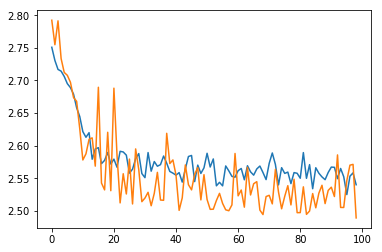

In [24]:
# plt.figure(figsize=(12,8))
plt.plot(train_losses_all[1:])
plt.plot(test_losses_all[1:])
plt.show()

In [19]:
train_losses_all

[2.9807219918318615,
 2.7546019501573453,
 2.7274094574094745,
 2.717880582433985,
 2.7117083602064227,
 2.7078466069979927,
 2.703227732500691,
 2.694804783317985,
 2.687584097554362,
 2.687612907529816,
 2.6619683693713094,
 2.643822609908937,
 2.622301148241899,
 2.6113827878095974,
 2.576392945717639,
 2.5895498651219166,
 2.561747584005041,
 2.5699481468501046,
 2.58121727019783,
 2.585134588827299,
 2.5969857028150187,
 2.577502250671387,
 2.5666711131418785,
 2.6021259217750363,
 2.5775277610838883,
 2.58494446221299,
 2.5606418384341727,
 2.573881464680348,
 2.566598171324243,
 2.560295891949511,
 2.5754901240191126,
 2.5906418762807766,
 2.583132354856476,
 2.572688626867581,
 2.558564240162766,
 2.545094323345996,
 2.5594917042048895,
 2.562498287891778,
 2.5739900048323507,
 2.5418207964559247,
 2.5734140230914746,
 2.564309609781101,
 2.5666790158729857,
 2.595911279813512,
 2.585430902195729,
 2.5570255940354705,
 2.578280747781589,
 2.5445553261464036,
 2.5690084247138563

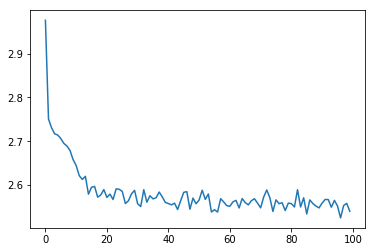

In [19]:
plt.plot(train_losses_all)

In [1]:
from entriesprocessor import EntriesProcessor
from trainer import Trainer
from model import Decoder, Encoder
import torch
from mockentries import generate_entries

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ep = EntriesProcessor(10,10)
entries = generate_entries(100000, 5)
ep.process(entries)
voc_size = ep.symbols_counter
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = Trainer(encoder,decoder,ep)

In [2]:
train_losses, test_losses = [],[]

In [4]:
train_losses, test_losses = trainer.train(10)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 1.264464 	 Time: 0s

	Train Loss: 1.456016 	 Time: 0s

	Train Loss: 1.363399 	 Time: 0s

	Train Loss: 1.485836 	 Time: 0s

	Train Loss: 1.551124 	 Time: 1s

	Train Loss: 1.542119 	 Time: 1s

	Train Loss: 1.578614 	 Time: 1s

	Train Loss: 1.604543 	 Time: 1s

	Train Loss: 1.560773 	 Time: 2s

	Train Loss: 1.555592 	 Time: 2s

	Train Loss: 1.576251 	 Time: 2s

	Train Loss: 1.570210 	 Time: 2s

	Train Loss: 1.564844 	 Time: 3s

	Train Loss: 1.560273 	 Time: 3s

	Train Loss: 1.537699 	 Time: 3s

	Train Loss: 1.552931 	 Time: 3s

	Train Loss: 1.559464 	 Time: 4s

	Train Loss: 1.556410 	 Time: 4s

	Train Loss: 1.567614 	 Time: 4s

	Train Loss: 1.564469 	 Time: 4s

	Train Loss: 1.574350 	 Time: 4s

	Train Loss: 1.571119 	 Time: 5s

	Train Loss: 1.556348 	 Time: 5s

	Train Loss: 1.576686 	 Time: 5s

	Train Loss: 1.584285 	 Time: 5s

	Train Loss: 1.580948 	 Time: 6s

	Train Loss: 1.578090 	 Time: 6s

	Train Loss: 1.575441 	 Time: 6s

	Train Loss: 1.572850 	 Time: 6s

	Train Loss: 1.561289 	 Time: 7s

	Train Loss: 1.559631 	 Time: 7s

	Train Loss: 1.566252 	 Time: 7s

	Train Loss: 1.564375 	 Time: 7s

	Train Loss: 1.570384 	 Time: 8s

	Train Loss: 1.568443 	 Time: 8s

	Train Loss: 1.566694 	 Time: 8s

	Train Loss: 1.572088 	 Time: 8s

	Train Loss: 1.577171 	 Time: 8s

	Train Loss: 1.581953 	 Time: 9s

	Train Loss: 1.573174 	 Time: 9s

	Train Loss: 1.571565 	 Time: 9s

	Train Loss: 1.576357 	 Time: 9s

	Train Loss: 1.586881 	 Time: 10s

	Train Loss: 1.590959 	 Time: 10s

	Train Loss: 1.589012 	 Time: 10s

	Train Loss: 1.587150 	 Time: 10s

	Train Loss: 1.590974 	 Time: 11s

	Train Loss: 1.583433 	 Time: 11s

	Train Loss: 1.581973 	 Time: 11s

	Train Loss: 1.585740 	 Time: 11s

	Train Loss: 1.594387 	 Time: 11s

	Train Loss: 1.597740 	 Time: 12s

	Train Loss: 1.600970 	 Time: 12s

	Train Loss: 1.604028 	 Time: 12s

	Train Loss: 1.606978 	 Time: 12s

	Train Loss: 1.605140 	 Time: 13s

	Train Loss: 1.607979 	 Time: 13s

	Train Loss: 1.601421 	 Time: 13s

	Train Loss: 1.608908 	 Time: 13s

	Train Loss: 1.607155 	 Time: 14s

	Train Loss: 1.605314 	 Time: 14s

	Train Loss: 1.603690 	 Time: 14s

	Train Loss: 1.602108 	 Time: 14s

	Train Loss: 1.604713 	 Time: 14s

	Train Loss: 1.607224 	 Time: 15s

	Train Loss: 1.609604 	 Time: 15s

	Train Loss: 1.611930 	 Time: 15s

	Train Loss: 1.610280 	 Time: 15s

	Train Loss: 1.608695 	 Time: 16s

	Train Loss: 1.607267 	 Time: 16s

	Train Loss: 1.609530 	 Time: 16s

	Train Loss: 1.611607 	 Time: 16s

	Train Loss: 1.606382 	 Time: 16s

	Train Loss: 1.605036 	 Time: 17s

	Train Loss: 1.607272 	 Time: 17s

	Train Loss: 1.609356 	 Time: 17s

	Train Loss: 1.607990 	 Time: 17s

	Train Loss: 1.606579 	 Time: 18s

	Train Loss: 1.601813 	 Time: 18s

	Train Loss: 1.603940 	 Time: 18s

	Train Loss: 1.602715 	 Time: 18s

	Train Loss: 1.604689 	 Time: 19s

	Train Loss: 1.600180 	 Time: 19s

	Train Loss: 1.599054 	 Time: 19s

	Train Loss: 1.601011 	 Time: 19s

	Train Loss: 1.602953 	 Time: 19s

	Train Loss: 1.601757 	 Time: 20s

	Train Loss: 1.603623 	 Time: 20s

	Train Loss: 1.602437 	 Time: 20s

	Train Loss: 1.601306 	 Time: 20s

	Train Loss: 1.603083 	 Time: 21s

	Train Loss: 1.604837 	 Time: 21s

	Train Loss: 1.603712 	 Time: 21s

	Train Loss: 1.605453 	 Time: 21s

	Train Loss: 1.609911 	 Time: 22s

	Train Loss: 1.614254 	 Time: 22s

	Train Loss: 1.610311 	 Time: 22s

	Train Loss: 1.609243 	 Time: 22s

	Train Loss: 1.608205 	 Time: 22s

	Train Loss: 1.607141 	 Time: 23s

	Train Loss: 1.608755 	 Time: 23s

	Train Loss: 1.605072 	 Time: 23s

	Train Loss: 1.604082 	 Time: 23s

	Train Loss: 1.603112 	 Time: 24s

	Train Loss: 1.602160 	 Time: 24s

	Train Loss: 1.601189 	 Time: 24s

	Train Loss: 1.600244 	 Time: 24s

	Train Loss: 1.601743 	 Time: 25s

	Train Loss: 1.600786 	 Time: 25s

	Train Loss: 1.602277 	 Time: 25s

	Train Loss: 1.601364 	 Time: 25s

	Train Loss: 1.602827 	 Time: 25s

	Train Loss: 1.604294 	 Time: 26s

	Train Loss: 1.603397 	 Time: 26s

	Train Loss: 1.602531 	 Time: 26s

	Train Loss: 1.601658 	 Time: 26s

	Train Loss: 1.605330 	 Time: 27s

	Train Loss: 1.608999 	 Time: 27s


	Test Loss: 1.266006 	 Time: 0s
	 Input: gacfe 	 Result: a 	 From train: 1
	 Input: eddaa 	 Result: a 	 From train: 1
	 Input: ddfgg 	 Result: a 	 From train: 1
	 Input: eegda 	 Result: a 	 From train: 1


	 Input: dcfce 	 Result: a 	 From train: 1
Epoch 2
	Train Loss: 2.043588 	 Time: 0s

	Train Loss: 2.033695 	 Time: 0s

	Train Loss: 1.936108 	 Time: 0s

	Train Loss: 1.961995 	 Time: 0s

	Train Loss: 1.922147 	 Time: 1s

	Train Loss: 1.802625 	 Time: 1s

	Train Loss: 1.758194 	 Time: 1s

	Train Loss: 1.724983 	 Time: 1s

	Train Loss: 1.699217 	 Time: 1s

	Train Loss: 1.678949 	 Time: 2s

	Train Loss: 1.687553 	 Time: 2s

	Train Loss: 1.671864 	 Time: 2s

	Train Loss: 1.678999 	 Time: 2s

	Train Loss: 1.685143 	 Time: 3s

	Train Loss: 1.690643 	 Time: 3s

	Train Loss: 1.695296 	 Time: 3s

	Train Loss: 1.683626 	 Time: 3s

	Train Loss: 1.658019 	 Time: 4s

	Train Loss: 1.649895 	 Time: 4s

	Train Loss: 1.669276 	 Time: 4s

	Train Loss: 1.673999 	 Time: 4s

	Train Loss: 1.690415 	 Time: 5s

	Train Loss: 1.687083 	 Time: 5s

	Train Loss: 1.679399 	 Time: 5s

	Train Loss: 1.693384 	 Time: 5s

	Train Loss: 1.696124 	 Time: 5s

	Train Loss: 1.708387 	 Time: 6s

	Train Loss: 1.710287 	 Time: 6s

	Train Loss: 1.712147 	 Time: 6s

	Train Loss: 1.713819 	 Time: 6s

	Train Loss: 1.715442 	 Time: 7s

	Train Loss: 1.708823 	 Time: 7s

	Train Loss: 1.694371 	 Time: 7s

	Train Loss: 1.696610 	 Time: 7s

	Train Loss: 1.690949 	 Time: 8s

	Train Loss: 1.692980 	 Time: 8s

	Train Loss: 1.687809 	 Time: 8s

	Train Loss: 1.675808 	 Time: 8s

	Train Loss: 1.664269 	 Time: 8s

	Train Loss: 1.667363 	 Time: 9s

	Train Loss: 1.669872 	 Time: 9s

	Train Loss: 1.672227 	 Time: 9s

	Train Loss: 1.662095 	 Time: 9s

	Train Loss: 1.658422 	 Time: 10s

	Train Loss: 1.654932 	 Time: 10s

	Train Loss: 1.657422 	 Time: 10s

	Train Loss: 1.659734 	 Time: 10s

	Train Loss: 1.667352 	 Time: 11s

	Train Loss: 1.663969 	 Time: 11s

	Train Loss: 1.665976 	 Time: 11s

	Train Loss: 1.667935 	 Time: 11s

	Train Loss: 1.669751 	 Time: 11s

	Train Loss: 1.671511 	 Time: 12s

	Train Loss: 1.678138 	 Time: 12s

	Train Loss: 1.679697 	 Time: 12s

	Train Loss: 1.681243 	 Time: 12s

	Train Loss: 1.687357 	 Time: 13s

	Train Loss: 1.684133 	 Time: 13s

	Train Loss: 1.676521 	 Time: 13s

	Train Loss: 1.678060 	 Time: 13s

	Train Loss: 1.679474 	 Time: 14s

	Train Loss: 1.676551 	 Time: 14s

	Train Loss: 1.673743 	 Time: 14s

	Train Loss: 1.679304 	 Time: 14s

	Train Loss: 1.680676 	 Time: 15s

	Train Loss: 1.679720 	 Time: 15s

	Train Loss: 1.684833 	 Time: 15s

	Train Loss: 1.689907 	 Time: 15s

	Train Loss: 1.691017 	 Time: 15s

	Train Loss: 1.695897 	 Time: 16s

	Train Loss: 1.696930 	 Time: 16s

	Train Loss: 1.697847 	 Time: 16s

	Train Loss: 1.698736 	 Time: 16s

	Train Loss: 1.703206 	 Time: 17s

	Train Loss: 1.704041 	 Time: 17s

	Train Loss: 1.708336 	 Time: 17s

	Train Loss: 1.705690 	 Time: 17s

	Train Loss: 1.706477 	 Time: 18s

	Train Loss: 1.707282 	 Time: 18s

	Train Loss: 1.704757 	 Time: 18s

	Train Loss: 1.705445 	 Time: 18s

	Train Loss: 1.699682 	 Time: 18s

	Train Loss: 1.700537 	 Time: 19s

	Train Loss: 1.704401 	 Time: 19s

	Train Loss: 1.701981 	 Time: 19s

	Train Loss: 1.699587 	 Time: 19s

	Train Loss: 1.703382 	 Time: 20s

	Train Loss: 1.701090 	 Time: 20s

	Train Loss: 1.695801 	 Time: 20s

	Train Loss: 1.699603 	 Time: 20s

	Train Loss: 1.703198 	 Time: 20s

	Train Loss: 1.703855 	 Time: 21s

	Train Loss: 1.704545 	 Time: 21s

	Train Loss: 1.707984 	 Time: 21s

	Train Loss: 1.705803 	 Time: 21s

	Train Loss: 1.706379 	 Time: 22s

	Train Loss: 1.706956 	 Time: 22s

	Train Loss: 1.707553 	 Time: 22s

	Train Loss: 1.705431 	 Time: 22s

	Train Loss: 1.706133 	 Time: 23s

	Train Loss: 1.706726 	 Time: 23s

	Train Loss: 1.704689 	 Time: 23s

	Train Loss: 1.705248 	 Time: 23s

	Train Loss: 1.705854 	 Time: 23s

	Train Loss: 1.708912 	 Time: 24s

	Train Loss: 1.709413 	 Time: 24s

	Train Loss: 1.707475 	 Time: 24s

	Train Loss: 1.703058 	 Time: 24s

	Train Loss: 1.706111 	 Time: 25s

	Train Loss: 1.704210 	 Time: 25s

	Train Loss: 1.707114 	 Time: 25s

	Train Loss: 1.705245 	 Time: 25s

	Train Loss: 1.708107 	 Time: 26s

	Train Loss: 1.709543 	 Time: 26s

	Train Loss: 1.707708 	 Time: 26s

	Train Loss: 1.708191 	 Time: 26s

	Train Loss: 1.713234 	 Time: 26s


	Test Loss: 1.261583 	 Time: 0s
	 Input: bcgbf 	 Result:  	 From train: 1
	 Input: ddbgf 	 Result:  	 From train: 1
	 Input: fgcfd 	 Result:  	 From train: 1
	 Input: cgdbd 	 Result:  	 From train: 1
	 Input: gddec 	 Result:  	 From train: 1
Epoch 3


	Train Loss: 1.249743 	 Time: 0s

	Train Loss: 1.643545 	 Time: 0s

	Train Loss: 1.598649 	 Time: 0s

	Train Loss: 1.640114 	 Time: 0s

	Train Loss: 1.665284 	 Time: 1s

	Train Loss: 1.681475 	 Time: 1s

	Train Loss: 1.655665 	 Time: 1s

	Train Loss: 1.669139 	 Time: 1s

	Train Loss: 1.650458 	 Time: 2s

	Train Loss: 1.661574 	 Time: 2s

	Train Loss: 1.670826 	 Time: 2s

	Train Loss: 1.678261 	 Time: 2s

	Train Loss: 1.705231 	 Time: 2s

	Train Loss: 1.690708 	 Time: 3s

	Train Loss: 1.677839 	 Time: 3s

	Train Loss: 1.666996 	 Time: 3s

	Train Loss: 1.657203 	 Time: 3s

	Train Loss: 1.678112 	 Time: 4s

	Train Loss: 1.668524 	 Time: 4s

	Train Loss: 1.660298 	 Time: 4s

	Train Loss: 1.677772 	 Time: 4s

	Train Loss: 1.669677 	 Time: 5s

	Train Loss: 1.673861 	 Time: 5s

	Train Loss: 1.677611 	 Time: 5s

	Train Loss: 1.681038 	 Time: 5s

	Train Loss: 1.663818 	 Time: 6s

	Train Loss: 1.667763 	 Time: 6s

	Train Loss: 1.680665 	 Time: 6s

	Train Loss: 1.683543 	 Time: 6s

	Train Loss: 1.673556 	 Time: 6s

	Train Loss: 1.676575 	 Time: 7s

	Train Loss: 1.679141 	 Time: 7s

	Train Loss: 1.689893 	 Time: 7s

	Train Loss: 1.684272 	 Time: 7s

	Train Loss: 1.694107 	 Time: 8s

	Train Loss: 1.688584 	 Time: 8s

	Train Loss: 1.690636 	 Time: 8s

	Train Loss: 1.692599 	 Time: 8s

	Train Loss: 1.687707 	 Time: 9s

	Train Loss: 1.689673 	 Time: 9s

	Train Loss: 1.691550 	 Time: 9s

	Train Loss: 1.687001 	 Time: 9s

	Train Loss: 1.682635 	 Time: 10s

	Train Loss: 1.678425 	 Time: 10s

	Train Loss: 1.674382 	 Time: 10s

	Train Loss: 1.670691 	 Time: 10s

	Train Loss: 1.661204 	 Time: 11s

	Train Loss: 1.657911 	 Time: 11s

	Train Loss: 1.665461 	 Time: 11s

	Train Loss: 1.667380 	 Time: 11s

	Train Loss: 1.669318 	 Time: 12s

	Train Loss: 1.666021 	 Time: 12s

	Train Loss: 1.672835 	 Time: 12s

	Train Loss: 1.674453 	 Time: 12s

	Train Loss: 1.671163 	 Time: 12s

	Train Loss: 1.668083 	 Time: 13s

	Train Loss: 1.669827 	 Time: 13s

	Train Loss: 1.666992 	 Time: 13s

	Train Loss: 1.673128 	 Time: 13s

	Train Loss: 1.674650 	 Time: 14s

	Train Loss: 1.676082 	 Time: 14s

	Train Loss: 1.673221 	 Time: 14s

	Train Loss: 1.666179 	 Time: 14s

	Train Loss: 1.663575 	 Time: 14s

	Train Loss: 1.661012 	 Time: 15s

	Train Loss: 1.658502 	 Time: 15s

	Train Loss: 1.660074 	 Time: 15s

	Train Loss: 1.653710 	 Time: 15s

	Train Loss: 1.651446 	 Time: 16s

	Train Loss: 1.653088 	 Time: 16s

	Train Loss: 1.654719 	 Time: 16s

	Train Loss: 1.656214 	 Time: 16s

	Train Loss: 1.657724 	 Time: 17s

	Train Loss: 1.659076 	 Time: 17s

	Train Loss: 1.656928 	 Time: 17s

	Train Loss: 1.658302 	 Time: 17s

	Train Loss: 1.659695 	 Time: 18s

	Train Loss: 1.654167 	 Time: 18s

	Train Loss: 1.655680 	 Time: 18s

	Train Loss: 1.650332 	 Time: 18s

	Train Loss: 1.651776 	 Time: 18s

	Train Loss: 1.653151 	 Time: 19s

	Train Loss: 1.654457 	 Time: 19s

	Train Loss: 1.658896 	 Time: 19s

	Train Loss: 1.653848 	 Time: 19s

	Train Loss: 1.652050 	 Time: 20s

	Train Loss: 1.650305 	 Time: 20s

	Train Loss: 1.651610 	 Time: 20s

	Train Loss: 1.652918 	 Time: 20s

	Train Loss: 1.651191 	 Time: 20s

	Train Loss: 1.649494 	 Time: 21s

	Train Loss: 1.650711 	 Time: 21s

	Train Loss: 1.649064 	 Time: 21s

	Train Loss: 1.653071 	 Time: 21s

	Train Loss: 1.654251 	 Time: 22s

	Train Loss: 1.651135 	 Time: 22s

	Train Loss: 1.652385 	 Time: 22s

	Train Loss: 1.650799 	 Time: 22s

	Train Loss: 1.649210 	 Time: 23s

	Train Loss: 1.647704 	 Time: 23s

	Train Loss: 1.646236 	 Time: 23s

	Train Loss: 1.647382 	 Time: 23s

	Train Loss: 1.645907 	 Time: 23s

	Train Loss: 1.644450 	 Time: 24s

	Train Loss: 1.643067 	 Time: 24s

	Train Loss: 1.646709 	 Time: 24s

	Train Loss: 1.645310 	 Time: 24s

	Train Loss: 1.646399 	 Time: 25s

	Train Loss: 1.644991 	 Time: 25s

	Train Loss: 1.648488 	 Time: 25s

	Train Loss: 1.647111 	 Time: 25s

	Train Loss: 1.645787 	 Time: 26s

	Train Loss: 1.644499 	 Time: 26s

	Train Loss: 1.640813 	 Time: 26s

	Train Loss: 1.639682 	 Time: 26s

	Train Loss: 1.636160 	 Time: 26s

	Train Loss: 1.634986 	 Time: 27s

	Train Loss: 1.639411 	 Time: 27s


	Test Loss: 1.263504 	 Time: 0s
	 Input: fbebe 	 Result:  	 From train: 1
	 Input: aagca 	 Result:  	 From train: 1
	 Input: adabe 	 Result:  	 From train: 1
	 Input: gacgf 	 Result:  	 From train: 1
	 Input: gfebb 	 Result:  	 From train: 1
Epoch 4


	Train Loss: 1.516177 	 Time: 0s

	Train Loss: 1.510968 	 Time: 0s

	Train Loss: 1.596348 	 Time: 0s

	Train Loss: 1.572694 	 Time: 0s

	Train Loss: 1.664060 	 Time: 1s

	Train Loss: 1.724624 	 Time: 1s

	Train Loss: 1.693114 	 Time: 1s

	Train Loss: 1.735338 	 Time: 1s

	Train Loss: 1.709262 	 Time: 2s

	Train Loss: 1.741056 	 Time: 2s

	Train Loss: 1.743111 	 Time: 2s

	Train Loss: 1.744742 	 Time: 2s

	Train Loss: 1.705549 	 Time: 2s

	Train Loss: 1.671539 	 Time: 3s

	Train Loss: 1.679144 	 Time: 3s

	Train Loss: 1.667924 	 Time: 3s

	Train Loss: 1.689153 	 Time: 3s

	Train Loss: 1.693238 	 Time: 4s

	Train Loss: 1.697015 	 Time: 4s

	Train Loss: 1.713476 	 Time: 4s

	Train Loss: 1.728342 	 Time: 4s

	Train Loss: 1.741640 	 Time: 5s

	Train Loss: 1.753973 	 Time: 5s

	Train Loss: 1.754503 	 Time: 5s

	Train Loss: 1.733645 	 Time: 5s

	Train Loss: 1.724538 	 Time: 5s

	Train Loss: 1.716008 	 Time: 6s

	Train Loss: 1.708337 	 Time: 6s

	Train Loss: 1.691736 	 Time: 6s

	Train Loss: 1.676140 	 Time: 6s

	Train Loss: 1.687969 	 Time: 7s

	Train Loss: 1.690431 	 Time: 7s

	Train Loss: 1.684605 	 Time: 7s

	Train Loss: 1.694640 	 Time: 7s

	Train Loss: 1.689003 	 Time: 8s

	Train Loss: 1.698412 	 Time: 8s

	Train Loss: 1.700076 	 Time: 8s

	Train Loss: 1.694692 	 Time: 8s

	Train Loss: 1.699393 	 Time: 9s

	Train Loss: 1.700960 	 Time: 9s

	Train Loss: 1.702423 	 Time: 9s

	Train Loss: 1.697704 	 Time: 9s

	Train Loss: 1.693142 	 Time: 9s

	Train Loss: 1.688752 	 Time: 10s

	Train Loss: 1.684564 	 Time: 10s

	Train Loss: 1.680499 	 Time: 10s

	Train Loss: 1.687762 	 Time: 10s

	Train Loss: 1.689330 	 Time: 11s

	Train Loss: 1.690844 	 Time: 11s

	Train Loss: 1.692298 	 Time: 11s

	Train Loss: 1.693601 	 Time: 11s

	Train Loss: 1.700028 	 Time: 11s

	Train Loss: 1.696264 	 Time: 12s

	Train Loss: 1.697530 	 Time: 12s

	Train Loss: 1.698798 	 Time: 12s

	Train Loss: 1.700047 	 Time: 12s

	Train Loss: 1.691862 	 Time: 13s

	Train Loss: 1.697637 	 Time: 13s

	Train Loss: 1.694223 	 Time: 13s

	Train Loss: 1.695423 	 Time: 13s

	Train Loss: 1.696582 	 Time: 14s

	Train Loss: 1.701887 	 Time: 14s

	Train Loss: 1.702863 	 Time: 14s

	Train Loss: 1.707878 	 Time: 14s

	Train Loss: 1.712773 	 Time: 15s

	Train Loss: 1.713528 	 Time: 15s

	Train Loss: 1.718178 	 Time: 15s

	Train Loss: 1.722666 	 Time: 15s

	Train Loss: 1.715565 	 Time: 15s

	Train Loss: 1.712534 	 Time: 16s

	Train Loss: 1.713251 	 Time: 16s

	Train Loss: 1.710284 	 Time: 16s

	Train Loss: 1.711020 	 Time: 16s

	Train Loss: 1.708111 	 Time: 17s

	Train Loss: 1.705332 	 Time: 17s

	Train Loss: 1.699081 	 Time: 17s

	Train Loss: 1.696621 	 Time: 17s

	Train Loss: 1.694084 	 Time: 17s

	Train Loss: 1.698286 	 Time: 18s

	Train Loss: 1.699089 	 Time: 18s

	Train Loss: 1.693335 	 Time: 18s

	Train Loss: 1.690983 	 Time: 18s

	Train Loss: 1.690106 	 Time: 19s

	Train Loss: 1.694063 	 Time: 19s

	Train Loss: 1.688656 	 Time: 19s

	Train Loss: 1.686505 	 Time: 19s

	Train Loss: 1.687364 	 Time: 20s

	Train Loss: 1.685231 	 Time: 20s

	Train Loss: 1.683091 	 Time: 20s

	Train Loss: 1.684005 	 Time: 20s

	Train Loss: 1.681955 	 Time: 20s

	Train Loss: 1.679992 	 Time: 21s

	Train Loss: 1.680845 	 Time: 21s

	Train Loss: 1.678930 	 Time: 21s

	Train Loss: 1.679858 	 Time: 21s

	Train Loss: 1.675188 	 Time: 22s

	Train Loss: 1.678894 	 Time: 22s

	Train Loss: 1.682427 	 Time: 22s

	Train Loss: 1.680595 	 Time: 22s

	Train Loss: 1.678812 	 Time: 23s

	Train Loss: 1.674363 	 Time: 23s

	Train Loss: 1.672698 	 Time: 23s

	Train Loss: 1.673561 	 Time: 23s

	Train Loss: 1.674409 	 Time: 23s

	Train Loss: 1.672711 	 Time: 24s

	Train Loss: 1.671031 	 Time: 24s

	Train Loss: 1.671900 	 Time: 24s

	Train Loss: 1.670311 	 Time: 24s

	Train Loss: 1.671148 	 Time: 25s

	Train Loss: 1.669605 	 Time: 25s

	Train Loss: 1.670441 	 Time: 25s

	Train Loss: 1.671301 	 Time: 25s

	Train Loss: 1.672081 	 Time: 26s

	Train Loss: 1.675182 	 Time: 26s

	Train Loss: 1.673644 	 Time: 26s

	Train Loss: 1.674374 	 Time: 26s

	Train Loss: 1.676406 	 Time: 26s


	Test Loss: 1.230810 	 Time: 0s
	 Input: fdcbc 	 Result:  	 From train: 1
	 Input: afgfa 	 Result:  	 From train: 0
	 Input: eeeeg 	 Result:  	 From train: 1
	 Input: acafe 	 Result:  	 From train: 1
	 Input: cadef 	 Result:  	 From train: 1
Epoch 5


	Train Loss: 1.765376 	 Time: 0s

	Train Loss: 1.632785 	 Time: 0s

	Train Loss: 1.497084 	 Time: 0s

	Train Loss: 1.499073 	 Time: 0s

	Train Loss: 1.604720 	 Time: 1s

	Train Loss: 1.586833 	 Time: 1s

	Train Loss: 1.535420 	 Time: 1s

	Train Loss: 1.564371 	 Time: 1s

	Train Loss: 1.615158 	 Time: 2s

	Train Loss: 1.630590 	 Time: 2s

	Train Loss: 1.618900 	 Time: 2s

	Train Loss: 1.608708 	 Time: 2s

	Train Loss: 1.579430 	 Time: 2s

	Train Loss: 1.592659 	 Time: 3s

	Train Loss: 1.604186 	 Time: 3s

	Train Loss: 1.614222 	 Time: 3s

	Train Loss: 1.607411 	 Time: 3s

	Train Loss: 1.586407 	 Time: 4s

	Train Loss: 1.582141 	 Time: 4s

	Train Loss: 1.604596 	 Time: 4s

	Train Loss: 1.599549 	 Time: 4s

	Train Loss: 1.594815 	 Time: 5s

	Train Loss: 1.602247 	 Time: 5s

	Train Loss: 1.597800 	 Time: 5s

	Train Loss: 1.604376 	 Time: 5s

	Train Loss: 1.610395 	 Time: 5s

	Train Loss: 1.606211 	 Time: 6s

	Train Loss: 1.611939 	 Time: 6s

	Train Loss: 1.617122 	 Time: 6s

	Train Loss: 1.621932 	 Time: 6s

	Train Loss: 1.617855 	 Time: 7s

	Train Loss: 1.605651 	 Time: 7s

	Train Loss: 1.603017 	 Time: 7s

	Train Loss: 1.592379 	 Time: 7s

	Train Loss: 1.581916 	 Time: 7s

	Train Loss: 1.587022 	 Time: 8s

	Train Loss: 1.598983 	 Time: 8s

	Train Loss: 1.610245 	 Time: 8s

	Train Loss: 1.614176 	 Time: 8s

	Train Loss: 1.611177 	 Time: 9s

	Train Loss: 1.614890 	 Time: 9s

	Train Loss: 1.612086 	 Time: 9s

	Train Loss: 1.615542 	 Time: 9s

	Train Loss: 1.612849 	 Time: 10s

	Train Loss: 1.610295 	 Time: 10s

	Train Loss: 1.613505 	 Time: 10s

	Train Loss: 1.622284 	 Time: 10s

	Train Loss: 1.619630 	 Time: 10s

	Train Loss: 1.622476 	 Time: 11s

	Train Loss: 1.625298 	 Time: 11s

	Train Loss: 1.622774 	 Time: 11s

	Train Loss: 1.615177 	 Time: 11s

	Train Loss: 1.612970 	 Time: 12s

	Train Loss: 1.610832 	 Time: 12s

	Train Loss: 1.608699 	 Time: 12s

	Train Loss: 1.611414 	 Time: 12s

	Train Loss: 1.609365 	 Time: 12s

	Train Loss: 1.612047 	 Time: 13s

	Train Loss: 1.610124 	 Time: 13s

	Train Loss: 1.603693 	 Time: 13s

	Train Loss: 1.606371 	 Time: 13s

	Train Loss: 1.608917 	 Time: 14s

	Train Loss: 1.607120 	 Time: 14s

	Train Loss: 1.609580 	 Time: 14s

	Train Loss: 1.615981 	 Time: 14s

	Train Loss: 1.614178 	 Time: 15s

	Train Loss: 1.612418 	 Time: 15s

	Train Loss: 1.610714 	 Time: 15s

	Train Loss: 1.612905 	 Time: 15s

	Train Loss: 1.611253 	 Time: 15s

	Train Loss: 1.609602 	 Time: 16s

	Train Loss: 1.611759 	 Time: 16s

	Train Loss: 1.613841 	 Time: 16s

	Train Loss: 1.615822 	 Time: 16s

	Train Loss: 1.617829 	 Time: 17s

	Train Loss: 1.616298 	 Time: 17s

	Train Loss: 1.618190 	 Time: 17s

	Train Loss: 1.613153 	 Time: 17s

	Train Loss: 1.615174 	 Time: 17s

	Train Loss: 1.610346 	 Time: 18s

	Train Loss: 1.612288 	 Time: 18s

	Train Loss: 1.614117 	 Time: 18s

	Train Loss: 1.612693 	 Time: 18s

	Train Loss: 1.611249 	 Time: 19s

	Train Loss: 1.613011 	 Time: 19s

	Train Loss: 1.611638 	 Time: 19s

	Train Loss: 1.610299 	 Time: 19s

	Train Loss: 1.605924 	 Time: 20s

	Train Loss: 1.601612 	 Time: 20s

	Train Loss: 1.600654 	 Time: 20s

	Train Loss: 1.599504 	 Time: 20s

	Train Loss: 1.601341 	 Time: 20s

	Train Loss: 1.603102 	 Time: 21s

	Train Loss: 1.601960 	 Time: 21s

	Train Loss: 1.603649 	 Time: 21s

	Train Loss: 1.605291 	 Time: 21s

	Train Loss: 1.606956 	 Time: 22s

	Train Loss: 1.607236 	 Time: 22s

	Train Loss: 1.608798 	 Time: 22s

	Train Loss: 1.612962 	 Time: 22s

	Train Loss: 1.611799 	 Time: 23s

	Train Loss: 1.613274 	 Time: 23s

	Train Loss: 1.609530 	 Time: 23s

	Train Loss: 1.611009 	 Time: 23s

	Train Loss: 1.612444 	 Time: 23s

	Train Loss: 1.613876 	 Time: 24s

	Train Loss: 1.615282 	 Time: 24s

	Train Loss: 1.616667 	 Time: 24s

	Train Loss: 1.618012 	 Time: 24s

	Train Loss: 1.619343 	 Time: 25s

	Train Loss: 1.620605 	 Time: 25s

	Train Loss: 1.621840 	 Time: 25s

	Train Loss: 1.625488 	 Time: 25s

	Train Loss: 1.629000 	 Time: 26s

	Train Loss: 1.627887 	 Time: 26s

	Train Loss: 1.629026 	 Time: 26s

	Train Loss: 1.627877 	 Time: 26s


	Test Loss: 1.229374 	 Time: 0s
	 Input: cedgg 	 Result:  	 From train: 1
	 Input: bdebb 	 Result:  	 From train: 1
	 Input: gbdcc 	 Result:  	 From train: 1
	 Input: defed 	 Result:  	 From train: 1
	 Input: baage 	 Result:  	 From train: 0
Epoch 6


	Train Loss: 1.492259 	 Time: 0s

	Train Loss: 1.760169 	 Time: 0s

	Train Loss: 1.582411 	 Time: 0s

	Train Loss: 1.628145 	 Time: 0s

	Train Loss: 1.600970 	 Time: 1s

	Train Loss: 1.584275 	 Time: 1s

	Train Loss: 1.571520 	 Time: 1s

	Train Loss: 1.562543 	 Time: 1s

	Train Loss: 1.585344 	 Time: 2s

	Train Loss: 1.549956 	 Time: 2s

	Train Loss: 1.569518 	 Time: 2s

	Train Loss: 1.563288 	 Time: 2s

	Train Loss: 1.578780 	 Time: 2s

	Train Loss: 1.572649 	 Time: 3s

	Train Loss: 1.585220 	 Time: 3s

	Train Loss: 1.579612 	 Time: 3s

	Train Loss: 1.590366 	 Time: 3s

	Train Loss: 1.585100 	 Time: 4s

	Train Loss: 1.580551 	 Time: 4s

	Train Loss: 1.562732 	 Time: 4s

	Train Loss: 1.559602 	 Time: 4s

	Train Loss: 1.568791 	 Time: 5s

	Train Loss: 1.565555 	 Time: 5s

	Train Loss: 1.551282 	 Time: 5s

	Train Loss: 1.549369 	 Time: 5s

	Train Loss: 1.547290 	 Time: 5s

	Train Loss: 1.545470 	 Time: 6s

	Train Loss: 1.562882 	 Time: 6s

	Train Loss: 1.551350 	 Time: 6s

	Train Loss: 1.558400 	 Time: 6s

	Train Loss: 1.556358 	 Time: 7s

	Train Loss: 1.545984 	 Time: 7s

	Train Loss: 1.544545 	 Time: 7s

	Train Loss: 1.535222 	 Time: 7s

	Train Loss: 1.541969 	 Time: 8s

	Train Loss: 1.540723 	 Time: 8s

	Train Loss: 1.536698 	 Time: 8s

	Train Loss: 1.535592 	 Time: 8s

	Train Loss: 1.541414 	 Time: 9s

	Train Loss: 1.540276 	 Time: 9s

	Train Loss: 1.545771 	 Time: 9s

	Train Loss: 1.557098 	 Time: 9s

	Train Loss: 1.561872 	 Time: 9s

	Train Loss: 1.560309 	 Time: 10s

	Train Loss: 1.558908 	 Time: 10s

	Train Loss: 1.563284 	 Time: 10s

	Train Loss: 1.556153 	 Time: 10s

	Train Loss: 1.565999 	 Time: 11s

	Train Loss: 1.559127 	 Time: 11s

	Train Loss: 1.557906 	 Time: 11s

	Train Loss: 1.561938 	 Time: 11s

	Train Loss: 1.565754 	 Time: 11s

	Train Loss: 1.569459 	 Time: 12s

	Train Loss: 1.577809 	 Time: 12s

	Train Loss: 1.581085 	 Time: 12s

	Train Loss: 1.584247 	 Time: 12s

	Train Loss: 1.587359 	 Time: 13s

	Train Loss: 1.585785 	 Time: 13s

	Train Loss: 1.579760 	 Time: 13s

	Train Loss: 1.580844 	 Time: 13s

	Train Loss: 1.579543 	 Time: 14s

	Train Loss: 1.573912 	 Time: 14s

	Train Loss: 1.576872 	 Time: 14s

	Train Loss: 1.583825 	 Time: 14s

	Train Loss: 1.582486 	 Time: 14s

	Train Loss: 1.581194 	 Time: 15s

	Train Loss: 1.579915 	 Time: 15s

	Train Loss: 1.578675 	 Time: 15s

	Train Loss: 1.577479 	 Time: 15s

	Train Loss: 1.576329 	 Time: 16s

	Train Loss: 1.578880 	 Time: 16s

	Train Loss: 1.574011 	 Time: 16s

	Train Loss: 1.576652 	 Time: 16s

	Train Loss: 1.579170 	 Time: 17s

	Train Loss: 1.578077 	 Time: 17s

	Train Loss: 1.580464 	 Time: 17s

	Train Loss: 1.579339 	 Time: 17s

	Train Loss: 1.578307 	 Time: 17s

	Train Loss: 1.577228 	 Time: 18s

	Train Loss: 1.582846 	 Time: 18s

	Train Loss: 1.585005 	 Time: 18s

	Train Loss: 1.587180 	 Time: 18s

	Train Loss: 1.589290 	 Time: 19s

	Train Loss: 1.591287 	 Time: 19s

	Train Loss: 1.593254 	 Time: 19s

	Train Loss: 1.598322 	 Time: 19s

	Train Loss: 1.597157 	 Time: 20s

	Train Loss: 1.595965 	 Time: 20s

	Train Loss: 1.591810 	 Time: 20s

	Train Loss: 1.590837 	 Time: 20s

	Train Loss: 1.592730 	 Time: 20s

	Train Loss: 1.594577 	 Time: 21s

	Train Loss: 1.592197 	 Time: 21s

	Train Loss: 1.594023 	 Time: 21s

	Train Loss: 1.592998 	 Time: 21s

	Train Loss: 1.597471 	 Time: 22s

	Train Loss: 1.596453 	 Time: 22s

	Train Loss: 1.598106 	 Time: 22s

	Train Loss: 1.599724 	 Time: 22s

	Train Loss: 1.603967 	 Time: 23s

	Train Loss: 1.605497 	 Time: 23s

	Train Loss: 1.605836 	 Time: 23s

	Train Loss: 1.609893 	 Time: 23s

	Train Loss: 1.611353 	 Time: 24s

	Train Loss: 1.615272 	 Time: 24s

	Train Loss: 1.614151 	 Time: 24s

	Train Loss: 1.613081 	 Time: 24s

	Train Loss: 1.612005 	 Time: 24s

	Train Loss: 1.610954 	 Time: 25s

	Train Loss: 1.609896 	 Time: 25s

	Train Loss: 1.608898 	 Time: 25s

	Train Loss: 1.605531 	 Time: 25s

	Train Loss: 1.609220 	 Time: 26s

	Train Loss: 1.610530 	 Time: 26s

	Train Loss: 1.611850 	 Time: 26s

	Train Loss: 1.615366 	 Time: 26s


	Test Loss: 1.229437 	 Time: 0s
	 Input: gfabe 	 Result:  	 From train: 1
	 Input: aagea 	 Result:  	 From train: 0
	 Input: bcdca 	 Result:  	 From train: 0
	 Input: ddcge 	 Result:  	 From train: 1
	 Input: fddag 	 Result:  	 From train: 1
Epoch 7


	Train Loss: 1.757897 	 Time: 0s

	Train Loss: 1.760550 	 Time: 0s

	Train Loss: 1.672184 	 Time: 0s

	Train Loss: 1.560808 	 Time: 0s

	Train Loss: 1.600715 	 Time: 1s

	Train Loss: 1.582998 	 Time: 1s

	Train Loss: 1.570738 	 Time: 1s

	Train Loss: 1.560817 	 Time: 1s

	Train Loss: 1.612484 	 Time: 2s

	Train Loss: 1.601049 	 Time: 2s

	Train Loss: 1.566735 	 Time: 2s

	Train Loss: 1.583464 	 Time: 2s

	Train Loss: 1.596988 	 Time: 2s

	Train Loss: 1.608608 	 Time: 3s

	Train Loss: 1.618856 	 Time: 3s

	Train Loss: 1.594364 	 Time: 3s

	Train Loss: 1.604449 	 Time: 3s

	Train Loss: 1.583262 	 Time: 4s

	Train Loss: 1.578935 	 Time: 4s

	Train Loss: 1.588066 	 Time: 4s

	Train Loss: 1.583466 	 Time: 4s

	Train Loss: 1.591563 	 Time: 5s

	Train Loss: 1.587374 	 Time: 5s

	Train Loss: 1.594583 	 Time: 5s

	Train Loss: 1.601285 	 Time: 5s

	Train Loss: 1.607489 	 Time: 5s

	Train Loss: 1.603253 	 Time: 6s

	Train Loss: 1.599471 	 Time: 6s

	Train Loss: 1.605150 	 Time: 6s

	Train Loss: 1.606070 	 Time: 6s

	Train Loss: 1.610957 	 Time: 7s

	Train Loss: 1.607316 	 Time: 7s

	Train Loss: 1.603994 	 Time: 7s

	Train Loss: 1.608605 	 Time: 7s

	Train Loss: 1.605444 	 Time: 8s

	Train Loss: 1.594932 	 Time: 8s

	Train Loss: 1.606763 	 Time: 8s

	Train Loss: 1.610778 	 Time: 8s

	Train Loss: 1.621388 	 Time: 9s

	Train Loss: 1.624950 	 Time: 9s

	Train Loss: 1.621859 	 Time: 9s

	Train Loss: 1.618836 	 Time: 9s

	Train Loss: 1.622148 	 Time: 10s

	Train Loss: 1.619262 	 Time: 10s

	Train Loss: 1.616476 	 Time: 10s

	Train Loss: 1.613836 	 Time: 10s

	Train Loss: 1.611342 	 Time: 10s

	Train Loss: 1.608845 	 Time: 11s

	Train Loss: 1.606622 	 Time: 11s

	Train Loss: 1.599005 	 Time: 11s

	Train Loss: 1.602261 	 Time: 11s

	Train Loss: 1.605340 	 Time: 12s

	Train Loss: 1.598194 	 Time: 12s

	Train Loss: 1.591264 	 Time: 12s

	Train Loss: 1.589723 	 Time: 12s

	Train Loss: 1.597609 	 Time: 13s

	Train Loss: 1.595990 	 Time: 13s

	Train Loss: 1.592160 	 Time: 13s

	Train Loss: 1.594986 	 Time: 13s

	Train Loss: 1.597732 	 Time: 14s

	Train Loss: 1.596107 	 Time: 14s

	Train Loss: 1.594476 	 Time: 14s

	Train Loss: 1.597129 	 Time: 14s

	Train Loss: 1.595570 	 Time: 15s

	Train Loss: 1.598141 	 Time: 15s

	Train Loss: 1.596568 	 Time: 15s

	Train Loss: 1.601155 	 Time: 15s

	Train Loss: 1.599613 	 Time: 15s

	Train Loss: 1.600142 	 Time: 16s

	Train Loss: 1.598380 	 Time: 16s

	Train Loss: 1.593134 	 Time: 16s

	Train Loss: 1.591845 	 Time: 16s

	Train Loss: 1.597758 	 Time: 17s

	Train Loss: 1.599955 	 Time: 17s

	Train Loss: 1.603989 	 Time: 17s

	Train Loss: 1.602593 	 Time: 17s

	Train Loss: 1.601233 	 Time: 18s

	Train Loss: 1.599897 	 Time: 18s

	Train Loss: 1.605297 	 Time: 18s

	Train Loss: 1.603942 	 Time: 18s

	Train Loss: 1.602614 	 Time: 18s

	Train Loss: 1.602796 	 Time: 19s

	Train Loss: 1.604711 	 Time: 19s

	Train Loss: 1.609690 	 Time: 19s

	Train Loss: 1.611489 	 Time: 19s

	Train Loss: 1.613181 	 Time: 20s

	Train Loss: 1.611841 	 Time: 20s

	Train Loss: 1.613523 	 Time: 20s

	Train Loss: 1.612185 	 Time: 20s

	Train Loss: 1.610886 	 Time: 20s

	Train Loss: 1.609622 	 Time: 21s

	Train Loss: 1.611277 	 Time: 21s

	Train Loss: 1.612863 	 Time: 21s

	Train Loss: 1.614438 	 Time: 21s

	Train Loss: 1.615986 	 Time: 22s

	Train Loss: 1.617479 	 Time: 22s

	Train Loss: 1.616246 	 Time: 22s

	Train Loss: 1.617741 	 Time: 22s

	Train Loss: 1.619192 	 Time: 23s

	Train Loss: 1.620624 	 Time: 23s

	Train Loss: 1.619406 	 Time: 23s

	Train Loss: 1.620759 	 Time: 23s

	Train Loss: 1.622119 	 Time: 24s

	Train Loss: 1.620909 	 Time: 24s

	Train Loss: 1.622223 	 Time: 24s

	Train Loss: 1.620998 	 Time: 24s

	Train Loss: 1.619794 	 Time: 24s

	Train Loss: 1.618670 	 Time: 25s

	Train Loss: 1.617534 	 Time: 25s

	Train Loss: 1.616422 	 Time: 25s

	Train Loss: 1.615330 	 Time: 25s

	Train Loss: 1.614246 	 Time: 26s

	Train Loss: 1.615538 	 Time: 26s

	Train Loss: 1.612119 	 Time: 26s

	Train Loss: 1.615773 	 Time: 26s

	Train Loss: 1.619276 	 Time: 26s

	Train Loss: 1.623147 	 Time: 27s


	Test Loss: 1.249223 	 Time: 0s
	 Input: dgdaa 	 Result:  	 From train: 1
	 Input: bcdff 	 Result:  	 From train: 1
	 Input: afdcd 	 Result:  	 From train: 0
	 Input: bafgb 	 Result:  	 From train: 1
	 Input: afddc 	 Result:  	 From train: 1
Epoch 8


	Train Loss: 1.507148 	 Time: 0s

	Train Loss: 1.369146 	 Time: 0s

	Train Loss: 1.501505 	 Time: 0s

	Train Loss: 1.432887 	 Time: 0s

	Train Loss: 1.446487 	 Time: 1s

	Train Loss: 1.499779 	 Time: 1s

	Train Loss: 1.537187 	 Time: 1s

	Train Loss: 1.565098 	 Time: 1s

	Train Loss: 1.527418 	 Time: 2s

	Train Loss: 1.577761 	 Time: 2s

	Train Loss: 1.570392 	 Time: 2s

	Train Loss: 1.564145 	 Time: 2s

	Train Loss: 1.558751 	 Time: 3s

	Train Loss: 1.554312 	 Time: 3s

	Train Loss: 1.532158 	 Time: 3s

	Train Loss: 1.530235 	 Time: 3s

	Train Loss: 1.543733 	 Time: 4s

	Train Loss: 1.541059 	 Time: 4s

	Train Loss: 1.538782 	 Time: 4s

	Train Loss: 1.523167 	 Time: 4s

	Train Loss: 1.534760 	 Time: 4s

	Train Loss: 1.545141 	 Time: 5s

	Train Loss: 1.531101 	 Time: 5s

	Train Loss: 1.529576 	 Time: 5s

	Train Loss: 1.538941 	 Time: 5s

	Train Loss: 1.547654 	 Time: 6s

	Train Loss: 1.555691 	 Time: 6s

	Train Loss: 1.553450 	 Time: 6s

	Train Loss: 1.560685 	 Time: 6s

	Train Loss: 1.558574 	 Time: 7s

	Train Loss: 1.573765 	 Time: 7s

	Train Loss: 1.588010 	 Time: 7s

	Train Loss: 1.593408 	 Time: 7s

	Train Loss: 1.598317 	 Time: 7s

	Train Loss: 1.595356 	 Time: 8s

	Train Loss: 1.592649 	 Time: 8s

	Train Loss: 1.597226 	 Time: 8s

	Train Loss: 1.587451 	 Time: 8s

	Train Loss: 1.585156 	 Time: 9s

	Train Loss: 1.582807 	 Time: 9s

	Train Loss: 1.580672 	 Time: 9s

	Train Loss: 1.578708 	 Time: 9s

	Train Loss: 1.576715 	 Time: 10s

	Train Loss: 1.568737 	 Time: 10s

	Train Loss: 1.567263 	 Time: 10s

	Train Loss: 1.577308 	 Time: 10s

	Train Loss: 1.581126 	 Time: 10s

	Train Loss: 1.579356 	 Time: 11s

	Train Loss: 1.577684 	 Time: 11s

	Train Loss: 1.584372 	 Time: 11s

	Train Loss: 1.582584 	 Time: 11s

	Train Loss: 1.580848 	 Time: 12s

	Train Loss: 1.584300 	 Time: 12s

	Train Loss: 1.587665 	 Time: 12s

	Train Loss: 1.595602 	 Time: 12s

	Train Loss: 1.598532 	 Time: 13s

	Train Loss: 1.606054 	 Time: 13s

	Train Loss: 1.604086 	 Time: 13s

	Train Loss: 1.611141 	 Time: 13s

	Train Loss: 1.617997 	 Time: 14s

	Train Loss: 1.616007 	 Time: 14s

	Train Loss: 1.614041 	 Time: 14s

	Train Loss: 1.616391 	 Time: 14s

	Train Loss: 1.614511 	 Time: 14s

	Train Loss: 1.616752 	 Time: 15s

	Train Loss: 1.610890 	 Time: 15s

	Train Loss: 1.611222 	 Time: 15s

	Train Loss: 1.613412 	 Time: 15s

	Train Loss: 1.611710 	 Time: 16s

	Train Loss: 1.610078 	 Time: 16s

	Train Loss: 1.608456 	 Time: 16s

	Train Loss: 1.606970 	 Time: 16s

	Train Loss: 1.605434 	 Time: 17s

	Train Loss: 1.603920 	 Time: 17s

	Train Loss: 1.602478 	 Time: 17s

	Train Loss: 1.601059 	 Time: 17s

	Train Loss: 1.596215 	 Time: 18s

	Train Loss: 1.598347 	 Time: 18s

	Train Loss: 1.602215 	 Time: 18s

	Train Loss: 1.600873 	 Time: 18s

	Train Loss: 1.602830 	 Time: 19s

	Train Loss: 1.604698 	 Time: 19s

	Train Loss: 1.603370 	 Time: 19s

	Train Loss: 1.602118 	 Time: 19s

	Train Loss: 1.607069 	 Time: 19s

	Train Loss: 1.608860 	 Time: 20s

	Train Loss: 1.613599 	 Time: 20s

	Train Loss: 1.615294 	 Time: 20s

	Train Loss: 1.610950 	 Time: 20s

	Train Loss: 1.612590 	 Time: 21s

	Train Loss: 1.617130 	 Time: 21s

	Train Loss: 1.614390 	 Time: 21s

	Train Loss: 1.613136 	 Time: 21s

	Train Loss: 1.614688 	 Time: 22s

	Train Loss: 1.613441 	 Time: 22s

	Train Loss: 1.614957 	 Time: 22s

	Train Loss: 1.616441 	 Time: 22s

	Train Loss: 1.615247 	 Time: 23s

	Train Loss: 1.614063 	 Time: 23s

	Train Loss: 1.610200 	 Time: 23s

	Train Loss: 1.611723 	 Time: 23s

	Train Loss: 1.613179 	 Time: 23s

	Train Loss: 1.612024 	 Time: 24s

	Train Loss: 1.613454 	 Time: 24s

	Train Loss: 1.612336 	 Time: 24s

	Train Loss: 1.608731 	 Time: 24s

	Train Loss: 1.612577 	 Time: 25s

	Train Loss: 1.613935 	 Time: 25s

	Train Loss: 1.615257 	 Time: 25s

	Train Loss: 1.616577 	 Time: 25s

	Train Loss: 1.613101 	 Time: 26s

	Train Loss: 1.614430 	 Time: 26s

	Train Loss: 1.615722 	 Time: 26s

	Train Loss: 1.614689 	 Time: 26s

	Train Loss: 1.613651 	 Time: 26s

	Train Loss: 1.614885 	 Time: 27s


	Test Loss: 1.228649 	 Time: 0s
	 Input: fefda 	 Result:  	 From train: 1
	 Input: gcgac 	 Result:  	 From train: 1
	 Input: febdc 	 Result:  	 From train: 1
	 Input: cddbg 	 Result:  	 From train: 1
	 Input: gabag 	 Result:  	 From train: 1
Epoch 9


	Train Loss: 1.494481 	 Time: 0s

	Train Loss: 1.629429 	 Time: 0s

	Train Loss: 1.674417 	 Time: 0s

	Train Loss: 1.561727 	 Time: 0s

	Train Loss: 1.548604 	 Time: 1s

	Train Loss: 1.584427 	 Time: 1s

	Train Loss: 1.647789 	 Time: 1s

	Train Loss: 1.628582 	 Time: 1s

	Train Loss: 1.643414 	 Time: 2s

	Train Loss: 1.628720 	 Time: 2s

	Train Loss: 1.591974 	 Time: 2s

	Train Loss: 1.583546 	 Time: 2s

	Train Loss: 1.597373 	 Time: 3s

	Train Loss: 1.570695 	 Time: 3s

	Train Loss: 1.565664 	 Time: 3s

	Train Loss: 1.594624 	 Time: 3s

	Train Loss: 1.604378 	 Time: 3s

	Train Loss: 1.598171 	 Time: 4s

	Train Loss: 1.606770 	 Time: 4s

	Train Loss: 1.601067 	 Time: 4s

	Train Loss: 1.595930 	 Time: 4s

	Train Loss: 1.591297 	 Time: 5s

	Train Loss: 1.587218 	 Time: 5s

	Train Loss: 1.605638 	 Time: 5s

	Train Loss: 1.611899 	 Time: 5s

	Train Loss: 1.597007 	 Time: 6s

	Train Loss: 1.593302 	 Time: 6s

	Train Loss: 1.608869 	 Time: 6s

	Train Loss: 1.604910 	 Time: 6s

	Train Loss: 1.601222 	 Time: 6s

	Train Loss: 1.606457 	 Time: 7s

	Train Loss: 1.619630 	 Time: 7s

	Train Loss: 1.623832 	 Time: 7s

	Train Loss: 1.612059 	 Time: 7s

	Train Loss: 1.624089 	 Time: 8s

	Train Loss: 1.635241 	 Time: 8s

	Train Loss: 1.624193 	 Time: 8s

	Train Loss: 1.620793 	 Time: 8s

	Train Loss: 1.627877 	 Time: 8s

	Train Loss: 1.631200 	 Time: 9s

	Train Loss: 1.634369 	 Time: 9s

	Train Loss: 1.637346 	 Time: 9s

	Train Loss: 1.640180 	 Time: 9s

	Train Loss: 1.636884 	 Time: 10s

	Train Loss: 1.645730 	 Time: 10s

	Train Loss: 1.642412 	 Time: 10s

	Train Loss: 1.639270 	 Time: 10s

	Train Loss: 1.641982 	 Time: 11s

	Train Loss: 1.638935 	 Time: 11s

	Train Loss: 1.630538 	 Time: 11s

	Train Loss: 1.622454 	 Time: 11s

	Train Loss: 1.621025 	 Time: 11s

	Train Loss: 1.623903 	 Time: 12s

	Train Loss: 1.626533 	 Time: 12s

	Train Loss: 1.624208 	 Time: 12s

	Train Loss: 1.626703 	 Time: 12s

	Train Loss: 1.629080 	 Time: 13s

	Train Loss: 1.635944 	 Time: 13s

	Train Loss: 1.633580 	 Time: 13s

	Train Loss: 1.631286 	 Time: 13s

	Train Loss: 1.629014 	 Time: 14s

	Train Loss: 1.626826 	 Time: 14s

	Train Loss: 1.628937 	 Time: 14s

	Train Loss: 1.626774 	 Time: 14s

	Train Loss: 1.628896 	 Time: 14s

	Train Loss: 1.626822 	 Time: 15s

	Train Loss: 1.632859 	 Time: 15s

	Train Loss: 1.630813 	 Time: 15s

	Train Loss: 1.628842 	 Time: 15s

	Train Loss: 1.623015 	 Time: 16s

	Train Loss: 1.625032 	 Time: 16s

	Train Loss: 1.630692 	 Time: 16s

	Train Loss: 1.636232 	 Time: 16s

	Train Loss: 1.638069 	 Time: 17s

	Train Loss: 1.639707 	 Time: 17s

	Train Loss: 1.641297 	 Time: 17s

	Train Loss: 1.642893 	 Time: 17s

	Train Loss: 1.640993 	 Time: 18s

	Train Loss: 1.642487 	 Time: 18s

	Train Loss: 1.640641 	 Time: 18s

	Train Loss: 1.638791 	 Time: 18s

	Train Loss: 1.638750 	 Time: 18s

	Train Loss: 1.636987 	 Time: 19s

	Train Loss: 1.639957 	 Time: 19s

	Train Loss: 1.638246 	 Time: 19s

	Train Loss: 1.639685 	 Time: 19s

	Train Loss: 1.638000 	 Time: 20s

	Train Loss: 1.642496 	 Time: 20s

	Train Loss: 1.643804 	 Time: 20s

	Train Loss: 1.642111 	 Time: 20s

	Train Loss: 1.637478 	 Time: 21s

	Train Loss: 1.638844 	 Time: 21s

	Train Loss: 1.637251 	 Time: 21s

	Train Loss: 1.641377 	 Time: 21s

	Train Loss: 1.639807 	 Time: 22s

	Train Loss: 1.643901 	 Time: 22s

	Train Loss: 1.639570 	 Time: 22s

	Train Loss: 1.635300 	 Time: 22s

	Train Loss: 1.633948 	 Time: 22s

	Train Loss: 1.632532 	 Time: 23s

	Train Loss: 1.628457 	 Time: 23s

	Train Loss: 1.627145 	 Time: 23s

	Train Loss: 1.628474 	 Time: 23s

	Train Loss: 1.627176 	 Time: 24s

	Train Loss: 1.625906 	 Time: 24s

	Train Loss: 1.624653 	 Time: 24s

	Train Loss: 1.623426 	 Time: 24s

	Train Loss: 1.624708 	 Time: 25s

	Train Loss: 1.623498 	 Time: 25s

	Train Loss: 1.624730 	 Time: 25s

	Train Loss: 1.625967 	 Time: 25s

	Train Loss: 1.624802 	 Time: 25s

	Train Loss: 1.623673 	 Time: 26s

	Train Loss: 1.624848 	 Time: 26s

	Train Loss: 1.621331 	 Time: 26s

	Train Loss: 1.622538 	 Time: 26s

	Train Loss: 1.621422 	 Time: 27s

	Train Loss: 1.624964 	 Time: 27s


	Test Loss: 1.248242 	 Time: 0s
	 Input: ccega 	 Result:  	 From train: 1
	 Input: egace 	 Result:  	 From train: 1
	 Input: dadbf 	 Result:  	 From train: 1
	 Input: gdbgg 	 Result:  	 From train: 1
	 Input: gbfae 	 Result:  	 From train: 0
Epoch 10


	Train Loss: 1.506279 	 Time: 0s

	Train Loss: 1.367465 	 Time: 0s

	Train Loss: 1.412183 	 Time: 0s

	Train Loss: 1.432914 	 Time: 0s

	Train Loss: 1.390711 	 Time: 1s

	Train Loss: 1.362011 	 Time: 1s

	Train Loss: 1.384986 	 Time: 1s

	Train Loss: 1.399569 	 Time: 1s

	Train Loss: 1.410237 	 Time: 2s

	Train Loss: 1.446211 	 Time: 2s

	Train Loss: 1.450510 	 Time: 2s

	Train Loss: 1.431565 	 Time: 2s

	Train Loss: 1.436773 	 Time: 2s

	Train Loss: 1.479348 	 Time: 3s

	Train Loss: 1.498364 	 Time: 3s

	Train Loss: 1.514994 	 Time: 3s

	Train Loss: 1.529531 	 Time: 3s

	Train Loss: 1.542468 	 Time: 4s

	Train Loss: 1.554293 	 Time: 4s

	Train Loss: 1.537788 	 Time: 4s

	Train Loss: 1.535821 	 Time: 4s

	Train Loss: 1.546131 	 Time: 5s

	Train Loss: 1.555621 	 Time: 5s

	Train Loss: 1.575250 	 Time: 5s

	Train Loss: 1.582836 	 Time: 5s

	Train Loss: 1.600043 	 Time: 6s

	Train Loss: 1.606138 	 Time: 6s

	Train Loss: 1.602275 	 Time: 6s

	Train Loss: 1.616848 	 Time: 6s

	Train Loss: 1.630493 	 Time: 6s

	Train Loss: 1.634710 	 Time: 7s

	Train Loss: 1.630422 	 Time: 7s

	Train Loss: 1.634397 	 Time: 7s

	Train Loss: 1.630258 	 Time: 7s

	Train Loss: 1.626390 	 Time: 8s

	Train Loss: 1.637550 	 Time: 8s

	Train Loss: 1.640879 	 Time: 8s

	Train Loss: 1.637017 	 Time: 8s

	Train Loss: 1.640270 	 Time: 9s

	Train Loss: 1.649999 	 Time: 9s

	Train Loss: 1.646220 	 Time: 9s

	Train Loss: 1.642600 	 Time: 9s

	Train Loss: 1.639140 	 Time: 10s

	Train Loss: 1.635820 	 Time: 10s

	Train Loss: 1.632699 	 Time: 10s

	Train Loss: 1.629737 	 Time: 10s

	Train Loss: 1.638321 	 Time: 11s

	Train Loss: 1.640825 	 Time: 11s

	Train Loss: 1.637785 	 Time: 11s

	Train Loss: 1.640329 	 Time: 11s

	Train Loss: 1.637460 	 Time: 12s

	Train Loss: 1.639886 	 Time: 12s

	Train Loss: 1.637130 	 Time: 12s

	Train Loss: 1.639341 	 Time: 12s

	Train Loss: 1.641499 	 Time: 12s

	Train Loss: 1.643624 	 Time: 13s

	Train Loss: 1.636304 	 Time: 13s

	Train Loss: 1.633809 	 Time: 13s

	Train Loss: 1.636031 	 Time: 13s

	Train Loss: 1.638102 	 Time: 14s

	Train Loss: 1.635683 	 Time: 14s

	Train Loss: 1.629012 	 Time: 14s

	Train Loss: 1.635173 	 Time: 14s

	Train Loss: 1.637490 	 Time: 15s

	Train Loss: 1.639518 	 Time: 15s

	Train Loss: 1.637450 	 Time: 15s

	Train Loss: 1.643246 	 Time: 15s

	Train Loss: 1.641121 	 Time: 16s

	Train Loss: 1.639005 	 Time: 16s

	Train Loss: 1.640799 	 Time: 16s

	Train Loss: 1.634999 	 Time: 16s

	Train Loss: 1.633066 	 Time: 17s

	Train Loss: 1.634817 	 Time: 17s

	Train Loss: 1.636507 	 Time: 17s

	Train Loss: 1.641693 	 Time: 17s

	Train Loss: 1.639754 	 Time: 17s

	Train Loss: 1.637838 	 Time: 18s

	Train Loss: 1.636016 	 Time: 18s

	Train Loss: 1.634239 	 Time: 18s

	Train Loss: 1.629094 	 Time: 18s

	Train Loss: 1.630692 	 Time: 19s

	Train Loss: 1.632286 	 Time: 19s

	Train Loss: 1.633837 	 Time: 19s

	Train Loss: 1.632171 	 Time: 19s

	Train Loss: 1.630539 	 Time: 20s

	Train Loss: 1.628952 	 Time: 20s

	Train Loss: 1.630450 	 Time: 20s

	Train Loss: 1.631953 	 Time: 20s

	Train Loss: 1.633390 	 Time: 21s

	Train Loss: 1.631862 	 Time: 21s

	Train Loss: 1.633289 	 Time: 21s

	Train Loss: 1.631811 	 Time: 21s

	Train Loss: 1.636097 	 Time: 22s

	Train Loss: 1.637392 	 Time: 22s

	Train Loss: 1.635886 	 Time: 22s

	Train Loss: 1.637220 	 Time: 22s

	Train Loss: 1.638457 	 Time: 22s

	Train Loss: 1.642441 	 Time: 23s

	Train Loss: 1.640959 	 Time: 23s

	Train Loss: 1.639488 	 Time: 23s

	Train Loss: 1.640709 	 Time: 23s

	Train Loss: 1.641935 	 Time: 24s

	Train Loss: 1.640494 	 Time: 24s

	Train Loss: 1.636502 	 Time: 24s

	Train Loss: 1.637674 	 Time: 24s

	Train Loss: 1.636343 	 Time: 24s

	Train Loss: 1.637545 	 Time: 25s

	Train Loss: 1.641153 	 Time: 25s

	Train Loss: 1.637341 	 Time: 25s

	Train Loss: 1.636054 	 Time: 25s

	Train Loss: 1.640712 	 Time: 26s

	Train Loss: 1.637011 	 Time: 26s

	Train Loss: 1.640466 	 Time: 26s

	Train Loss: 1.636836 	 Time: 26s

	Train Loss: 1.637955 	 Time: 27s

	Train Loss: 1.639026 	 Time: 27s

	Train Loss: 1.645465 	 Time: 27s


	Test Loss: 1.244746 	 Time: 0s
	 Input: cgeec 	 Result:  	 From train: 1
	 Input: abace 	 Result:  	 From train: 1
	 Input: cggdd 	 Result:  	 From train: 1
	 Input: bbabb 	 Result:  	 From train: 1
	 Input: ceecf 	 Result:  	 From train: 1


NameError: name 'train_losses_all' is not defined